# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Ваша задача — построить модель, которая будет предсказывать температуру стали.
Описание этапа обработки
<br>
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
<br>
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав, добавляя куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.
<br>
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем сплав перемешивают и снова проводят измерения. Такой цикл повторяется до тех пор, пока не будет достигнут нужный химический состав сплава и оптимальная температура плавки.
<br>
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Подключение к базе данных и загрузка таблиц sql

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import optuna

Подключение к базе данных

In [3]:
# параметры для подключения к БД скрыты в соответствии с офертой Яндекс.Практикума
db_config = {
'user': '', # имя пользователя,
'pwd': '', # пароль,
'host': '',
'port': , # порт подключения,
'db': '' # название базы данных,
} 

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string) 

## Исследовательский анализ данных

### Функции

In [6]:
def unload(query):
    return pd.read_sql_query(query, con=engine)

Функция для загрузки таблицы целиком

In [7]:
def all_table(name, addition=''):
    query = '''
    SELECT *
    FROM ''' + name + addition
    return unload(query)

Функция для предварительного изучения таблицы

In [8]:
def first_research(name):
    query = '''
    SELECT *
    FROM ''' + name + '\nLIMIT 10'
    
    display(unload(query))
    
    query = '''
    SELECT COUNT(*) / 1000.0
    FROM ''' + table_name
    
    print(f'Кол-во строк в таблице, тыс.: {unload(query).values[0][0]}')    

Функция общей информации о датафрейме

In [9]:
def table_info(df):
    df.info()
    display(df.head(10))
    display(df.describe())
    print(f"Кол-во уникальных значений в столбце 'key': {len(df.key.unique())}")
    print('Количество дубликатов:', df.duplicated().sum())

Функция для построения графика

In [10]:
def sns_draw(df, col, bins='auto', binwidth=None):
    fig = plt.figure(figsize=(12, 8), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
    ax_main = fig.add_subplot(grid[:-1, :])
    ax_boxplot = fig.add_subplot(grid[-1, :])  
    sns.histplot(data=df, x=col, bins=bins,
                 binwidth=binwidth, ax=ax_main)
    sns.boxplot(data=df, x=col, ax=ax_boxplot)
    ax_main.set(title='График ' + col)
    ax_main.axvline(np.mean(df[col]),color='g', linestyle='--', label='Среднее')
    ax_main.axvline(np.median(df[col]),color='g', linestyle='-', label='Медиана')
    ax_main.legend()

Функция для сверки таблицы

In [11]:
def comparison(df1, df2):
    if (df1.isna() != df2.isna()).sum().sum():
        return print('Контрольные суммы таблиц не совпадают')
    return print('Контрольные суммы таблиц совпадают')

### Данные о результатах измерения температуры

Проанализируем таблицу `data_temp`

In [12]:
data_temp = all_table('steel.data_temp')
table_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
5,2,11:37:27,1581.0
6,2,11:38:00,1577.0
7,2,11:49:38,1589.0
8,2,11:55:50,1604.0
9,2,11:58:24,1608.0


,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Кол-во уникальных значений в столбце 'key': 3216
Количество дубликатов: 0


* Большое кол-во значений в столбце `Temperature` пропущенно, посмотрим на пропуски, чтобы понять как от них избавится

In [13]:
data_temp[data_temp['Temperature'].isnull()].head(10)

,key,MesaureTime,Temperature
12268,2500,03:24:43,NaN
12269,2500,03:25:16,NaN
12270,2500,03:28:21,NaN
12272,2501,04:01:59,NaN
12273,2501,04:14:35,NaN
12274,2501,04:22:14,NaN
12275,2501,04:31:14,NaN
12277,2502,04:46:04,NaN
12278,2502,04:52:32,NaN
12279,2502,04:57:30,NaN


* Начинаю с 2500 партии, множество показателей температуры пропущенно, удалим данные строки.

In [14]:
addition = '''\nWHERE key < 2500'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12267 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          12267 non-null  int64  
 1   MesaureTime  12267 non-null  object 
 2   Temperature  12267 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 287.6+ KB


,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
5,2,11:37:27,1581.0
6,2,11:38:00,1577.0
7,2,11:49:38,1589.0
8,2,11:55:50,1604.0
9,2,11:58:24,1608.0


,key,Temperature
count,12267.000000,12267.000000
mean,1235.589060,1591.999022
std,729.452481,20.833175
min,1.000000,1191.000000
25%,602.000000,1581.000000
50%,1238.000000,1591.000000
75%,1874.000000,1601.000000
max,2499.000000,1705.000000


Кол-во уникальных значений в столбце 'key': 2477
Количество дубликатов: 0


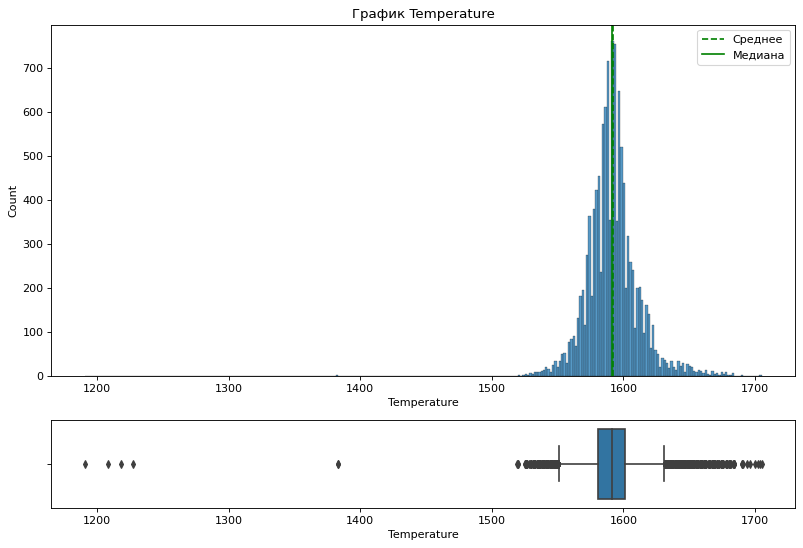

In [15]:
data_temp = all_table('steel.data_temp', addition)
table_info(data_temp)
sns_draw(data_temp, 'Temperature')

* Данные распределенны нормально, есть выбросы, оставим их, так как это скорее всего экстремальные значения, а не ошибочные

Найдём: cколько времени прошло между первым и последним замером температуры.

In [16]:
query = '''
WITH temp AS
    (SELECT DISTINCT key,
            FIRST_VALUE("Temperature") OVER(PARTITION BY key) AS first_temp,
            CASE
                WHEN EXTRACT(EPOCH FROM LAST_VALUE("MesaureTime") OVER(PARTITION BY key) -
                     FIRST_VALUE("MesaureTime") OVER(PARTITION BY key)) < 0
 
                    THEN ROUND(((EXTRACT(EPOCH FROM LAST_VALUE("MesaureTime") OVER(PARTITION BY key) - 
                        FIRST_VALUE("MesaureTime") OVER(PARTITION BY key)) + 86400) / 60)::numeric, 2)

                ELSE ROUND(((EXTRACT(EPOCH FROM LAST_VALUE("MesaureTime") OVER(PARTITION BY key) -
                     FIRST_VALUE("MesaureTime") OVER(PARTITION BY key))) / 60.0)::numeric, 2)

            END as time_diff,
            LAST_VALUE("Temperature") OVER(PARTITION BY key) AS temperature
    FROM steel.data_temp
    WHERE key < 2500 AND "Temperature" > 1400)
SELECT t.key,
       t.first_temp,
       t.time_diff,
       t.temperature
FROM temp t
WHERE t.time_diff > 0
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2475 non-null   int64  
 1   first_temp   2475 non-null   float64
 2   time_diff    2475 non-null   float64
 3   temperature  2475 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 77.5 KB


,key,first_temp,time_diff,temperature
0,2323,1598.0,52.88,1591.0
1,1402,1609.0,16.42,1593.0
2,2068,1623.0,64.50,1616.0
3,650,1577.0,95.08,1621.0
4,1022,1603.0,52.53,1592.0
5,2273,1592.0,20.55,1584.0
6,2217,1635.0,15.72,1649.0
7,2221,1640.0,18.80,1587.0
8,50,1603.0,30.92,1606.0
9,2339,1588.0,22.67,1593.0


,key,first_temp,time_diff,temperature
count,2475.000000,2475.000000,2475.000000,2475.000000
mean,1250.787071,1589.029899,30.904982,1595.336162
std,719.787271,24.998058,21.686365,16.023153
min,1.000000,1519.000000,3.900000,1541.000000
25%,629.500000,1572.000000,19.710000,1587.000000
50%,1252.000000,1588.000000,26.520000,1593.000000
75%,1872.500000,1605.000000,37.685000,1599.000000
max,2499.000000,1679.000000,392.280000,1700.000000


Кол-во уникальных значений в столбце 'key': 2475
Количество дубликатов: 0


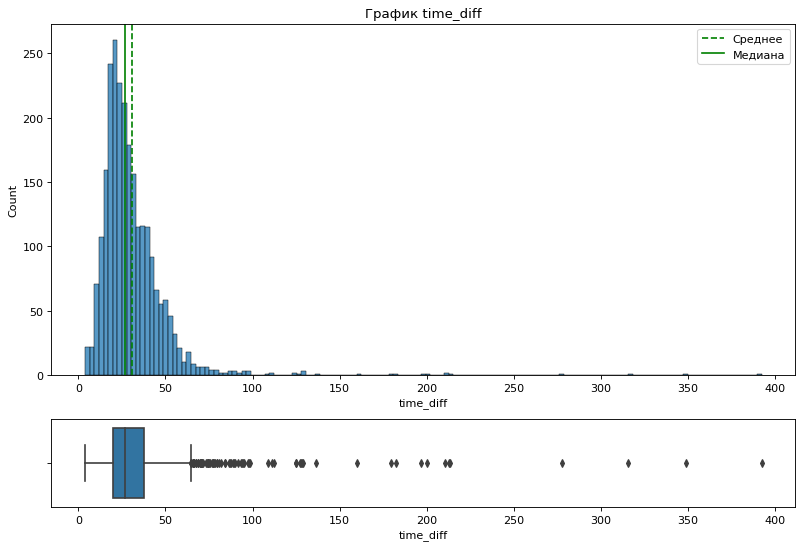

In [17]:
data_temp = unload(query)
table_info(data_temp)
sns_draw(data_temp, 'time_diff')

***Выводы***
* Данные распределенны нормально, есть выбросы, оставим их, так как это скорее всего экстремальные значения, а не ошибочные;
* Время нагрева (от первого до последнего измерения температуры) лежит в диапазоне от 5 до 100 минут, средее время нагрева 30 минут;
* Неккоректные данные с ключом от 2500 и выше, удалены.

###  Данные об электродах

Проанализируем таблицу `data_arc`

In [18]:
data_arc = all_table('steel.data_arc')
table_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397
5,2,11:34:14,11:36:31,0.438063,0.283043
6,2,11:38:50,11:44:28,1.296415,0.892914
7,2,11:46:19,11:48:25,0.490377,0.305281
8,2,11:49:48,11:53:18,0.827743,0.516874
9,3,12:06:54,12:11:34,1.062053,0.671494


,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Кол-во уникальных значений в столбце 'key': 3214
Количество дубликатов: 0


Удалим отрицательные значения реактивной энергии

In [19]:
addition = '''\nWHERE key < 2500 AND "ReactivePower" > 0'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11448 entries, 0 to 11447
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            11448 non-null  int64  
 1   BeginHeat      11448 non-null  object 
 2   EndHeat        11448 non-null  object 
 3   ActivePower    11448 non-null  float64
 4   ReactivePower  11448 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 447.3+ KB


,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397
5,2,11:34:14,11:36:31,0.438063,0.283043
6,2,11:38:50,11:44:28,1.296415,0.892914
7,2,11:46:19,11:48:25,0.490377,0.305281
8,2,11:49:48,11:53:18,0.827743,0.516874
9,3,12:06:54,12:11:34,1.062053,0.671494


,key,ActivePower,ReactivePower
count,11448.000000,11448.000000,11448.000000
mean,1242.061233,0.676134,0.503883
std,718.930527,0.408541,0.310745
min,1.000000,0.030002,0.020806
25%,623.000000,0.398304,0.291773
50%,1245.000000,0.561410,0.417518
75%,1870.000000,0.864471,0.645324
max,2499.000000,3.731596,2.676388


Кол-во уникальных значений в столбце 'key': 2475
Количество дубликатов: 0


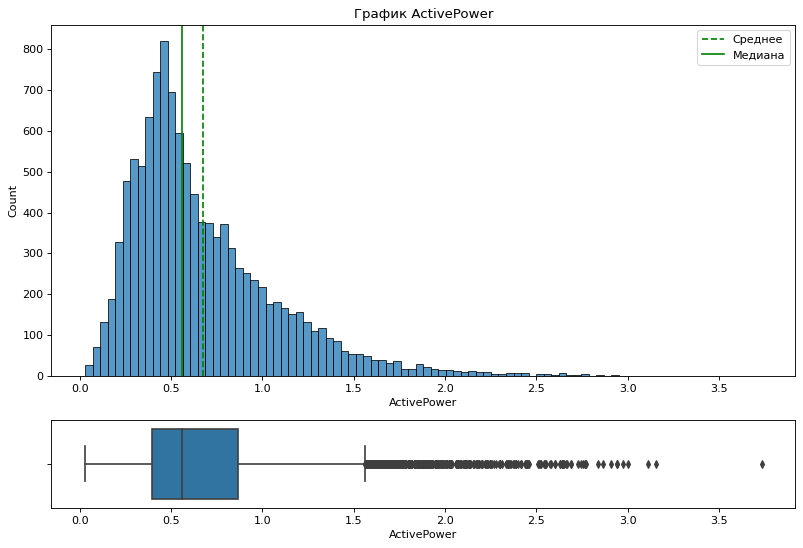

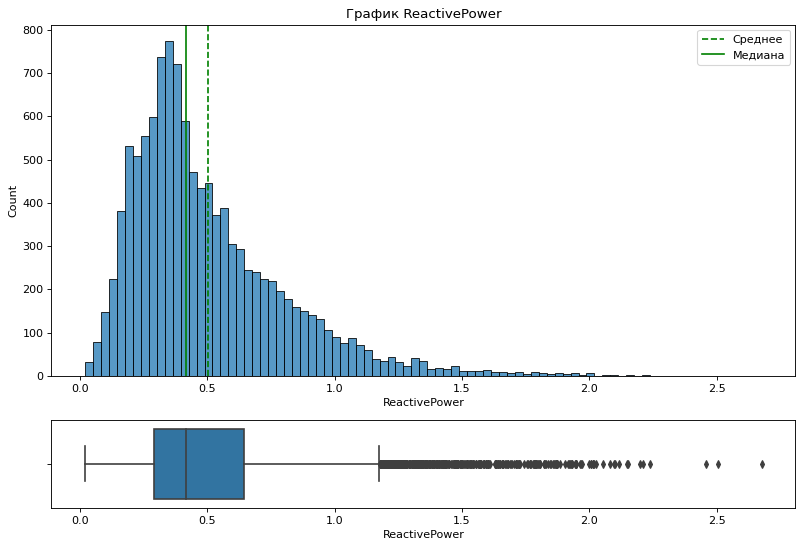

In [20]:
data_arc = all_table('steel.data_arc', addition)
table_info(data_arc)
sns_draw(data_arc, 'ActivePower')
sns_draw(data_arc, 'ReactivePower')

* Данные распределены нормально

Найдём суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродами.

In [21]:
query = '''
WITH time_heating AS
  (SELECT key,
           CASE
               WHEN EXTRACT(EPOCH FROM "EndHeat" - "BeginHeat") < 0
                   THEN ROUND(((EXTRACT(EPOCH FROM "EndHeat" - "BeginHeat") + 86400) / 60)::numeric, 2)
               ELSE ROUND((EXTRACT(EPOCH FROM "EndHeat" - "BeginHeat") / 60)::numeric, 2)
           END as heating_time,
           "ActivePower" / "ReactivePower" AS act_rct
    FROM steel.data_arc
    WHERE key < 2500 AND "ReactivePower" > 0)
SELECT th.key,
       SUM(th.heating_time) AS sum_time_heating,
       COUNT(th.key) AS count_heating,
       AVG(th.act_rct) AS avg_act_rct
FROM time_heating th
GROUP BY key;
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2475 non-null   int64  
 1   sum_time_heating  2475 non-null   float64
 2   count_heating     2475 non-null   int64  
 3   avg_act_rct       2475 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 77.5 KB


,key,sum_time_heating,count_heating,avg_act_rct
0,1798,6.83,3,1.181831
1,1489,14.01,5,1.426258
2,2335,19.93,8,1.351835
3,1269,23.43,9,1.224074
4,652,22.64,7,1.383168
5,273,9.79,3,1.419361
6,1560,12.83,7,1.311109
7,51,21.54,4,1.479534
8,951,12.26,4,1.408326
9,1898,19.10,5,1.234994


,key,sum_time_heating,count_heating,avg_act_rct
count,2475.000000,2475.000000,2475.000000,2475.000000
mean,1250.787071,13.331673,4.625455,1.360743
std,719.787271,5.680355,1.610369,0.130703
min,1.000000,0.950000,1.000000,0.687735
25%,629.500000,9.540000,4.000000,1.294206
50%,1252.000000,12.870000,4.000000,1.372818
75%,1872.500000,16.435000,6.000000,1.440708
max,2499.000000,69.820000,16.000000,1.782164


Кол-во уникальных значений в столбце 'key': 2475
Количество дубликатов: 0


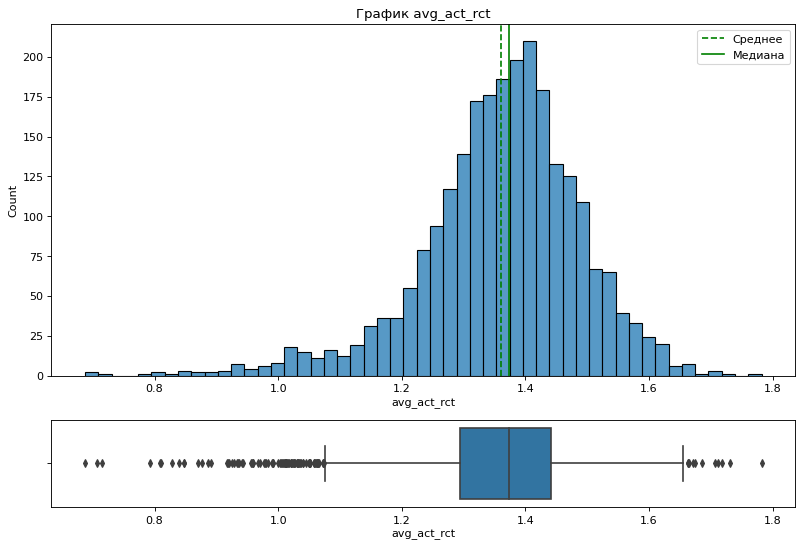

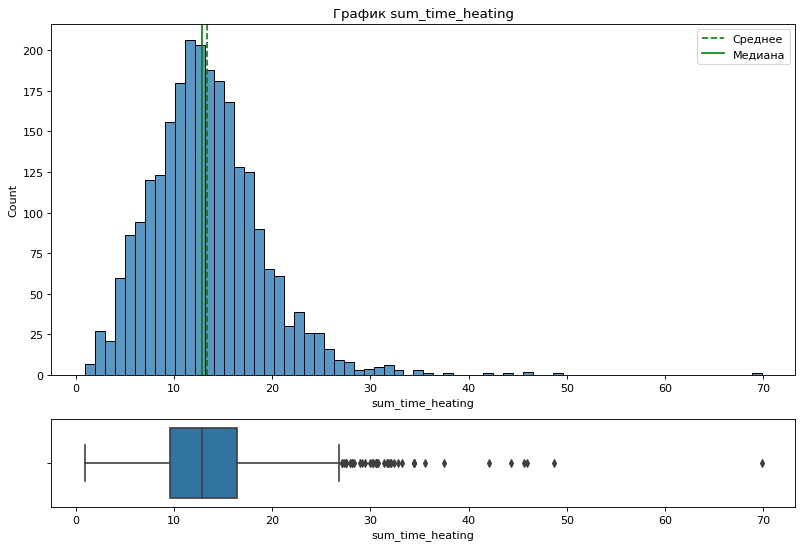

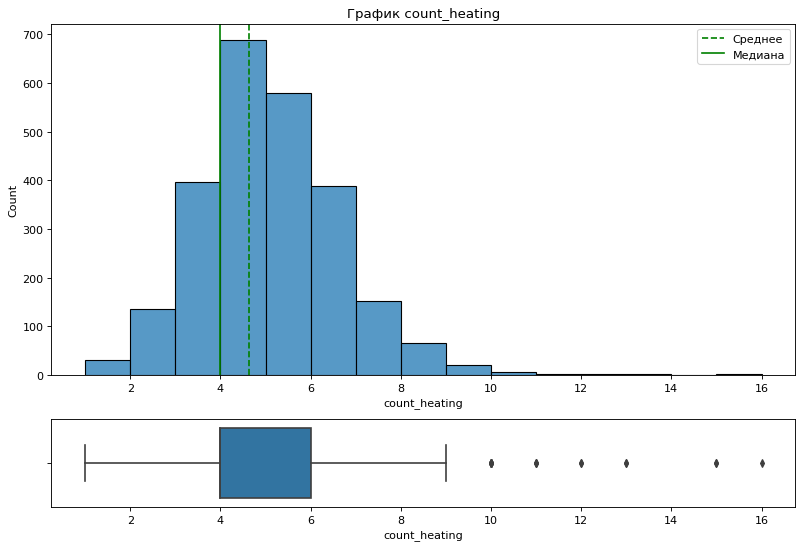

In [22]:
data_arc = unload(query)
table_info(data_arc)
sns_draw(data_arc, 'avg_act_rct')
sns_draw(data_arc, 'sum_time_heating')
sns_draw(data_arc, 'count_heating', 15)

***Выводы***
* Добавленны следующие признаки:
    * Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродами;
    * Количество запусков нагрева электродами;
    * Среднее соотношение потребления активной и реактивной мощности.
* Данные распределенны нормально, есть выбросы, оставим их, так как это скорее всего экстремальные значения, а не ошибочные.

### Данные о продувке сплава газом

Проанализируем таблицу `data_gas`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2497 entries, 0 to 2496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2497 non-null   int64  
 1   gas     2497 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 39.1 KB


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,gas
count,2497.000000,2497.000000
mean,1250.820184,11.045716
std,721.249206,6.371633
min,1.000000,0.008399
25%,627.000000,7.043909
50%,1251.000000,9.874748
75%,1875.000000,13.842088
max,2499.000000,77.995040


Кол-во уникальных значений в столбце 'key': 2497
Количество дубликатов: 0


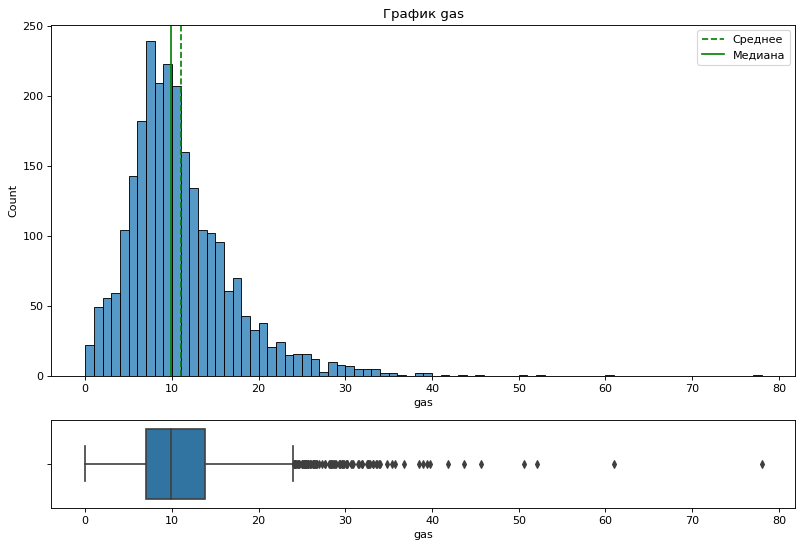

In [23]:
addition = '''\nWHERE key < 2500'''
data_gas = all_table('steel.data_gas', addition)
table_info(data_gas)
sns_draw(data_gas, 'gas')

***Выводы***
* Данные распределенны нормально, есть выбросы, оставим их, так как это скорее всего экстремальные значения, а не ошибочные

### Данные о подаче сыпучих материалов

Проанализируем таблицы `data_bulk` и `data_bulk_time`

In [24]:
order_key = '''
    \nWHERE key < 2500
    \nORDER BY key
'''

In [25]:
data_bulk = all_table('steel.data_bulk', order_key)
table_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      2408 non-null   int64  
 1   Bulk 1   199 non-null    float64
 2   Bulk 2   13 non-null     float64
 3   Bulk 3   965 non-null    float64
 4   Bulk 4   814 non-null    float64
 5   Bulk 5   53 non-null     float64
 6   Bulk 6   444 non-null    float64
 7   Bulk 7   14 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   13 non-null     float64
 10  Bulk 10  143 non-null    float64
 11  Bulk 11  130 non-null    float64
 12  Bulk 12  1882 non-null   float64
 13  Bulk 13  14 non-null     float64
 14  Bulk 14  2137 non-null   float64
 15  Bulk 15  1713 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 301.1 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,2408.000000,199.000000,13.000000,965.000000,814.000000,53.000000,444.000000,14.000000,1.0,13.000000,143.000000,130.000000,1882.000000,14.000000,2137.000000,1713.000000
mean,1251.150748,40.115578,254.846154,114.880829,107.095823,116.018868,119.141892,336.857143,49.0,79.692308,82.293706,76.053846,267.425080,177.571429,173.257838,164.323993
std,716.611468,18.226180,25.973853,77.345585,49.081208,95.189182,70.472639,217.268305,NaN,25.795299,27.788900,60.373554,124.972375,50.344527,64.708663,50.033956
min,1.000000,10.000000,228.000000,6.000000,13.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,29.000000,1.000000
25%,631.750000,27.000000,242.000000,57.000000,73.000000,70.000000,72.000000,160.750000,49.0,66.000000,58.000000,25.000000,204.000000,153.250000,122.000000,105.000000
50%,1252.500000,33.000000,248.000000,97.000000,105.000000,88.000000,100.000000,349.000000,49.0,68.000000,85.000000,60.000000,207.000000,154.500000,153.000000,199.000000
75%,1867.250000,46.500000,258.000000,152.000000,136.750000,148.000000,155.250000,481.750000,49.0,71.000000,104.000000,105.500000,360.000000,158.500000,208.000000,205.000000
max,2499.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Кол-во уникальных значений в столбце 'key': 2408
Количество дубликатов: 0


In [26]:
data_bulk_time = all_table('steel.data_bulk_time', order_key)
table_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      2408 non-null   int64 
 1   Bulk 1   199 non-null    object
 2   Bulk 2   13 non-null     object
 3   Bulk 3   965 non-null    object
 4   Bulk 4   814 non-null    object
 5   Bulk 5   53 non-null     object
 6   Bulk 6   444 non-null    object
 7   Bulk 7   14 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   13 non-null     object
 10  Bulk 10  143 non-null    object
 11  Bulk 11  130 non-null    object
 12  Bulk 12  1882 non-null   object
 13  Bulk 13  14 non-null     object
 14  Bulk 14  2137 non-null   object
 15  Bulk 15  1713 non-null   object
dtypes: int64(1), object(15)
memory usage: 301.1+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
5,6,None,None,None,13:59:24,None,None,None,None,None,None,None,13:53:27,None,13:53:27,13:53:27
6,7,None,None,None,14:29:14,None,None,None,None,None,None,None,14:22:19,None,14:22:19,14:22:19
7,8,None,None,None,15:04:05,None,None,None,None,None,None,None,14:55:46,None,14:55:46,14:55:46
8,9,None,None,None,15:47:34,None,None,None,None,None,None,None,15:41:00,None,15:41:00,15:41:00
9,10,None,None,None,None,None,None,None,None,None,None,None,16:18:52,None,16:18:52,16:18:52


,key
count,2408.000000
mean,1251.150748
std,716.611468
min,1.000000
25%,631.750000
50%,1252.500000
75%,1867.250000
max,2499.000000


Кол-во уникальных значений в столбце 'key': 2408
Количество дубликатов: 0


Проверим таблицы на расхождение данных

In [27]:
comparison(data_bulk, data_bulk_time)

Контрольные суммы таблиц совпадают


Удалим столбцы в которых очень мало значений

In [28]:
query = '''
SELECT key,
       "Bulk 1",
       "Bulk 3",
       "Bulk 4",
       "Bulk 6",
       "Bulk 10",
       "Bulk 11",
       "Bulk 12",
       "Bulk 14",
       "Bulk 15"
FROM steel.data_bulk
WHERE key < 2500 AND
      ("Bulk 1" IS NOT NULL OR
       "Bulk 3" IS NOT NULL OR
       "Bulk 4" IS NOT NULL OR
       "Bulk 6" IS NOT NULL OR
       "Bulk 10" IS NOT NULL OR
       "Bulk 11" IS NOT NULL OR
       "Bulk 12" IS NOT NULL OR
       "Bulk 14" IS NOT NULL OR
       "Bulk 15" IS NOT NULL)
ORDER BY key
'''

In [29]:
data_bulk = unload(query)
table_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      2401 non-null   int64  
 1   Bulk 1   199 non-null    float64
 2   Bulk 3   965 non-null    float64
 3   Bulk 4   814 non-null    float64
 4   Bulk 6   444 non-null    float64
 5   Bulk 10  143 non-null    float64
 6   Bulk 11  130 non-null    float64
 7   Bulk 12  1882 non-null   float64
 8   Bulk 14  2137 non-null   float64
 9   Bulk 15  1713 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 187.7 KB


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,NaN,NaN,43.0,NaN,NaN,NaN,206.0,150.0,154.0
1,2,NaN,NaN,73.0,NaN,NaN,NaN,206.0,149.0,154.0
2,3,NaN,NaN,34.0,NaN,NaN,NaN,205.0,152.0,153.0
3,4,NaN,NaN,81.0,NaN,NaN,NaN,207.0,153.0,154.0
4,5,NaN,NaN,78.0,NaN,NaN,NaN,203.0,151.0,152.0
5,6,NaN,NaN,117.0,NaN,NaN,NaN,204.0,201.0,154.0
6,7,NaN,NaN,117.0,NaN,NaN,NaN,204.0,152.0,154.0
7,8,NaN,NaN,99.0,NaN,NaN,NaN,410.0,252.0,153.0
8,9,NaN,NaN,117.0,NaN,NaN,NaN,107.0,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,203.0,102.0,204.0


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
count,2401.000000,199.000000,965.000000,814.000000,444.000000,143.000000,130.000000,1882.000000,2137.000000,1713.000000
mean,1251.229488,40.115578,114.880829,107.095823,119.141892,82.293706,76.053846,267.425080,173.257838,164.323993
std,716.475383,18.226180,77.345585,49.081208,70.472639,27.788900,60.373554,124.972375,64.708663,50.033956
min,1.000000,10.000000,6.000000,13.000000,17.000000,24.000000,8.000000,53.000000,29.000000,1.000000
25%,632.000000,27.000000,57.000000,73.000000,72.000000,58.000000,25.000000,204.000000,122.000000,105.000000
50%,1252.000000,33.000000,97.000000,105.000000,100.000000,85.000000,60.000000,207.000000,153.000000,199.000000
75%,1866.000000,46.500000,152.000000,136.750000,155.250000,104.000000,105.500000,360.000000,208.000000,205.000000
max,2499.000000,185.000000,454.000000,281.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000


Кол-во уникальных значений в столбце 'key': 2401
Количество дубликатов: 0


***Выводы***
* Данные из таблицы `data_bulk_time` использовать не будем, так как конкретное время подачи материалов, не несёт полезной информации;
* Удалили столбцы с малым кол-вом значений.

### Данные о проволочных материалах 

Проанализируем таблицы `data_wire` и `data_wire_time`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2373 non-null   int64  
 1   Wire 1  2349 non-null   float64
 2   Wire 2  833 non-null    float64
 3   Wire 3  39 non-null     float64
 4   Wire 4  12 non-null     float64
 5   Wire 5  0 non-null      object 
 6   Wire 6  45 non-null     float64
 7   Wire 7  4 non-null      float64
 8   Wire 8  13 non-null     float64
 9   Wire 9  28 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 185.5+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,None,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,None,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,None,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,None,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,2373.000000,2349.000000,833.000000,39.000000,12.000000,45.000000,4.000000,13.000000,28.000000
mean,1251.101138,103.307961,50.846731,193.182538,59.496235,50.659374,3.703414,55.772561,35.098700
std,716.092572,42.605530,40.050640,100.867783,30.804638,37.743040,3.818433,20.235591,19.627598
min,1.000000,1.918800,0.030160,0.144144,24.148801,0.137280,0.234208,45.076721,4.622800
25%,629.000000,74.212326,20.207199,93.189102,38.347402,25.053600,0.849004,46.002319,23.177700
50%,1254.000000,102.023994,40.112801,236.972740,49.661561,40.085762,3.044704,46.187439,30.084599
75%,1869.000000,128.933990,70.062721,277.068801,84.755579,65.036400,5.899114,46.279999,44.944904
max,2499.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,90.053604


Кол-во уникальных значений в столбце 'key': 2373
Количество дубликатов: 0


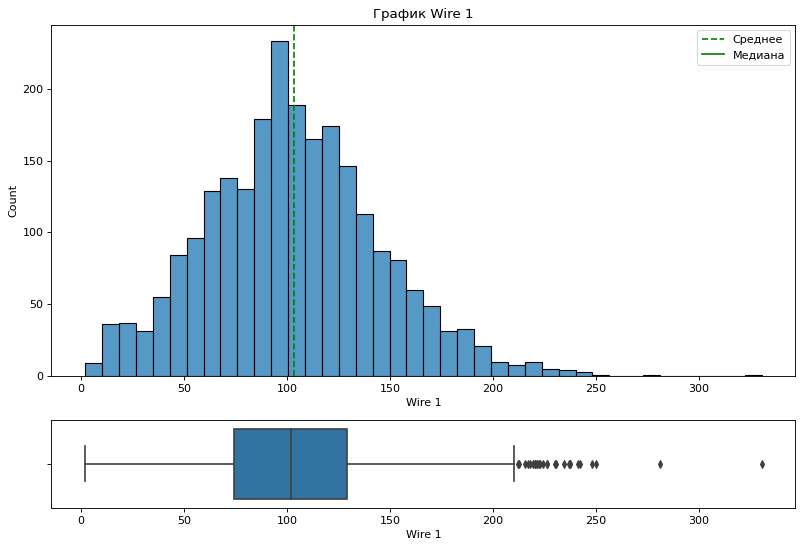

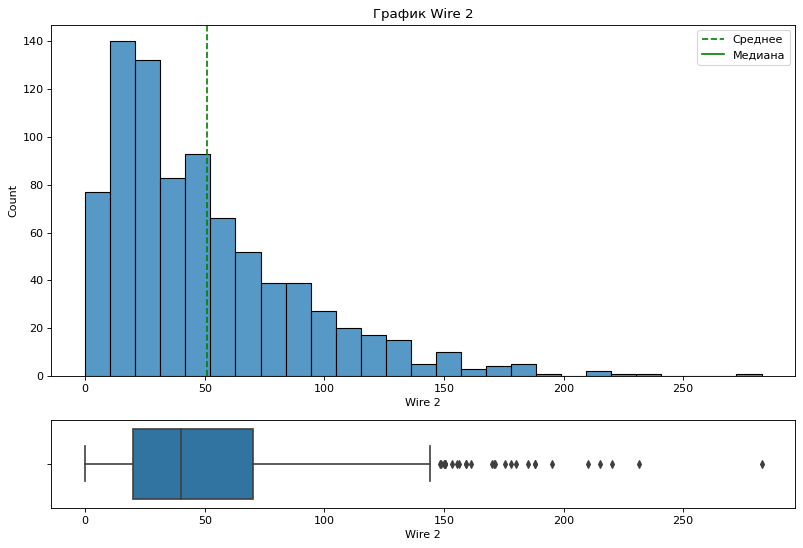

In [30]:
data_wire = all_table('steel.data_wire', order_key)
table_info(data_wire)
sns_draw(data_wire, 'Wire 1')
sns_draw(data_wire, 'Wire 2')

In [31]:
data_wire_time = all_table('steel.data_wire_time', order_key)
table_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     2373 non-null   int64 
 1   Wire 1  2349 non-null   object
 2   Wire 2  833 non-null    object
 3   Wire 3  39 non-null     object
 4   Wire 4  12 non-null     object
 5   Wire 5  0 non-null      object
 6   Wire 6  45 non-null     object
 7   Wire 7  4 non-null      object
 8   Wire 8  13 non-null     object
 9   Wire 9  28 non-null     object
dtypes: int64(1), object(9)
memory usage: 185.5+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None
5,6,13:59:02,13:59:54,None,None,None,None,None,None,None
6,7,14:28:46,None,None,None,None,None,None,None,None
7,8,15:03:42,None,None,None,None,None,None,None,None
8,9,15:42:43,15:58:12,None,None,None,None,None,None,None
9,10,16:20:25,16:21:02,None,None,None,None,None,None,None


,key
count,2373.000000
mean,1251.101138
std,716.092572
min,1.000000
25%,629.000000
50%,1254.000000
75%,1869.000000
max,2499.000000


Кол-во уникальных значений в столбце 'key': 2373
Количество дубликатов: 0


Проверим таблицы на расхождение данных

In [32]:
comparison(data_wire, data_wire_time)

Контрольные суммы таблиц совпадают


***Выводы***
* Данные из таблицы `data_wire_time` использовать не будем, так как конкретное время подачи материалов, не несёт полезной информации;
* В общей таблице удалилим столбцы с малым кол-вом значений;
* Данные распределенны нормально, есть выбросы, оставим их, так как это скорее всего экстремальные значения, а не ошибочные

## Подготовка данных

### Общая таблица

In [33]:
query = '''
WITH temp AS
    (SELECT t.key,
            t.first_temp,
            t.time_diff,
            t.temperature
    FROM (SELECT DISTINCT key,
                 FIRST_VALUE("Temperature") OVER(PARTITION BY key) AS first_temp,
                 CASE
                     WHEN EXTRACT(EPOCH FROM LAST_VALUE("MesaureTime") OVER(PARTITION BY key) -
                          FIRST_VALUE("MesaureTime") OVER(PARTITION BY key)) < 0

                         THEN ROUND(((EXTRACT(EPOCH FROM LAST_VALUE("MesaureTime") OVER(PARTITION BY key) - 
                              FIRST_VALUE("MesaureTime") OVER(PARTITION BY key)) + 86400) / 60)::numeric, 2)

                     ELSE ROUND(((EXTRACT(EPOCH FROM LAST_VALUE("MesaureTime") OVER(PARTITION BY key) -
                            FIRST_VALUE("MesaureTime") OVER(PARTITION BY key))) / 60.0)::numeric, 2)

                 END AS time_diff,
                 LAST_VALUE("Temperature") OVER(PARTITION BY key) AS temperature
          FROM steel.data_temp
          WHERE key < 2500) t
    WHERE t.time_diff > 0),
arc AS
    (SELECT ar.key AS key,
            SUM(ar.heating_time) AS sum_time_heating,
            COUNT(ar.key) AS count_heating,
            ROUND(AVG(ar.act_rct)::numeric, 2) AS avg_act_rct
    FROM (SELECT key,
                 CASE
                     WHEN EXTRACT(EPOCH FROM "EndHeat" - "BeginHeat") < 0
                         THEN ROUND(((EXTRACT(EPOCH FROM "EndHeat" - "BeginHeat") + 86400) / 60)::numeric, 2)
                     ELSE ROUND((EXTRACT(EPOCH FROM "EndHeat" - "BeginHeat") / 60)::numeric, 2)
                 END as heating_time,
                 "ActivePower" / "ReactivePower" AS act_rct
         FROM steel.data_arc
         WHERE key < 2500 AND "ReactivePower" > 0) AS ar
    GROUP BY ar.key),
gas AS
    (SELECT key,
            ROUND(gas::numeric, 2) AS gas
     FROM steel.data_gas
     WHERE key < 2500),
bulk AS
    (SELECT key,
            "Bulk 1" AS bulk1,
            "Bulk 3" AS bulk3,
            "Bulk 4" AS bulk4,
            "Bulk 6" AS bulk6,
            "Bulk 10" AS bulk10,
            "Bulk 11" AS bulk11,
            "Bulk 12" AS bulk12,
            "Bulk 14" AS bulk14,
            "Bulk 15" AS bulk15
    FROM steel.data_bulk
    WHERE key < 2500 AND
          ("Bulk 1" IS NOT NULL OR
           "Bulk 3" IS NOT NULL OR
           "Bulk 4" IS NOT NULL OR
           "Bulk 6" IS NOT NULL OR
           "Bulk 10" IS NOT NULL OR
           "Bulk 11" IS NOT NULL OR
           "Bulk 12" IS NOT NULL OR
           "Bulk 14" IS NOT NULL OR
           "Bulk 15" IS NOT NULL)
    ORDER BY key),
wire AS
    (SELECT key,
            ROUND("Wire 1"::numeric, 2) AS wire1,
            ROUND("Wire 2"::numeric, 2) AS wire2,
            ROUND("Wire 3"::numeric, 3) AS wire3
    FROM steel.data_wire
    WHERE key < 2500 AND
          ("Wire 1" IS NOT NULL OR
           "Wire 2" IS NOT NULL)
    ORDER BY key)
SELECT t.first_temp,
       t.time_diff,
       a.sum_time_heating,
       a.count_heating,
       a.avg_act_rct,
       g.gas,
       b.bulk1,
       b.bulk3,
       b.bulk4,
       b.bulk6,
       b.bulk10,
       b.bulk11,
       b.bulk12,
       b.bulk14,
       b.bulk15,
       w.wire1,
       w.wire2,
       t.temperature 
FROM temp AS t
     JOIN arc AS a ON t.key = a.key
     JOIN gas AS g ON a.key = g.key
     JOIN bulk AS b ON g.key = b.key
     JOIN wire AS w ON b.key = w.key
'''

Заменим пропуски на нули

In [34]:
df = unload(query)
df = df.fillna(0)

Выведем общие данные

In [35]:
df.info()
display(df.head())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2315 entries, 0 to 2314
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   first_temp        2315 non-null   float64
 1   time_diff         2315 non-null   float64
 2   sum_time_heating  2315 non-null   float64
 3   count_heating     2315 non-null   int64  
 4   avg_act_rct       2315 non-null   float64
 5   gas               2315 non-null   float64
 6   bulk1             2315 non-null   float64
 7   bulk3             2315 non-null   float64
 8   bulk4             2315 non-null   float64
 9   bulk6             2315 non-null   float64
 10  bulk10            2315 non-null   float64
 11  bulk11            2315 non-null   float64
 12  bulk12            2315 non-null   float64
 13  bulk14            2315 non-null   float64
 14  bulk15            2315 non-null   float64
 15  wire1             2315 non-null   float64
 16  wire2             2315 non-null   float64


,first_temp,time_diff,sum_time_heating,count_heating,avg_act_rct,gas,bulk1,bulk3,bulk4,bulk6,bulk10,bulk11,bulk12,bulk14,bulk15,wire1,wire2,temperature
0,1571.0,14.35,18.30,5,1.54,29.75,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.06,0.00,1613.0
1,1581.0,21.75,13.51,4,1.55,12.56,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.05,0.00,1602.0
2,1596.0,21.67,10.92,5,1.58,28.55,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.16,0.00,1599.0
3,1601.0,6.47,12.35,4,1.56,18.84,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.06,0.00,1625.0
4,1576.0,12.70,14.48,4,1.48,5.41,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.24,9.11,1602.0


,first_temp,time_diff,sum_time_heating,count_heating,avg_act_rct,gas,bulk1,bulk3,bulk4,bulk6,bulk10,bulk11,bulk12,bulk14,bulk15,wire1,wire2,temperature
count,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000
mean,1586.623326,31.554168,13.473853,4.696328,1.361711,11.338285,3.292441,47.616415,37.396112,22.482505,5.083369,4.241901,209.474298,154.511015,120.545572,103.032246,17.716406,1593.404752
std,28.189793,21.869041,5.685642,1.606426,0.131351,6.312757,12.130147,75.453934,58.750854,55.893211,20.977278,22.543538,156.813532,80.896774,84.434603,43.002262,33.698536,11.016679
min,1191.000000,3.900000,0.950000,1.000000,0.690000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1541.000000
25%,1571.000000,20.235000,9.700000,4.000000,1.290000,7.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,106.000000,0.000000,74.210000,0.000000,1587.000000
50%,1587.000000,27.230000,12.970000,5.000000,1.370000,10.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,101.650000,0.000000,1593.000000
75%,1603.000000,38.100000,16.565000,6.000000,1.440000,14.175000,0.000000,80.000000,78.000000,0.000000,0.000000,0.000000,284.500000,204.000000,204.000000,128.150000,23.160000,1598.000000
max,1660.000000,392.280000,69.820000,16.000000,1.780000,78.000000,185.000000,454.000000,281.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000,330.310000,282.780000,1653.000000


* Получили 2315 строк;
* Данные успешно выгруженны.

### Разбивка данных на выборки

In [36]:
X = df.drop('temperature', axis=1)
y = df['temperature']

X_train_all, X_test, y_train_all, y_test  = train_test_split(X, y,
            test_size=0.2, shuffle=True, random_state=56)
X_train, X_valid, y_train, y_valid  = train_test_split(X_train_all, y_train_all,
            test_size=0.25, shuffle=True, random_state=56)
print(f'Итоговые размеры выборок, обучающая:валидационная:тестовая - '
      f'{y_train.count() / y.count():.0%}:{y_valid.count()/ y.count():.0%}'
      f':{y_test.count()/ y.count():.0%}')

Итоговые размеры выборок, обучающая:валидационная:тестовая - 60%:20%:20%


### Масштабированние признаков

In [37]:
scaler = StandardScaler().fit(X_train)
X_train_all = pd.DataFrame(scaler.transform(X_train_all), columns=X.columns)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

## Обучение моделей

Создадим таблицу для записи результатов моделей

In [38]:
table_results = pd.DataFrame(columns=['Name', 'Best result', 'Best params'])

Функция для вывода результатов моделей

In [39]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

In [40]:
def result(optimize, table=None, name=None):
    print(f'{style.BOLD}'
          f'Результаты модели на валидационных данных\n\n'
          f'{style.END}'
          f'Лучший гиперпараметры: {optimize.best_params}\n'
          f'Лучший результат модели: {optimize.best_value:.2f}') 
    
    # Запишем результаты в таблицу
    if name:
        return table.append({'Name':name,
           'Best result':round(optimize.best_value, 2),
           'Best params':optimize.best_params}, ignore_index=True)

In [41]:
SEED = 56
EARLY_STOPPING_ROUND = 50

### CatBoostRegressor

In [42]:
def objective_cb(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 0.2, step=0.01)
    param['max_depth'] = trial.suggest_int('max_depth', 2, 8, step=1)
    param['l2_leaf_reg'] = trial.suggest_int('l2_leaf_reg', 1, 10, step=1)
    param['iterations'] = 600
    param['use_best_model'] = True
    param['loss_function'] = 'MAE'
    param['metric_period'] = 10
    param['eval_metric'] = 'MAE'
    param['random_state'] = SEED
    
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                  early_stopping_rounds=EARLY_STOPPING_ROUND, verbose=1)
    loss = mean_absolute_error(y_valid, regressor.predict(X_valid))
    return loss

In [43]:
%%time
study_cb = optuna.create_study(direction="minimize")
study_cb.optimize(objective_cb, n_trials=100, n_jobs=-1)

[I 2023-01-19 11:13:02,792] A new study created in memory with name: no-name-1cdce6b6-9fab-4924-bf67-49911d57b90f
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 7.7971192	test: 7.9469752	best: 7.9469752 (0)	total: 53.2ms	remaining: 31.9s
0:	learn: 8.1012085	test: 8.1830660	best: 8.1830660 (0)	total: 58.3ms	remaining: 34.9s
10:	learn: 7.8650197	test: 7.9875710	best: 7.9875710 (10)	total: 66ms	remaining: 3.53s
20:	learn: 7.6528618	test: 7.8139784	best: 7.8139784 (20)	total: 74.7ms	remaining: 2.06s
30:	learn: 7.4626498	test: 7.6452978	best: 7.6452978 (30)	total: 83.4ms	remaining: 1.53s
10:	learn: 6.0305299	test: 6.9262868	best: 6.9262868 (10)	total: 97.6ms	remaining: 5.23s
40:	learn: 7.3119367	test: 7.5374417	best: 7.5374417 (40)	total: 91.9ms	remaining: 1.25s
50:	learn: 7.1767337	test: 7.4327357	best: 7.4327357 (50)	total: 99.7ms	remaining: 1.07s
60:	learn: 7.0587138	test: 7.3361258	best: 7.3361258 (60)	total: 108ms	remaining: 951ms
70:	learn: 6.9568807	test: 7.2506609	best: 7.2506609 (70)	total: 116ms	remaining: 861ms
20:	learn: 5.2537553	test: 6.6204576	best: 6.6204576 (20)	total: 140ms	remaining: 3.85s
80:	learn: 6.8767310	test: 7.1

100:	learn: 6.7270550	test: 7.0780117	best: 7.0780117 (100)	total: 139ms	remaining: 686ms
30:	learn: 4.7935453	test: 6.4370429	best: 6.4370429 (30)	total: 182ms	remaining: 3.35s
110:	learn: 6.6619899	test: 7.0213945	best: 7.0213945 (110)	total: 147ms	remaining: 649ms
120:	learn: 6.5977882	test: 6.9600691	best: 6.9600691 (120)	total: 156ms	remaining: 617ms
0:	learn: 7.7351322	test: 7.8849666	best: 7.8849666 (0)	total: 6.56ms	remaining: 3.93s
130:	learn: 6.5347551	test: 6.9142902	best: 6.9142902 (130)	total: 165ms	remaining: 591ms
40:	learn: 4.4650623	test: 6.3458382	best: 6.3339527 (36)	total: 230ms	remaining: 3.14s
0:	learn: 7.7322956	test: 7.8969752	best: 7.8969752 (0)	total: 7.04ms	remaining: 4.21s
0:	learn: 8.0472848	test: 8.1231956	best: 8.1231956 (0)	total: 944us	remaining: 566ms
140:	learn: 6.4818966	test: 6.8862992	best: 6.8862992 (140)	total: 176ms	remaining: 573ms


10:	learn: 7.5171307	test: 7.6752937	best: 7.6752937 (10)	total: 7.88ms	remaining: 422ms
10:	learn: 6.0952384	test: 6.8270273	best: 6.8270273 (10)	total: 39ms	remaining: 2.08s
0:	learn: 7.9766801	test: 8.0678608	best: 8.0678608 (0)	total: 1.99ms	remaining: 1.19s
0:	learn: 8.0282927	test: 8.1257009	best: 8.1257009 (0)	total: 5.1ms	remaining: 3.05s
20:	learn: 7.0532531	test: 7.3123632	best: 7.3123632 (20)	total: 15.9ms	remaining: 437ms
150:	learn: 6.4280140	test: 6.8452936	best: 6.8452936 (150)	total: 190ms	remaining: 564ms
50:	learn: 4.0982172	test: 6.2521934	best: 6.2521934 (50)	total: 289ms	remaining: 3.11s
30:	learn: 6.8150789	test: 7.0968068	best: 7.0968068 (30)	total: 24.1ms	remaining: 442ms
10:	learn: 7.1593778	test: 7.3822453	best: 7.3822453 (10)	total: 15.1ms	remaining: 806ms
160:	learn: 6.3760645	test: 6.8126428	best: 6.8126428 (160)	total: 203ms	remaining: 552ms
40:	learn: 6.6203453	test: 6.9520301	best: 6.9520301 (40)	total: 32.6ms	remaining: 444ms
10:	learn: 5.7216816	test: 

[I 2023-01-19 11:13:09,348] Trial 6 finished with value: 6.076000779451479 and parameters: {'learning_rate': 0.08, 'max_depth': 2, 'l2_leaf_reg': 1}. Best is trial 6 with value: 6.076000779451479.


180:	learn: 2.7637248	test: 6.0828863	best: 6.0733684 (166)	total: 2.63s	remaining: 6.09s
110:	learn: 2.7464094	test: 6.2233605	best: 6.2227474 (106)	total: 3.88s	remaining: 17.1s
400:	learn: 4.6565870	test: 6.0393423	best: 6.0387797 (399)	total: 1.43s	remaining: 709ms
560:	learn: 5.3503822	test: 6.1745629	best: 6.1742051 (558)	total: 1.58s	remaining: 110ms
410:	learn: 4.6369647	test: 6.0407198	best: 6.0343781 (406)	total: 1.53s	remaining: 704ms
420:	learn: 4.4440256	test: 6.0107398	best: 6.0107398 (420)	total: 1.63s	remaining: 693ms
570:	learn: 5.3369241	test: 6.1699242	best: 6.1699242 (570)	total: 1.59s	remaining: 80.7ms
160:	learn: 2.4942312	test: 6.1346602	best: 6.0933330 (142)	total: 3.89s	remaining: 10.6s
420:	learn: 4.6210770	test: 6.0314491	best: 6.0314491 (420)	total: 1.54s	remaining: 657ms
430:	learn: 4.4280724	test: 6.0006845	best: 6.0006845 (430)	total: 1.64s	remaining: 645ms
190:	learn: 2.7014278	test: 6.0938659	best: 6.0733684 (166)	total: 2.94s	remaining: 6.29s
580:	lear

440:	learn: 4.5835850	test: 6.0336136	best: 6.0254561 (433)	total: 1.66s	remaining: 599ms
450:	learn: 4.4037527	test: 5.9952090	best: 5.9952090 (450)	total: 1.76s	remaining: 582ms
120:	learn: 2.6165915	test: 6.2272399	best: 6.2160428 (113)	total: 4.3s	remaining: 17s
599:	learn: 5.2960852	test: 6.1493008	best: 6.1493008 (599)	total: 1.72s	remaining: 0us
450:	learn: 4.5653914	test: 6.0262932	best: 6.0254561 (433)	total: 1.67s	remaining: 553ms

bestTest = 6.149300757
bestIteration = 599

180:	learn: 4.3597851	test: 6.1118366	best: 6.1118366 (180)	total: 3.3s	remaining: 7.65s
460:	learn: 4.3884916	test: 5.9961034	best: 5.9946758 (451)	total: 1.78s	remaining: 536ms
200:	learn: 2.6636617	test: 6.0851246	best: 6.0733684 (166)	total: 3.16s	remaining: 6.27s
170:	learn: 2.4148233	test: 6.1149598	best: 6.0933330 (142)	total: 4.22s	remaining: 10.6s
460:	learn: 4.5445248	test: 6.0270118	best: 6.0254561 (433)	total: 1.69s	remaining: 509ms
470:	learn: 4.3733209	test: 5.9957559	best: 5.9946758 (451)	t

[I 2023-01-19 11:13:10,548] Trial 1 finished with value: 6.149301757008155 and parameters: {'learning_rate': 0.02, 'max_depth': 3, 'l2_leaf_reg': 1}. Best is trial 6 with value: 6.076000779451479.


10:	learn: 6.9769137	test: 7.2648218	best: 7.2648218 (10)	total: 20.9ms	remaining: 1.12s
510:	learn: 4.3073979	test: 5.9798568	best: 5.9776225 (491)	total: 1.84s	remaining: 320ms
500:	learn: 4.4799047	test: 6.0060071	best: 6.0060071 (500)	total: 1.74s	remaining: 345ms
20:	learn: 6.4142406	test: 6.8654963	best: 6.8654963 (20)	total: 37.2ms	remaining: 1.03s
140:	learn: 2.4252759	test: 6.2208484	best: 6.2083493 (137)	total: 4.78s	remaining: 15.6s
530:	learn: 4.2818827	test: 5.9671042	best: 5.9669531 (529)	total: 1.86s	remaining: 242ms


[I 2023-01-19 11:13:10,758] Trial 4 finished with value: 6.073369402767608 and parameters: {'learning_rate': 0.19, 'max_depth': 6, 'l2_leaf_reg': 7}. Best is trial 4 with value: 6.073369402767608.


520:	learn: 4.4527661	test: 6.0059653	best: 6.0007598 (512)	total: 1.85s	remaining: 280ms
190:	learn: 2.2897569	test: 6.1079685	best: 6.0933330 (142)	total: 4.61s	remaining: 9.87s
210:	learn: 4.1623727	test: 6.0924961	best: 6.0912997 (202)	total: 3.62s	remaining: 6.67s
540:	learn: 4.2733780	test: 5.9647188	best: 5.9647188 (540)	total: 1.87s	remaining: 204ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.093332995
bestIteration = 142

Shrink model to first 143 iterations.
30:	learn: 6.0835400	test: 6.6540383	best: 6.6540383 (30)	total: 143ms	remaining: 2.62s
530:	learn: 4.4412516	test: 6.0039145	best: 6.0007598 (512)	total: 1.86s	remaining: 242ms


550:	learn: 4.2662009	test: 5.9617960	best: 5.9617960 (550)	total: 1.89s	remaining: 168ms
220:	learn: 4.0925265	test: 6.0878475	best: 6.0865253 (219)	total: 3.7s	remaining: 6.35s
40:	learn: 5.8983898	test: 6.5427823	best: 6.5427823 (40)	total: 161ms	remaining: 2.19s
540:	learn: 4.4232751	test: 5.9925284	best: 5.9920258 (538)	total: 1.88s	remaining: 204ms
150:	learn: 2.3391915	test: 6.2307969	best: 6.2083493 (137)	total: 4.89s	remaining: 14.5s
560:	learn: 4.2563196	test: 5.9590380	best: 5.9590380 (560)	total: 1.96s	remaining: 136ms
550:	learn: 4.4028889	test: 5.9863458	best: 5.9863458 (550)	total: 1.95s	remaining: 173ms
50:	learn: 5.7338478	test: 6.3922797	best: 6.3922797 (50)	total: 236ms	remaining: 2.54s
570:	learn: 4.2453430	test: 5.9546255	best: 5.9538105 (563)	total: 1.97s	remaining: 100ms
0:	learn: 7.7959385	test: 7.9339947	best: 7.9339947 (0)	total: 4.43ms	remaining: 2.65s
560:	learn: 4.3859790	test: 5.9887484	best: 5.9841860 (557)	total: 1.96s	remaining: 136ms


[I 2023-01-19 11:13:11,248] Trial 0 finished with value: 6.093333994859391 and parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 7, 'l2_leaf_reg': 1}. Best is trial 4 with value: 6.073369402767608.


60:	learn: 5.6050829	test: 6.3004782	best: 6.3004782 (60)	total: 256ms	remaining: 2.26s
230:	learn: 4.0263037	test: 6.0761069	best: 6.0761069 (230)	total: 3.84s	remaining: 6.13s
160:	learn: 2.2632732	test: 6.2144187	best: 6.2083493 (137)	total: 5.07s	remaining: 13.8s
580:	learn: 4.2303928	test: 5.9518414	best: 5.9518414 (580)	total: 1.98s	remaining: 64.8ms
570:	learn: 4.3694810	test: 5.9823178	best: 5.9805775 (567)	total: 1.97s	remaining: 100ms
10:	learn: 6.2670623	test: 7.0193505	best: 7.0193505 (10)	total: 135ms	remaining: 7.2s
580:	learn: 4.3602149	test: 5.9833818	best: 5.9805775 (567)	total: 2.03s	remaining: 66.5ms
599:	learn: 4.2104603	test: 5.9485268	best: 5.9476959 (594)	total: 2s	remaining: 0us

240:	learn: 3.9652452	test: 6.0671027	best: 6.0671027 (240)	total: 3.92s	remaining: 5.84s
bestTest = 5.947695933
bestIteration = 594

Shrink model to first 595 iterations.
0:	learn: 7.9411077	test: 8.0498910	best: 8.0498910 (0)	total: 2.45ms	remaining: 1.47s
590:	learn: 4.3494680	test: 

[I 2023-01-19 11:13:11,764] Trial 5 finished with value: 5.9476969334540915 and parameters: {'learning_rate': 0.09, 'max_depth': 3, 'l2_leaf_reg': 9}. Best is trial 5 with value: 5.9476969334540915.


10:	learn: 6.9120885	test: 7.1980054	best: 7.1980054 (10)	total: 21ms	remaining: 1.12s
250:	learn: 3.9134070	test: 6.0565859	best: 6.0565859 (250)	total: 3.98s	remaining: 5.53s
90:	learn: 5.1986300	test: 6.1088790	best: 6.1084317 (89)	total: 383ms	remaining: 2.14s
20:	learn: 6.4205598	test: 6.8340572	best: 6.8340572 (20)	total: 37.4ms	remaining: 1.03s
100:	learn: 5.0893899	test: 6.0530321	best: 6.0528101 (99)	total: 397ms	remaining: 1.96s
30:	learn: 5.1231819	test: 6.4886049	best: 6.4886049 (30)	total: 233ms	remaining: 4.27s
260:	learn: 3.8601180	test: 6.0566577	best: 6.0559929 (255)	total: 4.01s	remaining: 5.21s
30:	learn: 6.1169727	test: 6.6602565	best: 6.6602565 (30)	total: 74.5ms	remaining: 1.37s
110:	learn: 4.9935761	test: 6.0339663	best: 6.0326100 (105)	total: 415ms	remaining: 1.83s
10:	learn: 6.4450224	test: 7.0067028	best: 7.0067028 (10)	total: 23.6ms	remaining: 1.26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.208349312
bestIteration = 137

Shrink model

[I 2023-01-19 11:13:12,147] Trial 2 finished with value: 5.9793514092638445 and parameters: {'learning_rate': 0.06999999999999999, 'max_depth': 3, 'l2_leaf_reg': 4}. Best is trial 5 with value: 5.9476969334540915.


120:	learn: 4.8997876	test: 6.0237142	best: 6.0237142 (120)	total: 508ms	remaining: 2.01s
40:	learn: 5.9036563	test: 6.5649384	best: 6.5649384 (40)	total: 94.5ms	remaining: 1.29s
270:	learn: 3.8102886	test: 6.0466577	best: 6.0466577 (270)	total: 4.12s	remaining: 5.01s
20:	learn: 5.8407406	test: 6.6808871	best: 6.6808871 (20)	total: 48.5ms	remaining: 1.34s
50:	learn: 4.5992147	test: 6.2714715	best: 6.2658900 (48)	total: 451ms	remaining: 4.85s
130:	learn: 4.8277446	test: 6.0232278	best: 6.0232278 (130)	total: 522ms	remaining: 1.87s
60:	learn: 5.5788418	test: 6.3619097	best: 6.3619097 (60)	total: 195ms	remaining: 1.72s
140:	learn: 4.7615914	test: 6.0139737	best: 6.0139737 (140)	total: 611ms	remaining: 1.99s
280:	learn: 3.7582690	test: 6.0363755	best: 6.0357670 (279)	total: 4.24s	remaining: 4.81s
40:	learn: 5.2689392	test: 6.3573967	best: 6.3573967 (40)	total: 233ms	remaining: 3.18s
60:	learn: 4.3674417	test: 6.2214229	best: 6.2059006 (57)	total: 553ms	remaining: 4.89s
70:	learn: 5.4249934

[I 2023-01-19 11:13:12,512] Trial 3 finished with value: 6.208350311879378 and parameters: {'learning_rate': 0.18000000000000002, 'max_depth': 7, 'l2_leaf_reg': 1}. Best is trial 5 with value: 5.9476969334540915.


160:	learn: 4.6361530	test: 5.9856437	best: 5.9844597 (159)	total: 639ms	remaining: 1.74s
290:	learn: 3.7134551	test: 6.0316739	best: 6.0310872 (289)	total: 4.27s	remaining: 4.54s
90:	learn: 5.1880292	test: 6.1938054	best: 6.1858599 (89)	total: 240ms	remaining: 1.34s
60:	learn: 4.8337130	test: 6.2218675	best: 6.2218675 (60)	total: 279ms	remaining: 2.46s
0:	learn: 7.9414029	test: 8.0349450	best: 8.0349450 (0)	total: 1.59ms	remaining: 953ms
170:	learn: 4.5777160	test: 5.9866013	best: 5.9838875 (169)	total: 654ms	remaining: 1.64s
100:	learn: 5.0742910	test: 6.1661885	best: 6.1656470 (99)	total: 258ms	remaining: 1.28s
0:	learn: 7.8631524	test: 7.9987031	best: 7.9987031 (0)	total: 12.9ms	remaining: 7.7s
10:	learn: 7.0069006	test: 7.2540882	best: 7.2540882 (10)	total: 14.2ms	remaining: 761ms
80:	learn: 3.9749912	test: 6.1912132	best: 6.1829025 (74)	total: 666ms	remaining: 4.27s


300:	learn: 3.6644033	test: 6.0304525	best: 6.0264400 (299)	total: 4.31s	remaining: 4.28s
70:	learn: 4.6927187	test: 6.1967133	best: 6.1914293 (67)	total: 307ms	remaining: 2.29s
180:	learn: 4.5261410	test: 5.9753137	best: 5.9737163 (176)	total: 678ms	remaining: 1.57s
110:	learn: 4.9765064	test: 6.1451012	best: 6.1408017 (107)	total: 276ms	remaining: 1.22s
20:	learn: 6.5727174	test: 6.9676974	best: 6.9676974 (20)	total: 26.4ms	remaining: 727ms
30:	learn: 6.3090612	test: 6.7783464	best: 6.7783464 (30)	total: 37.9ms	remaining: 696ms
120:	learn: 4.8951037	test: 6.1321153	best: 6.1321153 (120)	total: 296ms	remaining: 1.17s
80:	learn: 4.5443938	test: 6.1754988	best: 6.1753239 (78)	total: 408ms	remaining: 2.62s
190:	learn: 4.4823425	test: 5.9716830	best: 5.9685715 (185)	total: 773ms	remaining: 1.65s
40:	learn: 6.1227111	test: 6.6979538	best: 6.6979538 (40)	total: 51.7ms	remaining: 705ms
90:	learn: 3.7973227	test: 6.2161745	best: 6.1829025 (74)	total: 718ms	remaining: 4.02s
310:	learn: 3.62097

[I 2023-01-19 11:13:14,947] Trial 9 finished with value: 6.182903492630033 and parameters: {'learning_rate': 0.16, 'max_depth': 6, 'l2_leaf_reg': 9}. Best is trial 5 with value: 5.9476969334540915.


190:	learn: 4.8836167	test: 6.0675003	best: 6.0673543 (189)	total: 565ms	remaining: 1.21s
230:	learn: 4.2779294	test: 6.0146069	best: 6.0146069 (230)	total: 1.12s	remaining: 1.79s
300:	learn: 4.0620300	test: 5.9280360	best: 5.9215970 (263)	total: 1.52s	remaining: 1.51s
360:	learn: 3.4164566	test: 6.0289884	best: 6.0205945 (350)	total: 5.74s	remaining: 3.8s
200:	learn: 4.8412784	test: 6.0633756	best: 6.0616030 (197)	total: 580ms	remaining: 1.15s
210:	learn: 4.7882060	test: 6.0507258	best: 6.0507258 (210)	total: 596ms	remaining: 1.1s
310:	learn: 4.0266822	test: 5.9295276	best: 5.9213820 (304)	total: 1.62s	remaining: 1.5s
240:	learn: 4.2298404	test: 5.9906903	best: 5.9906522 (238)	total: 1.31s	remaining: 1.96s
170:	learn: 3.6726274	test: 6.1024087	best: 6.0730606 (157)	total: 1.25s	remaining: 3.13s
220:	learn: 4.7545734	test: 6.0407016	best: 6.0389656 (219)	total: 691ms	remaining: 1.19s
370:	learn: 3.3884222	test: 6.0284168	best: 6.0205945 (350)	total: 5.86s	remaining: 3.62s
250:	learn: 4

270:	learn: 4.1164638	test: 5.9744245	best: 5.9740917 (266)	total: 1.54s	remaining: 1.87s
380:	learn: 3.3611934	test: 6.0304522	best: 6.0205945 (350)	total: 6.15s	remaining: 3.54s
260:	learn: 4.6139645	test: 6.0326777	best: 6.0319061 (222)	total: 828ms	remaining: 1.07s
190:	learn: 3.5821659	test: 6.0904370	best: 6.0730606 (157)	total: 1.56s	remaining: 3.34s
30:	learn: 3.9252800	test: 6.3661852	best: 6.3661852 (30)	total: 2.37s	remaining: 43.4s
350:	learn: 3.9187539	test: 5.9146176	best: 5.9094758 (338)	total: 1.86s	remaining: 1.32s
270:	learn: 4.5791680	test: 6.0045809	best: 6.0020859 (268)	total: 841ms	remaining: 1.02s
60:	learn: 4.1437194	test: 6.2362596	best: 6.2362596 (60)	total: 1.94s	remaining: 17.2s
280:	learn: 4.0777794	test: 5.9795304	best: 5.9726705 (274)	total: 1.71s	remaining: 1.94s
280:	learn: 4.5462980	test: 5.9895849	best: 5.9877162 (278)	total: 854ms	remaining: 969ms
360:	learn: 3.8982147	test: 5.9201699	best: 5.9094758 (338)	total: 1.89s	remaining: 1.25s
200:	learn: 3.

[I 2023-01-19 11:13:16,850] Trial 7 finished with value: 6.0205955176214605 and parameters: {'learning_rate': 0.05, 'max_depth': 6, 'l2_leaf_reg': 5}. Best is trial 5 with value: 5.9476969334540915.
[I 2023-01-19 11:13:16,867] Trial 8 finished with value: 5.909476764765071 and parameters: {'learning_rate': 0.09999999999999999, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 8 with value: 5.909476764765071.


370:	learn: 4.3250567	test: 5.9434712	best: 5.9320545 (356)	total: 1.02s	remaining: 631ms
260:	learn: 3.2601006	test: 6.0377742	best: 6.0300749 (254)	total: 1.94s	remaining: 2.52s
380:	learn: 4.3068781	test: 5.9521842	best: 5.9320545 (356)	total: 1.03s	remaining: 595ms
390:	learn: 4.2840232	test: 5.9505259	best: 5.9320545 (356)	total: 1.05s	remaining: 561ms
270:	learn: 3.2251447	test: 6.0342720	best: 6.0300749 (254)	total: 2.03s	remaining: 2.47s
90:	learn: 3.4911763	test: 6.2079347	best: 6.1772152 (80)	total: 2.82s	remaining: 15.8s
40:	learn: 5.4546314	test: 6.5444542	best: 6.5444542 (40)	total: 472ms	remaining: 6.43s
400:	learn: 4.2723736	test: 5.9445100	best: 5.9320545 (356)	total: 1.06s	remaining: 526ms
280:	learn: 3.1807538	test: 6.0197144	best: 6.0188860 (279)	total: 2.05s	remaining: 2.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.932054534
bestIteration = 356

Shrink model to first 357 iterations.
100:	learn: 3.3372875	test: 6.1891237	best: 6.1772152 (80

[I 2023-01-19 11:13:17,604] Trial 10 finished with value: 5.968570937285557 and parameters: {'learning_rate': 0.09999999999999999, 'max_depth': 4, 'l2_leaf_reg': 9}. Best is trial 8 with value: 5.909476764765071.
[I 2023-01-19 11:13:17,686] Trial 12 finished with value: 5.93205553401827 and parameters: {'learning_rate': 0.11, 'max_depth': 3, 'l2_leaf_reg': 2}. Best is trial 8 with value: 5.909476764765071.


0:	learn: 7.9708413	test: 8.0476232	best: 8.0476232 (0)	total: 947us	remaining: 567ms
0:	learn: 7.9028356	test: 8.0166729	best: 8.0166729 (0)	total: 2.8ms	remaining: 1.68s
70:	learn: 4.8695232	test: 6.2795625	best: 6.2795625 (70)	total: 667ms	remaining: 4.97s
10:	learn: 7.1083122	test: 7.3227239	best: 7.3227239 (10)	total: 9.31ms	remaining: 498ms
80:	learn: 4.7450759	test: 6.2595080	best: 6.2595080 (80)	total: 794ms	remaining: 5.09s
50:	learn: 6.0749633	test: 6.5359930	best: 6.5359930 (50)	total: 127ms	remaining: 1.36s
30:	learn: 5.9407128	test: 6.5380593	best: 6.5380593 (30)	total: 52.6ms	remaining: 966ms
60:	learn: 5.9126795	test: 6.3995617	best: 6.3995617 (60)	total: 135ms	remaining: 1.2s
330:	learn: 3.0429617	test: 6.0203198	best: 6.0100204 (311)	total: 2.4s	remaining: 1.95s
70:	learn: 5.8341323	test: 6.3581399	best: 6.3562555 (69)	total: 143ms	remaining: 1.07s
40:	learn: 5.7618811	test: 6.4513663	best: 6.4506590 (39)	total: 72.9ms	remaining: 994ms


80:	learn: 5.7523766	test: 6.3053350	best: 6.3053350 (80)	total: 152ms	remaining: 975ms
340:	learn: 3.0279773	test: 6.0214579	best: 6.0100204 (311)	total: 2.43s	remaining: 1.84s
90:	learn: 4.5820955	test: 6.2390603	best: 6.2347140 (84)	total: 924ms	remaining: 5.17s
90:	learn: 5.6779345	test: 6.2658092	best: 6.2658092 (90)	total: 161ms	remaining: 903ms
50:	learn: 5.5836056	test: 6.2910418	best: 6.2867054 (49)	total: 91.5ms	remaining: 985ms
130:	learn: 3.0232584	test: 6.1465209	best: 6.1465209 (130)	total: 3.48s	remaining: 12.5s
100:	learn: 5.6156508	test: 6.2210730	best: 6.2210730 (100)	total: 170ms	remaining: 842ms
80:	learn: 2.4523553	test: 6.4690201	best: 6.3365186 (32)	total: 4.11s	remaining: 26.3s
60:	learn: 5.4553337	test: 6.2446910	best: 6.2446910 (60)	total: 109ms	remaining: 967ms
350:	learn: 2.9996122	test: 6.0236221	best: 6.0100204 (311)	total: 2.46s	remaining: 1.74s
0:	learn: 7.8836995	test: 8.0000638	best: 8.0000638 (0)	total: 2.36ms	remaining: 1.41s
Stopped by overfitting d

[I 2023-01-19 11:13:19,051] Trial 14 finished with value: 6.336519618258594 and parameters: {'learning_rate': 0.18000000000000002, 'max_depth': 8, 'l2_leaf_reg': 2}. Best is trial 8 with value: 5.909476764765071.


20:	learn: 6.2090956	test: 6.6988000	best: 6.6988000 (20)	total: 37.5ms	remaining: 1.03s
160:	learn: 5.3295726	test: 6.1334088	best: 6.1260080 (155)	total: 223ms	remaining: 609ms
30:	learn: 5.8852314	test: 6.4418138	best: 6.4418138 (30)	total: 55.6ms	remaining: 1.02s
150:	learn: 2.8705524	test: 6.1258606	best: 6.1245537 (149)	total: 3.66s	remaining: 10.9s
120:	learn: 4.1844854	test: 6.1818869	best: 6.1781621 (110)	total: 1.11s	remaining: 4.39s
90:	learn: 5.0406902	test: 6.1067839	best: 6.1041108 (89)	total: 166ms	remaining: 926ms
170:	learn: 5.2901044	test: 6.1167114	best: 6.1167114 (170)	total: 306ms	remaining: 767ms
100:	learn: 4.9469377	test: 6.0750054	best: 6.0737785 (99)	total: 179ms	remaining: 883ms
30:	learn: 5.8895777	test: 6.4540756	best: 6.4540756 (30)	total: 55.4ms	remaining: 1.02s
40:	learn: 5.6999635	test: 6.3373520	best: 6.3355891 (39)	total: 75.5ms	remaining: 1.03s
130:	learn: 4.0691969	test: 6.1836650	best: 6.1743859 (125)	total: 1.14s	remaining: 4.09s
110:	learn: 4.832

[I 2023-01-19 11:13:19,404] Trial 11 finished with value: 6.010021360099168 and parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 5, 'l2_leaf_reg': 3}. Best is trial 8 with value: 5.909476764765071.


220:	learn: 5.1462450	test: 6.0990096	best: 6.0990096 (220)	total: 346ms	remaining: 594ms
130:	learn: 4.6878919	test: 5.9879811	best: 5.9879811 (130)	total: 292ms	remaining: 1.04s
70:	learn: 5.2217488	test: 6.0783490	best: 6.0711700 (69)	total: 204ms	remaining: 1.52s
230:	learn: 5.1181089	test: 6.0983443	best: 6.0930344 (229)	total: 354ms	remaining: 565ms
60:	learn: 5.3826270	test: 6.1517892	best: 6.1517892 (60)	total: 192ms	remaining: 1.7s
140:	learn: 4.6097945	test: 5.9885153	best: 5.9862301 (132)	total: 307ms	remaining: 1s
240:	learn: 5.0786846	test: 6.0862472	best: 6.0862472 (240)	total: 361ms	remaining: 538ms
80:	learn: 5.0863217	test: 6.0657143	best: 6.0636568 (78)	total: 219ms	remaining: 1.4s
70:	learn: 5.2465558	test: 6.1219289	best: 6.1219289 (70)	total: 206ms	remaining: 1.54s
170:	learn: 2.6943327	test: 6.0991194	best: 6.0991194 (170)	total: 4.04s	remaining: 10.1s
250:	learn: 5.0591158	test: 6.0769860	best: 6.0769860 (250)	total: 370ms	remaining: 514ms
150:	learn: 3.8815278	t

180:	learn: 2.6450018	test: 6.0895702	best: 6.0895620 (178)	total: 4.24s	remaining: 9.81s
300:	learn: 4.9369456	test: 6.0448639	best: 6.0423132 (292)	total: 414ms	remaining: 411ms
100:	learn: 4.9098463	test: 6.0091678	best: 6.0074856 (98)	total: 263ms	remaining: 1.3s
10:	learn: 6.7042052	test: 7.0589634	best: 7.0589634 (10)	total: 23.4ms	remaining: 1.25s
120:	learn: 4.7302022	test: 5.9544719	best: 5.9530361 (117)	total: 291ms	remaining: 1.15s
310:	learn: 4.9157990	test: 6.0409590	best: 6.0387482 (307)	total: 423ms	remaining: 393ms
180:	learn: 4.3671382	test: 5.9426974	best: 5.9426974 (180)	total: 382ms	remaining: 883ms
170:	learn: 3.7247397	test: 6.1724738	best: 6.1410057 (147)	total: 1.51s	remaining: 3.79s
110:	learn: 4.8364192	test: 6.0209000	best: 6.0074856 (98)	total: 282ms	remaining: 1.24s
320:	learn: 4.8880120	test: 6.0274267	best: 6.0274267 (320)	total: 433ms	remaining: 377ms
20:	learn: 6.2076453	test: 6.6981632	best: 6.6981632 (20)	total: 43.2ms	remaining: 1.19s
130:	learn: 4.6

[I 2023-01-19 11:13:21,447] Trial 15 finished with value: 6.141006732543744 and parameters: {'learning_rate': 0.09, 'max_depth': 6, 'l2_leaf_reg': 2}. Best is trial 8 with value: 5.909476764765071.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2023-01-19 11:13:21,556] Trial 16 finished with value: 5.999602171847028 and parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 2, 'l2_leaf_reg': 5}. Best is trial 8 with value: 5.909476764765071.


120:	learn: 4.7302022	test: 5.9544719	best: 5.9530361 (117)	total: 434ms	remaining: 1.72s
290:	learn: 3.9629478	test: 5.9027967	best: 5.8996982 (267)	total: 925ms	remaining: 982ms
90:	learn: 5.0406902	test: 6.1067839	best: 6.1041108 (89)	total: 484ms	remaining: 2.71s
130:	learn: 4.6519458	test: 5.9339856	best: 5.9308975 (128)	total: 453ms	remaining: 1.62s
230:	learn: 4.0993490	test: 5.8052069	best: 5.8018218 (228)	total: 779ms	remaining: 1.24s
220:	learn: 4.1747538	test: 5.9585906	best: 5.9461172 (175)	total: 785ms	remaining: 1.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.946117229
bestIteration = 175

Shrink model to first 176 iterations.
230:	learn: 2.3191831	test: 6.1099870	best: 6.0867273 (181)	total: 5.22s	remaining: 8.35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.086727314
bestIteration = 181

Shrink model to first 182 iterations.
240:	learn: 4.0595108	test: 5.8140725	best: 5.8018218 (228)	total: 897ms	remaining: 1.33s
140:	lea

160:	learn: 4.4472077	test: 5.9011517	best: 5.8886488 (154)	total: 517ms	remaining: 1.41s
120:	learn: 4.7532434	test: 6.0167899	best: 6.0167899 (120)	total: 632ms	remaining: 2.5s
260:	learn: 3.9785365	test: 5.8111295	best: 5.8018218 (228)	total: 930ms	remaining: 1.21s
320:	learn: 3.8707315	test: 5.8912245	best: 5.8902459 (314)	total: 1.08s	remaining: 939ms
170:	learn: 4.3828834	test: 5.8812823	best: 5.8812823 (170)	total: 531ms	remaining: 1.33s
130:	learn: 4.6878919	test: 5.9879811	best: 5.9879811 (130)	total: 646ms	remaining: 2.31s
270:	learn: 3.9360308	test: 5.7953908	best: 5.7953105 (269)	total: 945ms	remaining: 1.15s
180:	learn: 4.3280244	test: 5.8790045	best: 5.8790045 (180)	total: 546ms	remaining: 1.26s


[I 2023-01-19 11:13:22,159] Trial 13 finished with value: 6.086728313791906 and parameters: {'learning_rate': 0.12, 'max_depth': 7, 'l2_leaf_reg': 4}. Best is trial 8 with value: 5.909476764765071.
[I 2023-01-19 11:13:22,179] Trial 18 finished with value: 5.946118229072499 and parameters: {'learning_rate': 0.13, 'max_depth': 4, 'l2_leaf_reg': 7}. Best is trial 8 with value: 5.909476764765071.


140:	learn: 4.6097945	test: 5.9885153	best: 5.9862301 (132)	total: 664ms	remaining: 2.16s
330:	learn: 3.8392426	test: 5.8834528	best: 5.8834528 (330)	total: 1.1s	remaining: 894ms
190:	learn: 4.2840129	test: 5.8695770	best: 5.8632490 (188)	total: 559ms	remaining: 1.2s
280:	learn: 3.9031288	test: 5.7862434	best: 5.7862434 (280)	total: 960ms	remaining: 1.09s
340:	learn: 3.8130198	test: 5.8870811	best: 5.8816540 (332)	total: 1.11s	remaining: 847ms
150:	learn: 4.5497439	test: 5.9785097	best: 5.9785097 (150)	total: 679ms	remaining: 2.02s
200:	learn: 4.2399610	test: 5.8612905	best: 5.8596785 (191)	total: 573ms	remaining: 1.14s
0:	learn: 7.9028356	test: 8.0166729	best: 8.0166729 (0)	total: 1.49ms	remaining: 890ms
0:	learn: 7.9219717	test: 8.0332820	best: 8.0332820 (0)	total: 1.56ms	remaining: 934ms
290:	learn: 3.8660662	test: 5.7828828	best: 5.7816481 (289)	total: 973ms	remaining: 1.03s
350:	learn: 3.7868093	test: 5.8874199	best: 5.8816540 (332)	total: 1.13s	remaining: 802ms
210:	learn: 4.1970

30:	learn: 6.0197138	test: 6.6009163	best: 6.6009163 (30)	total: 49.7ms	remaining: 912ms
230:	learn: 4.0993490	test: 5.8052069	best: 5.8018218 (228)	total: 625ms	remaining: 998ms
180:	learn: 4.3671382	test: 5.9426974	best: 5.9426974 (180)	total: 738ms	remaining: 1.71s
30:	learn: 5.9372836	test: 6.5267254	best: 6.5267254 (30)	total: 83.2ms	remaining: 1.53s
320:	learn: 3.7906227	test: 5.7775367	best: 5.7737567 (301)	total: 1.03s	remaining: 894ms
380:	learn: 3.7275641	test: 5.8815063	best: 5.8815063 (380)	total: 1.21s	remaining: 695ms
240:	learn: 4.0595108	test: 5.8140725	best: 5.8018218 (228)	total: 640ms	remaining: 953ms
190:	learn: 4.3202646	test: 5.9386348	best: 5.9386348 (190)	total: 752ms	remaining: 1.61s
40:	learn: 5.8105550	test: 6.4931321	best: 6.4931321 (40)	total: 67.9ms	remaining: 926ms
40:	learn: 5.7685282	test: 6.4513715	best: 6.4420340 (38)	total: 101ms	remaining: 1.38s
330:	learn: 3.7564925	test: 5.7812160	best: 5.7737567 (301)	total: 1.05s	remaining: 851ms
390:	learn: 3.7

[I 2023-01-19 11:13:24,366] Trial 19 finished with value: 5.7681373289690665 and parameters: {'learning_rate': 0.13, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


90:	learn: 5.0406902	test: 6.1067839	best: 6.1041108 (89)	total: 611ms	remaining: 3.42s
350:	learn: 3.7121661	test: 5.7722800	best: 5.7681363 (346)	total: 1.11s	remaining: 791ms
150:	learn: 4.5419509	test: 6.0083710	best: 6.0025829 (149)	total: 740ms	remaining: 2.2s
70:	learn: 5.9776353	test: 6.6307209	best: 6.6307209 (70)	total: 479ms	remaining: 3.57s
150:	learn: 4.6101930	test: 5.9948367	best: 5.9853185 (139)	total: 625ms	remaining: 1.86s
300:	learn: 3.9297728	test: 5.9056974	best: 5.8996982 (267)	total: 1.38s	remaining: 1.37s
500:	learn: 3.5008579	test: 5.8629974	best: 5.8613713 (499)	total: 2.01s	remaining: 398ms
100:	learn: 4.9469377	test: 6.0750054	best: 6.0737785 (99)	total: 629ms	remaining: 3.11s
160:	learn: 4.4852386	test: 6.0116197	best: 5.9988489 (152)	total: 757ms	remaining: 2.06s
360:	learn: 3.6951678	test: 5.7726317	best: 5.7681363 (346)	total: 1.13s	remaining: 751ms
80:	learn: 5.8767473	test: 6.5699964	best: 6.5699964 (80)	total: 577ms	remaining: 3.7s
170:	learn: 4.53143

200:	learn: 4.3871697	test: 5.9918705	best: 5.9512091 (172)	total: 891ms	remaining: 1.77s

bestTest = 5.861371267
bestIteration = 499

Shrink model to first 500 iterations.
140:	learn: 4.6097945	test: 5.9885153	best: 5.9862301 (132)	total: 877ms	remaining: 2.85s
Stopped by overfitting detector  (50 iterations wait)

Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.998848892
bestIteration = 152
bestTest = 5.768136329
bestIteration = 346


Shrink model to first 153 iterations.Shrink model to first 347 iterations.

350:	learn: 3.7868093	test: 5.8874199	best: 5.8816540 (332)	total: 1.64s	remaining: 1.16s
120:	learn: 5.5778788	test: 6.3441825	best: 6.3441825 (120)	total: 894ms	remaining: 3.54s
210:	learn: 4.3495434	test: 5.9743198	best: 5.9512091 (172)	total: 912ms	remaining: 1.68s
150:	learn: 4.5497439	test: 5.9785097	best: 5.9785097 (150)	total: 894ms	remaining: 2.66s
360:	learn: 3.7690924	test: 5.8891643	best: 5.8816540 (332)	total: 1.65s	remaining: 1.09s
130:	learn: 5

[I 2023-01-19 11:13:25,394] Trial 20 finished with value: 5.7681373289690665 and parameters: {'learning_rate': 0.13, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2023-01-19 11:13:25,414] Trial 17 finished with value: 5.861372267142809 and parameters: {'learning_rate': 0.12, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


0:	learn: 8.0382280	test: 8.1329364	best: 8.1329364 (0)	total: 1.44ms	remaining: 863ms
170:	learn: 4.4297286	test: 5.9500331	best: 5.9500331 (170)	total: 920ms	remaining: 2.31s
370:	learn: 3.7521663	test: 5.8879670	best: 5.8816540 (332)	total: 1.67s	remaining: 1.03s
140:	learn: 5.4395952	test: 6.2629279	best: 6.2629279 (140)	total: 925ms	remaining: 3.01s
150:	learn: 5.3797562	test: 6.2301897	best: 6.2301897 (150)	total: 943ms	remaining: 2.8s
10:	learn: 7.3888236	test: 7.6110192	best: 7.6110192 (10)	total: 20.9ms	remaining: 1.12s
180:	learn: 4.3671382	test: 5.9426974	best: 5.9426974 (180)	total: 947ms	remaining: 2.19s
380:	learn: 3.7275641	test: 5.8815063	best: 5.8815063 (380)	total: 1.69s	remaining: 972ms
160:	learn: 5.3167325	test: 6.2082086	best: 6.2059951 (159)	total: 955ms	remaining: 2.6s
20:	learn: 6.9246365	test: 7.2593933	best: 7.2593933 (20)	total: 32.7ms	remaining: 903ms
170:	learn: 5.2591409	test: 6.1864728	best: 6.1864728 (170)	total: 967ms	remaining: 2.42s
30:	learn: 6.6546

[I 2023-01-19 11:13:25,826] Trial 22 finished with value: 5.998849891544233 and parameters: {'learning_rate': 0.12, 'max_depth': 4, 'l2_leaf_reg': 6}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:25,851] Trial 23 finished with value: 5.9512100874326395 and parameters: {'learning_rate': 0.11, 'max_depth': 4, 'l2_leaf_reg': 7}. Best is trial 19 with value: 5.7681373289690665.


50:	learn: 6.2655162	test: 6.8124059	best: 6.8124059 (50)	total: 71.2ms	remaining: 767ms
210:	learn: 4.2271644	test: 5.9233715	best: 5.9233715 (210)	total: 1.04s	remaining: 1.91s
190:	learn: 5.1484313	test: 6.1543441	best: 6.1543441 (190)	total: 1000ms	remaining: 2.14s
410:	learn: 3.6775824	test: 5.8796591	best: 5.8796591 (410)	total: 1.74s	remaining: 798ms
60:	learn: 6.1004765	test: 6.7073711	best: 6.7073711 (60)	total: 83ms	remaining: 733ms
220:	learn: 4.1870635	test: 5.9291217	best: 5.9233715 (210)	total: 1.05s	remaining: 1.8s
420:	learn: 3.6629655	test: 5.8775224	best: 5.8775224 (420)	total: 1.75s	remaining: 745ms
200:	learn: 5.0971223	test: 6.1472819	best: 6.1427956 (196)	total: 1.04s	remaining: 2.07s
70:	learn: 5.9776353	test: 6.6307209	best: 6.6307209 (70)	total: 98.1ms	remaining: 731ms


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


430:	learn: 3.6462243	test: 5.8792010	best: 5.8765493 (424)	total: 1.77s	remaining: 693ms
210:	learn: 5.0508610	test: 6.1357833	best: 6.1357833 (210)	total: 1.06s	remaining: 1.95s
0:	learn: 7.8696606	test: 7.9849666	best: 7.9849666 (0)	total: 3.22ms	remaining: 1.93s
80:	learn: 5.8767473	test: 6.5699964	best: 6.5699964 (80)	total: 115ms	remaining: 736ms
240:	learn: 4.1137531	test: 5.9097189	best: 5.9097189 (240)	total: 1.08s	remaining: 1.61s
440:	learn: 3.6226754	test: 5.8793455	best: 5.8765493 (424)	total: 1.78s	remaining: 643ms
220:	learn: 5.0084036	test: 6.1218471	best: 6.1218471 (220)	total: 1.07s	remaining: 1.84s
90:	learn: 5.7850667	test: 6.4890168	best: 6.4890168 (90)	total: 131ms	remaining: 735ms
10:	learn: 6.5874144	test: 7.1077312	best: 7.1077312 (10)	total: 29.8ms	remaining: 1.59s


230:	learn: 4.9668730	test: 6.1123230	best: 6.1123230 (230)	total: 1.09s	remaining: 1.74s
250:	learn: 4.0830043	test: 5.9056627	best: 5.9050312 (246)	total: 1.1s	remaining: 1.53s
450:	learn: 3.6023858	test: 5.8839194	best: 5.8765493 (424)	total: 1.8s	remaining: 596ms
100:	learn: 5.7013034	test: 6.4317923	best: 6.4317923 (100)	total: 148ms	remaining: 730ms
0:	learn: 7.8898766	test: 8.0020724	best: 8.0020724 (0)	total: 3.7ms	remaining: 2.22s
260:	learn: 4.0493667	test: 5.9014341	best: 5.9014087 (259)	total: 1.11s	remaining: 1.45s
240:	learn: 4.9322790	test: 6.1033857	best: 6.1021355 (238)	total: 1.11s	remaining: 1.65s
20:	learn: 5.9731871	test: 6.7541410	best: 6.7541410 (20)	total: 56.1ms	remaining: 1.55s
460:	learn: 3.5866810	test: 5.8820642	best: 5.8765493 (424)	total: 1.82s	remaining: 549ms
110:	learn: 5.6320500	test: 6.3844811	best: 6.3844811 (110)	total: 164ms	remaining: 723ms
270:	learn: 4.0260310	test: 5.9033043	best: 5.8996982 (267)	total: 1.14s	remaining: 1.38s
250:	learn: 4.887

[I 2023-01-19 11:13:28,245] Trial 21 finished with value: 5.861372267142809 and parameters: {'learning_rate': 0.12, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


360:	learn: 4.5567039	test: 6.0334645	best: 6.0294653 (331)	total: 1.92s	remaining: 1.27s
220:	learn: 5.0084036	test: 6.1218471	best: 6.1218471 (220)	total: 889ms	remaining: 1.52s
380:	learn: 3.7275641	test: 5.8815063	best: 5.8815063 (380)	total: 2.13s	remaining: 1.22s
100:	learn: 4.5596349	test: 6.1668875	best: 6.1476618 (96)	total: 980ms	remaining: 4.84s
110:	learn: 4.4502557	test: 6.0935454	best: 6.0891177 (108)	total: 1.09s	remaining: 4.82s
120:	learn: 4.2466465	test: 6.2355064	best: 6.2299608 (118)	total: 1.2s	remaining: 4.76s
240:	learn: 4.9322790	test: 6.1033857	best: 6.1021355 (238)	total: 929ms	remaining: 1.38s
380:	learn: 4.5071221	test: 6.0197454	best: 6.0193436 (375)	total: 2.13s	remaining: 1.23s
400:	learn: 3.7035345	test: 5.8811368	best: 5.8798273 (397)	total: 2.25s	remaining: 1.12s
80:	learn: 4.6375417	test: 6.1749864	best: 6.1749864 (80)	total: 1.07s	remaining: 6.84s
90:	learn: 4.5607789	test: 6.2440640	best: 6.2229766 (77)	total: 1.09s	remaining: 6.07s
390:	learn: 4.48

410:	learn: 4.4389846	test: 6.0013851	best: 6.0013851 (410)	total: 2.19s	remaining: 1.01s
140:	learn: 4.1134404	test: 6.2215131	best: 6.2200862 (137)	total: 1.43s	remaining: 4.66s
110:	learn: 4.3391928	test: 6.1786577	best: 6.1745660 (107)	total: 1.31s	remaining: 5.75s
430:	learn: 3.6462243	test: 5.8792010	best: 5.8765493 (424)	total: 2.48s	remaining: 972ms
270:	learn: 4.8117979	test: 6.0575683	best: 6.0571203 (264)	total: 1.16s	remaining: 1.41s
100:	learn: 4.3565204	test: 6.2329366	best: 6.1749864 (80)	total: 1.38s	remaining: 6.8s
140:	learn: 4.1521322	test: 6.0408126	best: 6.0369081 (135)	total: 1.26s	remaining: 4.1s
420:	learn: 4.4199592	test: 5.9955619	best: 5.9948443 (419)	total: 2.21s	remaining: 941ms
150:	learn: 4.0285680	test: 6.1986782	best: 6.1986782 (150)	total: 1.46s	remaining: 4.33s
440:	learn: 3.6226754	test: 5.8793455	best: 5.8765493 (424)	total: 2.5s	remaining: 901ms
280:	learn: 4.7830504	test: 6.0562372	best: 6.0554403 (278)	total: 1.18s	remaining: 1.34s
120:	learn: 4.

[I 2023-01-19 11:13:30,964] Trial 25 finished with value: 5.990849337057999 and parameters: {'learning_rate': 0.05, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


190:	learn: 3.6466869	test: 6.0971703	best: 6.0971703 (190)	total: 2.08s	remaining: 4.46s
200:	learn: 3.7162780	test: 6.1238966	best: 6.1196613 (183)	total: 2.02s	remaining: 4.02s
230:	learn: 3.5653842	test: 6.1532801	best: 6.1495607 (223)	total: 2.2s	remaining: 3.52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.022219867
bestIteration = 176

Shrink model to first 177 iterations.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.861371267
bestIteration = 499

Shrink model to first 500 iterations.
390:	learn: 4.4828318	test: 6.0153574	best: 6.0153574 (390)	total: 1.91s	remaining: 1.02s
80:	learn: 4.5901600	test: 6.1486080	best: 6.1468594 (79)	total: 634ms	remaining: 4.06s
210:	learn: 3.6610255	test: 6.1320736	best: 6.1196613 (183)	total: 2.05s	remaining: 3.78s
400:	learn: 4.4605167	test: 6.0043409	best: 6.0043409 (400)	total: 1.92s	remaining: 954ms
200:	learn: 3.5992047	test: 6.0936882	best: 6.0888315 (197)	total: 2.11s	remaining: 4.2s
240:	learn: 3.5341378	test: 6.1407091	best: 6.1369531 (237)	total: 2.23s	remaining: 3.32s
90:	learn: 4.4440256	test: 6.1110879	best: 6.1110879 (90)	total: 650ms	remaining: 3.63s


[I 2023-01-19 11:13:31,546] Trial 24 finished with value: 5.861372267142809 and parameters: {'learning_rate': 0.12, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


220:	learn: 3.6123134	test: 6.1261457	best: 6.1196613 (183)	total: 2.08s	remaining: 3.56s
210:	learn: 3.5563988	test: 6.0694372	best: 6.0694372 (210)	total: 2.14s	remaining: 3.95s
410:	learn: 4.4389846	test: 6.0013851	best: 6.0013851 (410)	total: 1.94s	remaining: 891ms
100:	learn: 4.3071106	test: 6.0733003	best: 6.0733003 (100)	total: 674ms	remaining: 3.33s
250:	learn: 3.4787479	test: 6.1206011	best: 6.1206011 (250)	total: 2.25s	remaining: 3.13s
230:	learn: 3.5676866	test: 6.1313516	best: 6.1196613 (183)	total: 2.1s	remaining: 3.35s
420:	learn: 4.4199592	test: 5.9955619	best: 5.9948443 (419)	total: 1.95s	remaining: 831ms
220:	learn: 3.5112863	test: 6.0686110	best: 6.0664917 (219)	total: 2.17s	remaining: 3.72s


[I 2023-01-19 11:13:31,569] Trial 28 finished with value: 6.022220866938158 and parameters: {'learning_rate': 0.12, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


110:	learn: 4.2126383	test: 6.0438759	best: 6.0355673 (109)	total: 696ms	remaining: 3.07s
0:	learn: 7.8696606	test: 7.9849666	best: 7.9849666 (0)	total: 3.87ms	remaining: 2.31s
260:	learn: 3.4385521	test: 6.1182817	best: 6.1177484 (259)	total: 2.28s	remaining: 2.96s
430:	learn: 4.4002715	test: 5.9946555	best: 5.9919374 (425)	total: 2s	remaining: 783ms
230:	learn: 3.4627498	test: 6.0614250	best: 6.0557816 (229)	total: 2.19s	remaining: 3.5s
10:	learn: 6.5992619	test: 7.1111786	best: 7.1111786 (10)	total: 30.1ms	remaining: 1.61s
270:	learn: 3.3870425	test: 6.1326612	best: 6.1175527 (262)	total: 2.32s	remaining: 2.82s
120:	learn: 4.1147999	test: 6.0329489	best: 6.0321590 (119)	total: 724ms	remaining: 2.87s
440:	learn: 4.3805613	test: 5.9947951	best: 5.9919374 (425)	total: 2.02s	remaining: 727ms


20:	learn: 5.9973020	test: 6.7860388	best: 6.7860388 (20)	total: 53.8ms	remaining: 1.48s
280:	learn: 3.3569959	test: 6.1409043	best: 6.1175527 (262)	total: 2.35s	remaining: 2.66s
240:	learn: 3.4206547	test: 6.0533475	best: 6.0482552 (238)	total: 2.27s	remaining: 3.38s
130:	learn: 4.0135432	test: 6.0255355	best: 6.0226648 (127)	total: 810ms	remaining: 2.9s
450:	learn: 4.3569572	test: 5.9927578	best: 5.9919374 (425)	total: 2.09s	remaining: 691ms
250:	learn: 3.3850203	test: 6.0594992	best: 6.0482552 (238)	total: 2.29s	remaining: 3.19s
140:	learn: 3.9296505	test: 6.0143991	best: 6.0143631 (139)	total: 831ms	remaining: 2.71s
290:	learn: 3.3157757	test: 6.1345187	best: 6.1175527 (262)	total: 2.37s	remaining: 2.52s
30:	learn: 5.6432126	test: 6.5531298	best: 6.5531298 (30)	total: 78.3ms	remaining: 1.44s


[I 2023-01-19 11:13:32,083] Trial 29 finished with value: 6.119662304089649 and parameters: {'learning_rate': 0.13, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


460:	learn: 4.3399400	test: 5.9960664	best: 5.9908483 (452)	total: 2.11s	remaining: 636ms
0:	learn: 7.8494446	test: 7.9678608	best: 7.9678608 (0)	total: 3.56ms	remaining: 2.13s
0:	learn: 7.8494446	test: 7.9678608	best: 7.9678608 (0)	total: 3.18ms	remaining: 1.91s
150:	learn: 3.8473496	test: 5.9889416	best: 5.9889416 (150)	total: 856ms	remaining: 2.54s
260:	learn: 3.3518123	test: 6.0687435	best: 6.0482552 (238)	total: 2.32s	remaining: 3.02s
470:	learn: 4.3186050	test: 6.0008712	best: 5.9908483 (452)	total: 2.16s	remaining: 591ms
10:	learn: 6.5155346	test: 7.0650477	best: 7.0650477 (10)	total: 114ms	remaining: 6.13s
40:	learn: 5.4098517	test: 6.4519448	best: 6.4519448 (40)	total: 191ms	remaining: 2.61s
300:	learn: 3.2786638	test: 6.1353772	best: 6.1175527 (262)	total: 2.51s	remaining: 2.5s
480:	learn: 4.2966439	test: 6.0002534	best: 5.9908483 (452)	total: 2.17s	remaining: 538ms
10:	learn: 6.5155346	test: 7.0650477	best: 7.0650477 (10)	total: 201ms	remaining: 10.8s
270:	learn: 3.3163356	t

20:	learn: 5.9357318	test: 6.7264424	best: 6.7264424 (20)	total: 357ms	remaining: 9.83s
500:	learn: 4.2591942	test: 6.0003364	best: 5.9908483 (452)	total: 2.29s	remaining: 454ms
170:	learn: 3.6945084	test: 5.9982902	best: 5.9874830 (153)	total: 1.12s	remaining: 2.82s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.990848337
bestIteration = 452

Shrink model to first 453 iterations.
280:	learn: 3.2565857	test: 6.0663699	best: 6.0482552 (238)	total: 2.55s	remaining: 2.89s
30:	learn: 5.5840456	test: 6.5062246	best: 6.5062246 (30)	total: 336ms	remaining: 6.16s
60:	learn: 5.0063905	test: 6.3498039	best: 6.3407040 (59)	total: 458ms	remaining: 4.05s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.048255155
bestIteration = 238

Shrink model to first 239 iterations.
30:	learn: 5.5840456	test: 6.5062246	best: 6.5062246 (30)	total: 379ms	remaining: 6.95s
180:	learn: 3.6345161	test: 6.0002811	best: 5.9874830 (153)	total: 1.15s	remaining: 2.65s
40:	learn: 5.3

[I 2023-01-19 11:13:33,058] Trial 26 finished with value: 5.990849337057999 and parameters: {'learning_rate': 0.05, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:33,080] Trial 30 finished with value: 6.048256154873413 and parameters: {'learning_rate': 0.13, 'max_depth': 5, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:33,310] Trial 27 finished with value: 6.117553656764918 and parameters: {'learning_rate': 0.13, 'max_depth': 5, 'l2_leaf_reg': 7}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:33,458] Trial 31 finished with value: 5.987484025458459 and parameters: {'learning_rate': 0.14, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


10:	learn: 6.3700999	test: 6.9311067	best: 6.9311067 (10)	total: 28.5ms	remaining: 1.52s
100:	learn: 4.3071106	test: 6.0733003	best: 6.0733003 (100)	total: 651ms	remaining: 3.22s
110:	learn: 4.2126383	test: 6.0438759	best: 6.0355673 (109)	total: 760ms	remaining: 3.35s
60:	learn: 4.9184717	test: 6.2894833	best: 6.2894833 (60)	total: 353ms	remaining: 3.12s
140:	learn: 4.0794798	test: 6.1475556	best: 6.1475556 (140)	total: 774ms	remaining: 2.52s
110:	learn: 4.2126383	test: 6.0438759	best: 6.0355673 (109)	total: 742ms	remaining: 3.27s
20:	learn: 5.8138985	test: 6.6320220	best: 6.6313777 (19)	total: 124ms	remaining: 3.43s
0:	learn: 7.8545131	test: 7.9564569	best: 7.9564569 (0)	total: 1.29ms	remaining: 776ms
0:	learn: 7.8545131	test: 7.9564569	best: 7.9564569 (0)	total: 2.57ms	remaining: 1.54s
70:	learn: 4.7192062	test: 6.2122811	best: 6.2040031 (68)	total: 379ms	remaining: 2.82s
10:	learn: 6.8447015	test: 7.1123510	best: 7.1123510 (10)	total: 14.6ms	remaining: 784ms
150:	learn: 3.9967852	te

20:	learn: 6.3563414	test: 6.7495982	best: 6.7495982 (20)	total: 56.1ms	remaining: 1.55s
80:	learn: 4.5331422	test: 6.1286407	best: 6.1286407 (80)	total: 404ms	remaining: 2.59s
160:	learn: 3.9314600	test: 6.1548219	best: 6.1237559 (146)	total: 857ms	remaining: 2.33s
130:	learn: 4.0135432	test: 6.0255355	best: 6.0226648 (127)	total: 820ms	remaining: 2.94s
30:	learn: 6.0925851	test: 6.5779460	best: 6.5779460 (30)	total: 69.5ms	remaining: 1.27s
30:	learn: 6.0925851	test: 6.5779460	best: 6.5779460 (30)	total: 68.7ms	remaining: 1.26s
40:	learn: 5.2639350	test: 6.3783640	best: 6.3783640 (40)	total: 206ms	remaining: 2.81s
130:	learn: 4.0135432	test: 6.0255355	best: 6.0226648 (127)	total: 797ms	remaining: 2.85s
0:	learn: 7.8545131	test: 7.9564569	best: 7.9564569 (0)	total: 1.61ms	remaining: 964ms
40:	learn: 5.8754892	test: 6.4384170	best: 6.4384170 (40)	total: 93.1ms	remaining: 1.27s
90:	learn: 4.3954696	test: 6.1007928	best: 6.1007928 (90)	total: 441ms	remaining: 2.47s
40:	learn: 5.8754892	te

[I 2023-01-19 11:13:36,156] Trial 32 finished with value: 6.119662304089649 and parameters: {'learning_rate': 0.13, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:36,249] Trial 33 finished with value: 5.987484025458459 and parameters: {'learning_rate': 0.14, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


170:	learn: 3.6895993	test: 5.9811113	best: 5.9811113 (170)	total: 1.02s	remaining: 2.56s
200:	learn: 4.5811552	test: 5.9687722	best: 5.9657341 (162)	total: 491ms	remaining: 975ms
170:	learn: 4.7082067	test: 5.9748251	best: 5.9657341 (162)	total: 494ms	remaining: 1.24s
200:	learn: 4.5811552	test: 5.9687722	best: 5.9657341 (162)	total: 481ms	remaining: 955ms
140:	learn: 3.8738033	test: 6.0945249	best: 6.0895438 (137)	total: 990ms	remaining: 3.22s
180:	learn: 4.6548310	test: 5.9716528	best: 5.9657341 (162)	total: 504ms	remaining: 1.17s
210:	learn: 4.5283644	test: 5.9634284	best: 5.9608474 (208)	total: 501ms	remaining: 924ms
180:	learn: 3.6338620	test: 5.9664392	best: 5.9664392 (180)	total: 1.04s	remaining: 2.41s


[I 2023-01-19 11:13:36,356] Trial 34 finished with value: 5.987484025458459 and parameters: {'learning_rate': 0.14, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


190:	learn: 3.5812834	test: 5.9546110	best: 5.9501112 (187)	total: 1.07s	remaining: 2.28s
150:	learn: 3.7847595	test: 6.1137956	best: 6.0895438 (137)	total: 1.02s	remaining: 3.02s
240:	learn: 4.4441216	test: 5.9554139	best: 5.9554139 (240)	total: 629ms	remaining: 937ms
220:	learn: 4.5014177	test: 5.9647663	best: 5.9602384 (211)	total: 677ms	remaining: 1.16s
250:	learn: 4.4070315	test: 5.9562083	best: 5.9530062 (249)	total: 715ms	remaining: 994ms
160:	learn: 3.7085992	test: 6.1025396	best: 6.0895438 (137)	total: 1.17s	remaining: 3.18s
200:	learn: 3.5201848	test: 5.9275103	best: 5.9260659 (199)	total: 1.22s	remaining: 2.42s
250:	learn: 4.4070315	test: 5.9562083	best: 5.9530062 (249)	total: 662ms	remaining: 921ms


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


230:	learn: 4.4685359	test: 5.9675281	best: 5.9602384 (211)	total: 687ms	remaining: 1.1s
260:	learn: 4.3757411	test: 5.9658650	best: 5.9530062 (249)	total: 727ms	remaining: 945ms
260:	learn: 4.3757411	test: 5.9658650	best: 5.9530062 (249)	total: 674ms	remaining: 875ms
240:	learn: 4.4441216	test: 5.9554139	best: 5.9554139 (240)	total: 698ms	remaining: 1.04s
170:	learn: 3.6574029	test: 6.0907390	best: 6.0895438 (137)	total: 1.19s	remaining: 2.98s
270:	learn: 4.3466546	test: 5.9569191	best: 5.9530062 (249)	total: 739ms	remaining: 897ms
210:	learn: 3.4761284	test: 5.9148019	best: 5.9076077 (209)	total: 1.32s	remaining: 2.43s
270:	learn: 4.3466546	test: 5.9569191	best: 5.9530062 (249)	total: 684ms	remaining: 830ms
250:	learn: 4.4070315	test: 5.9562083	best: 5.9530062 (249)	total: 710ms	remaining: 987ms


280:	learn: 4.3271789	test: 5.9532821	best: 5.9530062 (249)	total: 696ms	remaining: 790ms
280:	learn: 4.3271789	test: 5.9532821	best: 5.9530062 (249)	total: 752ms	remaining: 853ms
180:	learn: 3.6012614	test: 6.0785018	best: 6.0785018 (180)	total: 1.21s	remaining: 2.81s
260:	learn: 4.3757411	test: 5.9658650	best: 5.9530062 (249)	total: 722ms	remaining: 938ms
220:	learn: 3.4442237	test: 5.9239029	best: 5.9076077 (209)	total: 1.34s	remaining: 2.3s
290:	learn: 4.2965776	test: 5.9635045	best: 5.9517108 (282)	total: 707ms	remaining: 751ms
290:	learn: 4.2965776	test: 5.9635045	best: 5.9517108 (282)	total: 763ms	remaining: 810ms
300:	learn: 4.2776648	test: 5.9659686	best: 5.9517108 (282)	total: 772ms	remaining: 767ms
270:	learn: 4.3466546	test: 5.9569191	best: 5.9530062 (249)	total: 736ms	remaining: 893ms
300:	learn: 4.2776648	test: 5.9659686	best: 5.9517108 (282)	total: 720ms	remaining: 715ms
190:	learn: 3.5511352	test: 6.0734212	best: 6.0734212 (190)	total: 1.24s	remaining: 2.65s
230:	learn:

[I 2023-01-19 11:13:38,147] Trial 35 finished with value: 5.907608678612385 and parameters: {'learning_rate': 0.14, 'max_depth': 5, 'l2_leaf_reg': 6}. Best is trial 19 with value: 5.7681373289690665.


80:	learn: 5.2614449	test: 6.1375930	best: 6.1358590 (79)	total: 120ms	remaining: 766ms
400:	learn: 4.0629861	test: 5.9155616	best: 5.9139628 (393)	total: 911ms	remaining: 452ms
80:	learn: 5.2614449	test: 6.1375930	best: 6.1358590 (79)	total: 122ms	remaining: 784ms
410:	learn: 4.0532641	test: 5.9091133	best: 5.9091133 (410)	total: 962ms	remaining: 443ms
410:	learn: 4.4612166	test: 6.0151980	best: 6.0136060 (385)	total: 1.53s	remaining: 702ms
550:	learn: 5.3627312	test: 6.1769448	best: 6.1769333 (549)	total: 1.56s	remaining: 139ms
160:	learn: 4.5162177	test: 6.1594370	best: 6.1594370 (160)	total: 2.96s	remaining: 8.06s
520:	learn: 4.2940599	test: 5.9712459	best: 5.9712459 (520)	total: 1.85s	remaining: 280ms
510:	learn: 4.4682483	test: 6.0036681	best: 6.0024218 (506)	total: 1.75s	remaining: 306ms
180:	learn: 2.1116306	test: 6.2465548	best: 6.2083493 (137)	total: 5.29s	remaining: 12.2s
0:	learn: 7.8296606	test: 7.9511869	best: 7.9511869 (0)	total: 2.95ms	remaining: 1.77s
50:	learn: 3.2142

Stopped by overfitting detector  (50 iterations wait)
460:	learn: 3.9892906	test: 5.9169680	best: 5.9073826 (413)	total: 987ms	remaining: 297ms

bestTest = 5.90738261
140:	learn: 4.8224603	test: 5.9982456	best: 5.9960436 (138)	total: 200ms	remaining: 651ms
bestIteration = 413

Shrink model to first 414 iterations.
440:	learn: 4.0093849	test: 5.9151320	best: 5.9073826 (413)	total: 1.18s	remaining: 426ms
150:	learn: 4.7584920	test: 5.9831678	best: 5.9831678 (150)	total: 293ms	remaining: 872ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.90738261
bestIteration = 413

Shrink model to first 414 iterations.
140:	learn: 4.8224603	test: 5.9982456	best: 5.9960436 (138)	total: 288ms	remaining: 938ms
290:	learn: 3.1195516	test: 6.0516757	best: 6.0469325 (283)	total: 1.89s	remaining: 2.01s
450:	learn: 4.0020063	test: 5.9136578	best: 5.9073826 (413)	total: 1.19s	remaining: 394ms
160:	learn: 4.7232916	test: 5.9749449	best: 5.9749449 (160)	total: 305ms	remaining: 831ms
150:	lea

[I 2023-01-19 11:13:39,941] Trial 37 finished with value: 5.907383609825232 and parameters: {'learning_rate': 0.16, 'max_depth': 3, 'l2_leaf_reg': 5}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:39,966] Trial 38 finished with value: 5.907383609825232 and parameters: {'learning_rate': 0.16, 'max_depth': 3, 'l2_leaf_reg': 5}. Best is trial 19 with value: 5.7681373289690665.


460:	learn: 3.9892906	test: 5.9169680	best: 5.9073826 (413)	total: 1.21s	remaining: 363ms
160:	learn: 4.7232916	test: 5.9749449	best: 5.9749449 (160)	total: 227ms	remaining: 618ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.90738261
bestIteration = 413

Shrink model to first 414 iterations.
300:	learn: 3.0824927	test: 6.0484980	best: 6.0460781 (297)	total: 1.92s	remaining: 1.91s
0:	learn: 7.8545131	test: 7.9564569	best: 7.9564569 (0)	total: 1.54ms	remaining: 923ms
180:	learn: 4.6238656	test: 5.9725530	best: 5.9681837 (169)	total: 325ms	remaining: 752ms
170:	learn: 4.6741721	test: 5.9700559	best: 5.9681837 (169)	total: 238ms	remaining: 598ms
160:	learn: 4.7232916	test: 5.9749449	best: 5.9749449 (160)	total: 312ms	remaining: 850ms
310:	learn: 3.0556140	test: 6.0460005	best: 6.0448978 (306)	total: 1.94s	remaining: 1.8s
10:	learn: 6.7823431	test: 7.0427764	best: 7.0427764 (10)	total: 11.4ms	remaining: 613ms


[I 2023-01-19 11:13:40,246] Trial 39 finished with value: 5.907383609825232 and parameters: {'learning_rate': 0.16, 'max_depth': 3, 'l2_leaf_reg': 5}. Best is trial 19 with value: 5.7681373289690665.


180:	learn: 4.6238656	test: 5.9725530	best: 5.9681837 (169)	total: 336ms	remaining: 779ms
30:	learn: 6.0551862	test: 6.5933744	best: 6.5933744 (30)	total: 35.9ms	remaining: 659ms
200:	learn: 4.5390872	test: 5.9783785	best: 5.9655915 (183)	total: 352ms	remaining: 698ms
190:	learn: 4.5779980	test: 5.9785844	best: 5.9655915 (183)	total: 264ms	remaining: 566ms
330:	learn: 2.9899230	test: 6.0530060	best: 6.0395882 (320)	total: 1.99s	remaining: 1.61s
190:	learn: 4.5779980	test: 5.9785844	best: 5.9655915 (183)	total: 350ms	remaining: 749ms
40:	learn: 5.8343217	test: 6.4401664	best: 6.4401664 (40)	total: 48.8ms	remaining: 666ms
210:	learn: 4.4992279	test: 5.9634588	best: 5.9620625 (208)	total: 366ms	remaining: 674ms
200:	learn: 4.5390872	test: 5.9783785	best: 5.9655915 (183)	total: 278ms	remaining: 553ms
200:	learn: 4.5390872	test: 5.9783785	best: 5.9655915 (183)	total: 360ms	remaining: 715ms
50:	learn: 5.6412814	test: 6.2898078	best: 6.2898078 (50)	total: 127ms	remaining: 1.36s
220:	learn: 4.

230:	learn: 4.4290862	test: 5.9628552	best: 5.9593392 (226)	total: 384ms	remaining: 613ms
350:	learn: 2.9352981	test: 6.0509530	best: 6.0395882 (320)	total: 2.13s	remaining: 1.51s
230:	learn: 4.4290862	test: 5.9628552	best: 5.9593392 (226)	total: 465ms	remaining: 743ms
0:	learn: 7.8372560	test: 7.9407766	best: 7.9407766 (0)	total: 1.04ms	remaining: 623ms
0:	learn: 8.0472848	test: 8.1231956	best: 8.1231956 (0)	total: 914us	remaining: 548ms
80:	learn: 5.2614449	test: 6.1375930	best: 6.1358590 (79)	total: 164ms	remaining: 1.05s
250:	learn: 4.3666611	test: 5.9476159	best: 5.9467247 (249)	total: 507ms	remaining: 705ms
240:	learn: 4.3915802	test: 5.9579189	best: 5.9572696 (238)	total: 396ms	remaining: 590ms
10:	learn: 6.7892657	test: 7.0977327	best: 7.0977327 (10)	total: 13.6ms	remaining: 730ms
240:	learn: 4.3915802	test: 5.9579189	best: 5.9572696 (238)	total: 480ms	remaining: 715ms
10:	learn: 7.5171307	test: 7.6752937	best: 7.6752937 (10)	total: 11.9ms	remaining: 636ms
90:	learn: 5.1754135	

[I 2023-01-19 11:13:41,748] Trial 36 finished with value: 6.039589204325145 and parameters: {'learning_rate': 0.16, 'max_depth': 5, 'l2_leaf_reg': 5}. Best is trial 19 with value: 5.7681373289690665.


60:	learn: 6.4508306	test: 6.8209524	best: 6.8209524 (60)	total: 56.3ms	remaining: 497ms
110:	learn: 5.9320741	test: 6.4631563	best: 6.4631563 (110)	total: 102ms	remaining: 450ms
330:	learn: 4.1567930	test: 5.9273141	best: 5.9247067 (319)	total: 659ms	remaining: 535ms
350:	learn: 4.1114270	test: 5.9239202	best: 5.9201196 (341)	total: 637ms	remaining: 452ms
80:	learn: 6.2584435	test: 6.7169060	best: 6.7169060 (80)	total: 73.9ms	remaining: 474ms
130:	learn: 5.7998736	test: 6.3816465	best: 6.3816465 (130)	total: 119ms	remaining: 428ms
180:	learn: 4.6238656	test: 5.9725530	best: 5.9681837 (169)	total: 295ms	remaining: 684ms
330:	learn: 4.1567930	test: 5.9273141	best: 5.9247067 (319)	total: 601ms	remaining: 488ms
120:	learn: 4.9457679	test: 6.1616339	best: 6.1615106 (110)	total: 298ms	remaining: 1.18s
140:	learn: 5.7376093	test: 6.3407772	best: 6.3407772 (140)	total: 129ms	remaining: 421ms
90:	learn: 6.1822401	test: 6.6578170	best: 6.6578170 (90)	total: 169ms	remaining: 945ms
340:	learn: 4.

360:	learn: 4.0889599	test: 5.9236448	best: 5.9201196 (341)	total: 868ms	remaining: 575ms
380:	learn: 4.0456853	test: 5.8971116	best: 5.8971116 (380)	total: 931ms	remaining: 535ms
360:	learn: 4.0889599	test: 5.9236448	best: 5.9201196 (341)	total: 891ms	remaining: 590ms
170:	learn: 5.6066124	test: 6.2842073	best: 6.2829771 (169)	total: 242ms	remaining: 607ms
120:	learn: 5.9683424	test: 6.4951371	best: 6.4951371 (120)	total: 365ms	remaining: 1.45s
150:	learn: 4.7705507	test: 6.1249614	best: 6.1249614 (150)	total: 420ms	remaining: 1.25s
210:	learn: 4.4992279	test: 5.9634588	best: 5.9620625 (208)	total: 661ms	remaining: 1.22s
180:	learn: 5.5705487	test: 6.2642468	best: 6.2642468 (180)	total: 251ms	remaining: 582ms
370:	learn: 4.0690867	test: 5.9034449	best: 5.9012497 (366)	total: 881ms	remaining: 544ms
390:	learn: 4.0235627	test: 5.8920105	best: 5.8920105 (390)	total: 945ms	remaining: 505ms
130:	learn: 5.9091449	test: 6.4569780	best: 6.4569780 (130)	total: 443ms	remaining: 1.58s
370:	learn

[I 2023-01-19 11:13:43,174] Trial 40 finished with value: 5.888883325520111 and parameters: {'learning_rate': 0.16, 'max_depth': 3, 'l2_leaf_reg': 1}. Best is trial 19 with value: 5.7681373289690665.


240:	learn: 4.4048276	test: 6.0706950	best: 6.0525232 (202)	total: 728ms	remaining: 1.08s
450:	learn: 3.9328384	test: 5.9090098	best: 5.8888823 (402)	total: 1.02s	remaining: 336ms
450:	learn: 3.9328384	test: 5.9090098	best: 5.8888823 (402)	total: 1.13s	remaining: 372ms
290:	learn: 4.2552655	test: 5.9416299	best: 5.9400666 (289)	total: 774ms	remaining: 821ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.888882326
bestIteration = 402

Shrink model to first 403 iterations.
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.888882326
bestIteration = 402

Shrink model to first 403 iterations.
60:	learn: 7.6555642	test: 7.8244143	best: 7.8244143 (60)	total: 55.2ms	remaining: 488ms
240:	learn: 5.4748745	test: 6.2248781	best: 6.2240533 (237)	total: 571ms	remaining: 850ms
300:	learn: 5.2646778	test: 6.1412537	best: 6.1412239 (299)	total: 362ms	remaining: 360ms
250:	learn: 4.3739167	test: 6.0669480	best: 6.0525232 (202)	total: 741ms	remaining: 1.03s
300:	le

[I 2023-01-19 11:13:43,426] Trial 41 finished with value: 5.888883325520111 and parameters: {'learning_rate': 0.16, 'max_depth': 3, 'l2_leaf_reg': 1}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:43,448] Trial 42 finished with value: 5.888883325520111 and parameters: {'learning_rate': 0.16, 'max_depth': 3, 'l2_leaf_reg': 1}. Best is trial 19 with value: 5.7681373289690665.


260:	learn: 5.4206477	test: 6.1972604	best: 6.1951146 (259)	total: 586ms	remaining: 761ms
320:	learn: 5.2314166	test: 6.1288669	best: 6.1253259 (307)	total: 379ms	remaining: 329ms
310:	learn: 4.2011596	test: 5.9253747	best: 5.9252791 (309)	total: 799ms	remaining: 742ms
90:	learn: 7.4838383	test: 7.6862205	best: 7.6862205 (90)	total: 76.5ms	remaining: 428ms
270:	learn: 5.3971192	test: 6.1912468	best: 6.1912468 (270)	total: 592ms	remaining: 719ms
330:	learn: 5.2120207	test: 6.1207298	best: 6.1207298 (330)	total: 386ms	remaining: 313ms
320:	learn: 4.1773429	test: 5.9253742	best: 5.9247067 (319)	total: 808ms	remaining: 703ms
280:	learn: 5.3777113	test: 6.1793922	best: 6.1793922 (280)	total: 599ms	remaining: 680ms
100:	learn: 7.4302625	test: 7.6405990	best: 7.6405990 (100)	total: 85.8ms	remaining: 424ms
340:	learn: 5.1891131	test: 6.1097730	best: 6.1081832 (338)	total: 394ms	remaining: 299ms
110:	learn: 7.3784270	test: 7.5971908	best: 7.5971908 (110)	total: 91.2ms	remaining: 402ms
350:	lear

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.
[I 2023-01-19 11:13:43,650] Trial 44 finished with value: 6.052524154297574 and parameters: {'learning_rate': 0.17, 'max_depth': 3, 'l2_leaf_reg': 1}. Best is trial 19 with value: 5.7681373289690665.


300:	learn: 5.3386057	test: 6.1670013	best: 6.1656306 (299)	total: 621ms	remaining: 616ms
370:	learn: 5.1423364	test: 6.1112778	best: 6.1056670 (350)	total: 420ms	remaining: 259ms
340:	learn: 4.1345621	test: 5.9205033	best: 5.9205033 (340)	total: 835ms	remaining: 634ms
380:	learn: 5.1262503	test: 6.1083495	best: 6.1046735 (371)	total: 426ms	remaining: 245ms
310:	learn: 5.3204698	test: 6.1574055	best: 6.1557779 (308)	total: 630ms	remaining: 586ms
140:	learn: 7.2346511	test: 7.4795408	best: 7.4795408 (140)	total: 115ms	remaining: 374ms
350:	learn: 4.1114270	test: 5.9239202	best: 5.9201196 (341)	total: 846ms	remaining: 600ms
390:	learn: 5.1126423	test: 6.1036415	best: 6.1034245 (389)	total: 433ms	remaining: 232ms
320:	learn: 5.3057216	test: 6.1518344	best: 6.1495484 (318)	total: 639ms	remaining: 555ms
150:	learn: 7.1922948	test: 7.4465063	best: 7.4465063 (150)	total: 122ms	remaining: 364ms


410:	learn: 5.0871832	test: 6.0957369	best: 6.0943024 (407)	total: 449ms	remaining: 207ms
0:	learn: 7.9793799	test: 8.0831092	best: 8.0831092 (0)	total: 1.27ms	remaining: 761ms
340:	learn: 5.2702032	test: 6.1280013	best: 6.1280013 (340)	total: 655ms	remaining: 497ms
170:	learn: 7.1050679	test: 7.3800984	best: 7.3800984 (170)	total: 140ms	remaining: 351ms
370:	learn: 4.0690867	test: 5.9034449	best: 5.9012497 (366)	total: 871ms	remaining: 537ms
350:	learn: 5.2533627	test: 6.1221593	best: 6.1221593 (350)	total: 663ms	remaining: 470ms
180:	learn: 7.0706596	test: 7.3536144	best: 7.3536144 (180)	total: 146ms	remaining: 338ms
420:	learn: 5.0753890	test: 6.0960396	best: 6.0928988 (412)	total: 459ms	remaining: 195ms
10:	learn: 7.0465330	test: 7.2976493	best: 7.2976493 (10)	total: 16.6ms	remaining: 890ms
380:	learn: 4.0456853	test: 5.8971116	best: 5.8971116 (380)	total: 882ms	remaining: 507ms


430:	learn: 5.0661051	test: 6.0955037	best: 6.0928988 (412)	total: 467ms	remaining: 183ms
190:	learn: 7.0356866	test: 7.3260413	best: 7.3260413 (190)	total: 154ms	remaining: 330ms
360:	learn: 5.2348340	test: 6.1173451	best: 6.1157934 (357)	total: 672ms	remaining: 445ms
0:	learn: 7.9602438	test: 8.0665001	best: 8.0665001 (0)	total: 2.01ms	remaining: 1.21s
440:	learn: 5.0475287	test: 6.0953384	best: 6.0928988 (412)	total: 476ms	remaining: 172ms
0:	learn: 7.9793799	test: 8.0831092	best: 8.0831092 (0)	total: 2.28ms	remaining: 1.37s
390:	learn: 4.0235627	test: 5.8920105	best: 5.8920105 (390)	total: 894ms	remaining: 478ms
200:	learn: 7.0049085	test: 7.3034540	best: 7.3034540 (200)	total: 163ms	remaining: 323ms
20:	learn: 6.5492095	test: 6.9430136	best: 6.9430136 (20)	total: 34ms	remaining: 937ms
370:	learn: 5.2220238	test: 6.1157012	best: 6.1153170 (362)	total: 680ms	remaining: 420ms
450:	learn: 5.0354052	test: 6.0913319	best: 6.0913319 (450)	total: 533ms	remaining: 176ms
210:	learn: 6.97135

[I 2023-01-19 11:13:45,192] Trial 43 finished with value: 5.888883325520111 and parameters: {'learning_rate': 0.16, 'max_depth': 3, 'l2_leaf_reg': 1}. Best is trial 19 with value: 5.7681373289690665.


50:	learn: 5.8769570	test: 6.4904716	best: 6.4904716 (50)	total: 183ms	remaining: 1.97s
500:	learn: 5.0476066	test: 6.0884759	best: 6.0884759 (500)	total: 927ms	remaining: 183ms
70:	learn: 5.5227178	test: 6.2903499	best: 6.2903499 (70)	total: 274ms	remaining: 2.04s
320:	learn: 6.6830959	test: 7.0609583	best: 7.0609583 (320)	total: 409ms	remaining: 355ms
70:	learn: 5.6122836	test: 6.3179945	best: 6.3179945 (70)	total: 270ms	remaining: 2.01s
90:	learn: 5.4148098	test: 6.2389723	best: 6.2389723 (90)	total: 376ms	remaining: 2.1s
330:	learn: 6.6624403	test: 7.0440319	best: 7.0440319 (330)	total: 417ms	remaining: 339ms
510:	learn: 5.0363954	test: 6.0873954	best: 6.0861585 (507)	total: 995ms	remaining: 173ms
80:	learn: 5.4139555	test: 6.2442411	best: 6.2387377 (79)	total: 290ms	remaining: 1.86s
80:	learn: 5.4984553	test: 6.2599051	best: 6.2599051 (80)	total: 286ms	remaining: 1.83s
340:	learn: 6.6394612	test: 7.0266765	best: 7.0266765 (340)	total: 424ms	remaining: 322ms
520:	learn: 5.0269895	t

[I 2023-01-19 11:13:45,543] Trial 45 finished with value: 6.076000779451479 and parameters: {'learning_rate': 0.08, 'max_depth': 2, 'l2_leaf_reg': 1}. Best is trial 19 with value: 5.7681373289690665.


110:	learn: 5.2498093	test: 6.1510684	best: 6.1510684 (110)	total: 489ms	remaining: 2.15s
90:	learn: 5.4148098	test: 6.2389723	best: 6.2389723 (90)	total: 304ms	remaining: 1.7s
100:	learn: 5.2184189	test: 6.1449981	best: 6.1449981 (100)	total: 320ms	remaining: 1.58s
70:	learn: 5.6122836	test: 6.3179945	best: 6.3179945 (70)	total: 283ms	remaining: 2.11s
360:	learn: 6.5985378	test: 6.9937160	best: 6.9937160 (360)	total: 441ms	remaining: 292ms
540:	learn: 5.0083887	test: 6.0807676	best: 6.0807676 (540)	total: 1.1s	remaining: 120ms
550:	learn: 4.9984281	test: 6.0871475	best: 6.0807676 (540)	total: 1.1s	remaining: 98.3ms
370:	learn: 6.5803434	test: 6.9774593	best: 6.9774593 (370)	total: 451ms	remaining: 278ms
120:	learn: 5.1516455	test: 6.1162049	best: 6.1162049 (120)	total: 506ms	remaining: 2s
100:	learn: 5.3255942	test: 6.2079830	best: 6.2067169 (97)	total: 399ms	remaining: 1.97s
80:	learn: 5.4984553	test: 6.2599051	best: 6.2599051 (80)	total: 298ms	remaining: 1.91s
110:	learn: 5.1309001	

590:	learn: 4.9495703	test: 6.0765316	best: 6.0765316 (590)	total: 1.22s	remaining: 18.6ms
410:	learn: 6.5038627	test: 6.9160964	best: 6.9160964 (410)	total: 563ms	remaining: 259ms
140:	learn: 4.9953568	test: 6.0621807	best: 6.0621807 (140)	total: 544ms	remaining: 1.77s
130:	learn: 4.9719593	test: 6.0306109	best: 6.0306109 (130)	total: 374ms	remaining: 1.34s
120:	learn: 5.1516455	test: 6.1162049	best: 6.1162049 (120)	total: 516ms	remaining: 2.04s
100:	learn: 5.3255942	test: 6.2079830	best: 6.2067169 (97)	total: 335ms	remaining: 1.66s
599:	learn: 4.9420655	test: 6.0745243	best: 6.0739788 (596)	total: 1.23s	remaining: 0us

bestTest = 6.0739788
bestIteration = 596

Shrink model to first 597 iterations.
420:	learn: 6.4892294	test: 6.9035817	best: 6.9035817 (420)	total: 573ms	remaining: 244ms
140:	learn: 4.9060547	test: 6.0237092	best: 6.0204612 (139)	total: 388ms	remaining: 1.26s
150:	learn: 4.9177199	test: 6.0493823	best: 6.0401647 (148)	total: 564ms	remaining: 1.68s
430:	learn: 6.4727952

[I 2023-01-19 11:13:46,265] Trial 46 finished with value: 6.0739797997596865 and parameters: {'learning_rate': 0.06999999999999999, 'max_depth': 2, 'l2_leaf_reg': 1}. Best is trial 19 with value: 5.7681373289690665.


510:	learn: 6.3552244	test: 6.8002368	best: 6.8002368 (510)	total: 733ms	remaining: 128ms
160:	learn: 4.8554136	test: 6.0133883	best: 6.0107505 (159)	total: 527ms	remaining: 1.44s
200:	learn: 4.6409904	test: 5.9617580	best: 5.9617580 (200)	total: 651ms	remaining: 1.29s
190:	learn: 4.6151906	test: 5.9850833	best: 5.9850833 (190)	total: 473ms	remaining: 1.01s
20:	learn: 5.8933824	test: 6.4254909	best: 6.4254909 (20)	total: 46.7ms	remaining: 1.29s
180:	learn: 4.7360695	test: 5.9788005	best: 5.9788005 (180)	total: 712ms	remaining: 1.65s
30:	learn: 6.1698714	test: 6.7102542	best: 6.7102542 (30)	total: 139ms	remaining: 2.55s
520:	learn: 6.3399182	test: 6.7877143	best: 6.7877143 (520)	total: 743ms	remaining: 113ms
170:	learn: 4.8000015	test: 6.0074191	best: 6.0046676 (169)	total: 627ms	remaining: 1.57s
200:	learn: 4.5690061	test: 5.9943200	best: 5.9841580 (193)	total: 492ms	remaining: 976ms
210:	learn: 4.5927886	test: 5.9555654	best: 5.9515346 (205)	total: 754ms	remaining: 1.39s
530:	learn: 6

30:	learn: 5.5618542	test: 6.2659237	best: 6.2659237 (30)	total: 151ms	remaining: 2.77s
40:	learn: 5.9607919	test: 6.6279500	best: 6.6253685 (38)	total: 157ms	remaining: 2.14s
540:	learn: 6.3129960	test: 6.7680267	best: 6.7680267 (540)	total: 760ms	remaining: 82.9ms
180:	learn: 4.7360695	test: 5.9788005	best: 5.9788005 (180)	total: 646ms	remaining: 1.5s
210:	learn: 4.5181273	test: 5.9904997	best: 5.9841580 (193)	total: 595ms	remaining: 1.1s
200:	learn: 4.6409904	test: 5.9617580	best: 5.9617580 (200)	total: 748ms	remaining: 1.48s
550:	learn: 6.2980493	test: 6.7616046	best: 6.7610590 (549)	total: 804ms	remaining: 71.5ms
220:	learn: 4.5480114	test: 5.9569738	best: 5.9515346 (205)	total: 896ms	remaining: 1.54s
50:	learn: 5.7738890	test: 6.4540052	best: 6.4540052 (50)	total: 175ms	remaining: 1.88s
40:	learn: 5.3473764	test: 6.1686272	best: 6.1686272 (40)	total: 171ms	remaining: 2.33s
0:	learn: 7.7555066	test: 7.8907118	best: 7.8907118 (0)	total: 2.99ms	remaining: 1.79s
560:	learn: 6.2850948

[I 2023-01-19 11:13:47,547] Trial 47 finished with value: 6.720107806053227 and parameters: {'learning_rate': 0.01, 'max_depth': 2, 'l2_leaf_reg': 1}. Best is trial 19 with value: 5.7681373289690665.


30:	learn: 5.5618542	test: 6.2659237	best: 6.2659237 (30)	total: 217ms	remaining: 3.98s
240:	learn: 4.4688910	test: 5.9337824	best: 5.9307837 (234)	total: 832ms	remaining: 1.24s
80:	learn: 4.6852532	test: 6.0495997	best: 6.0495997 (80)	total: 257ms	remaining: 1.65s
220:	learn: 4.5480114	test: 5.9569738	best: 5.9515346 (205)	total: 1s	remaining: 1.72s
260:	learn: 4.3936734	test: 5.9182727	best: 5.9178736 (259)	total: 983ms	remaining: 1.28s
90:	learn: 5.3172207	test: 6.1978447	best: 6.1978447 (90)	total: 265ms	remaining: 1.48s
90:	learn: 4.5801290	test: 6.0274326	best: 6.0274326 (90)	total: 269ms	remaining: 1.5s
250:	learn: 4.4332090	test: 5.9321882	best: 5.9263117 (244)	total: 844ms	remaining: 1.17s
40:	learn: 5.3473764	test: 6.1686272	best: 6.1686272 (40)	total: 234ms	remaining: 3.19s
100:	learn: 5.2184189	test: 6.1449981	best: 6.1449981 (100)	total: 283ms	remaining: 1.4s
270:	learn: 4.3550519	test: 5.9201036	best: 5.9152445 (262)	total: 1s	remaining: 1.21s
230:	learn: 4.5045056	test: 

[I 2023-01-19 11:13:47,745] Trial 49 finished with value: 5.984158973919175 and parameters: {'learning_rate': 0.09, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


120:	learn: 4.3030424	test: 5.9915535	best: 5.9879184 (119)	total: 469ms	remaining: 1.86s
70:	learn: 4.7835359	test: 6.0754801	best: 6.0605298 (69)	total: 503ms	remaining: 3.75s
280:	learn: 4.3226775	test: 5.9032670	best: 5.9032670 (280)	total: 1.07s	remaining: 1.22s
260:	learn: 4.3936734	test: 5.9182727	best: 5.9178736 (259)	total: 1.25s	remaining: 1.62s
130:	learn: 4.9719593	test: 6.0306109	best: 6.0306109 (130)	total: 559ms	remaining: 2s
300:	learn: 4.2593471	test: 5.9045003	best: 5.9021314 (294)	total: 1.23s	remaining: 1.23s
80:	learn: 4.6852532	test: 6.0495997	best: 6.0495997 (80)	total: 519ms	remaining: 3.33s
130:	learn: 4.2421976	test: 5.9919498	best: 5.9832058 (122)	total: 558ms	remaining: 2s
290:	learn: 4.2884993	test: 5.9045086	best: 5.9032670 (280)	total: 1.09s	remaining: 1.16s


270:	learn: 4.3550519	test: 5.9201036	best: 5.9152445 (262)	total: 1.27s	remaining: 1.54s
140:	learn: 4.9060547	test: 6.0237092	best: 6.0204612 (139)	total: 576ms	remaining: 1.88s
310:	learn: 4.2296347	test: 5.9062255	best: 5.9021314 (294)	total: 1.25s	remaining: 1.16s
140:	learn: 4.1696034	test: 5.9768624	best: 5.9768624 (140)	total: 628ms	remaining: 2.04s
300:	learn: 4.2593471	test: 5.9045003	best: 5.9021314 (294)	total: 1.1s	remaining: 1.1s
90:	learn: 4.5801290	test: 6.0274326	best: 6.0274326 (90)	total: 592ms	remaining: 3.31s
280:	learn: 4.3226775	test: 5.9032670	best: 5.9032670 (280)	total: 1.34s	remaining: 1.52s
150:	learn: 4.8287435	test: 5.9981220	best: 5.9929464 (145)	total: 594ms	remaining: 1.77s
320:	learn: 4.2014281	test: 5.8923230	best: 5.8923230 (320)	total: 1.27s	remaining: 1.1s
150:	learn: 4.1084524	test: 5.9779969	best: 5.9768624 (140)	total: 643ms	remaining: 1.91s
310:	learn: 4.2296347	test: 5.9062255	best: 5.9021314 (294)	total: 1.12s	remaining: 1.04s
100:	learn: 4.4

[I 2023-01-19 11:13:50,245] Trial 52 finished with value: 5.984158973919175 and parameters: {'learning_rate': 0.09, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


430:	learn: 3.9403906	test: 5.8613314	best: 5.8585982 (423)	total: 1.7s	remaining: 665ms
270:	learn: 3.6007242	test: 5.8775716	best: 5.8744351 (268)	total: 1.43s	remaining: 1.74s
440:	learn: 3.9162186	test: 5.8479379	best: 5.8479354 (439)	total: 2.15s	remaining: 776ms
400:	learn: 4.0058144	test: 5.8729961	best: 5.8703864 (387)	total: 2.08s	remaining: 1.03s
220:	learn: 3.7906087	test: 5.9158543	best: 5.9131251 (209)	total: 1.59s	remaining: 2.72s
110:	learn: 4.3774176	test: 6.0054177	best: 5.9853592 (93)	total: 767ms	remaining: 3.38s
100:	learn: 5.0273429	test: 6.2143447	best: 6.2095704 (98)	total: 784ms	remaining: 3.88s
emaining: 518ms
420:	learn: 4.0452227	test: 5.9094592	best: 5.9073826 (413)	total: 935ms	remaining: 397ms
110:	learn: 5.0123228	test: 6.0422555	best: 6.0422555 (110)	total: 241ms	remaining: 1.06s
100:	learn: 5.0946738	test: 6.0590713	best: 6.0560109 (99)	total: 146ms	remaining: 723ms
430:	learn: 4.0232764	test: 5.9139655	best: 5.9073826 (413)	total: 988ms	remaining: 388m

140:	learn: 4.7201072	test: 6.1358877	best: 6.1351446 (139)	total: 947ms	remaining: 3.08s
470:	learn: 3.8582002	test: 5.8405444	best: 5.8405444 (470)	total: 1.78s	remaining: 487ms
480:	learn: 3.8428492	test: 5.8421621	best: 5.8405444 (470)	total: 2.4s	remaining: 594ms
260:	learn: 3.6283044	test: 5.8796142	best: 5.8780881 (253)	total: 1.76s	remaining: 2.28s
440:	learn: 3.9162186	test: 5.8479379	best: 5.8479354 (439)	total: 2.24s	remaining: 809ms
310:	learn: 3.5066520	test: 5.8690984	best: 5.8690984 (310)	total: 1.52s	remaining: 1.41s
490:	learn: 3.8232635	test: 5.8429290	best: 5.8405444 (470)	total: 2.41s	remaining: 535ms
320:	learn: 3.4884570	test: 5.8624040	best: 5.8620475 (319)	total: 1.53s	remaining: 1.33s
150:	learn: 4.6393270	test: 6.1250764	best: 6.1250764 (150)	total: 964ms	remaining: 2.87s
270:	learn: 3.6007242	test: 5.8775716	best: 5.8744351 (268)	total: 1.77s	remaining: 2.15s
450:	learn: 3.8907574	test: 5.8459769	best: 5.8452778 (444)	total: 2.31s	remaining: 763ms
480:	learn:

[I 2023-01-19 11:13:51,061] Trial 55 finished with value: 5.9853602118862925 and parameters: {'learning_rate': 0.2, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.


280:	learn: 3.5712293	test: 5.8818615	best: 5.8744351 (268)	total: 1.83s	remaining: 2.08s
490:	learn: 3.8232635	test: 5.8429290	best: 5.8405444 (470)	total: 1.86s	remaining: 413ms
160:	learn: 4.5830256	test: 6.1111642	best: 6.1053524 (155)	total: 983ms	remaining: 2.68s
290:	learn: 3.5499217	test: 5.8803303	best: 5.8744351 (268)	total: 1.85s	remaining: 1.97s
340:	learn: 3.4381687	test: 5.8730351	best: 5.8620475 (319)	total: 1.61s	remaining: 1.22s
470:	learn: 3.8582002	test: 5.8405444	best: 5.8405444 (470)	total: 2.34s	remaining: 641ms
510:	learn: 3.7926449	test: 5.8540977	best: 5.8405444 (470)	total: 2.5s	remaining: 435ms
170:	learn: 4.5199481	test: 6.1070866	best: 6.1053524 (155)	total: 998ms	remaining: 2.5s
500:	learn: 3.8072457	test: 5.8453401	best: 5.8405444 (470)	total: 1.88s	remaining: 371ms
300:	learn: 3.5288290	test: 5.8838854	best: 5.8744351 (268)	total: 1.91s	remaining: 1.9s
510:	learn: 3.7926449	test: 5.8540977	best: 5.8405444 (470)	total: 1.94s	remaining: 337ms
480:	learn: 3

[I 2023-01-19 11:13:51,590] Trial 48 finished with value: 5.840545393733581 and parameters: {'learning_rate': 0.08, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


200:	learn: 4.3486085	test: 6.0616047	best: 6.0604412 (197)	total: 1.1s	remaining: 2.18s
330:	learn: 3.4652229	test: 5.8773167	best: 5.8620475 (319)	total: 1.96s	remaining: 1.59s
20:	learn: 5.8814812	test: 6.4288679	best: 6.4288679 (20)	total: 84.7ms	remaining: 2.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.862047478
bestIteration = 319

Shrink model to first 320 iterations.
500:	learn: 3.8072457	test: 5.8453401	best: 5.8405444 (470)	total: 2.43s	remaining: 480ms
0:	learn: 7.9219717	test: 8.0332820	best: 8.0332820 (0)	total: 2.07ms	remaining: 1.24s
210:	learn: 4.2974227	test: 6.0692410	best: 6.0604412 (197)	total: 1.11s	remaining: 2.06s
30:	learn: 5.5867672	test: 6.3076114	best: 6.3076114 (30)	total: 99.2ms	remaining: 1.82s
340:	learn: 3.4381687	test: 5.8730351	best: 5.8620475 (319)	total: 1.98s	remaining: 1.5s


510:	learn: 3.7926449	test: 5.8540977	best: 5.8405444 (470)	total: 2.47s	remaining: 430ms
40:	learn: 5.3352432	test: 6.1298100	best: 6.1298100 (40)	total: 135ms	remaining: 1.83s
10:	learn: 6.8474722	test: 7.2455712	best: 7.2455712 (10)	total: 40.6ms	remaining: 2.17s
350:	learn: 3.4106007	test: 5.8698187	best: 5.8620475 (319)	total: 1.99s	remaining: 1.41s
220:	learn: 4.2560640	test: 6.0797281	best: 6.0604412 (197)	total: 1.13s	remaining: 1.94s
520:	learn: 3.7779944	test: 5.8557762	best: 5.8405444 (470)	total: 2.48s	remaining: 377ms
50:	learn: 5.0985886	test: 6.0545111	best: 6.0545111 (50)	total: 160ms	remaining: 1.73s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.840544394
bestIteration = 470

Shrink model to first 471 iterations.
20:	learn: 6.3384811	test: 6.8877940	best: 6.8877940 (20)	total: 67.3ms	remaining: 1.85s
360:	learn: 3.3833969	test: 5.8737360	best: 5.8620475 (319)	total: 2.02s	remaining: 1.34s
230:	learn: 4.2157044	test: 6.0671210	best: 6.0604412 (197)

[I 2023-01-19 11:13:51,863] Trial 50 finished with value: 5.840545393733581 and parameters: {'learning_rate': 0.08, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:51,886] Trial 53 finished with value: 5.862048477879202 and parameters: {'learning_rate': 0.2, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


30:	learn: 6.0198200	test: 6.7353732	best: 6.7353732 (30)	total: 85.1ms	remaining: 1.56s
0:	learn: 7.9219717	test: 8.0332820	best: 8.0332820 (0)	total: 1.43ms	remaining: 858ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.060441158
bestIteration = 197

Shrink model to first 198 iterations.
70:	learn: 4.8032792	test: 6.0215672	best: 6.0162055 (61)	total: 194ms	remaining: 1.45s
40:	learn: 5.8434387	test: 6.6494888	best: 6.6494888 (40)	total: 100ms	remaining: 1.37s
10:	learn: 6.8474722	test: 7.2455712	best: 7.2455712 (10)	total: 15.6ms	remaining: 838ms
50:	learn: 5.6464361	test: 6.4598062	best: 6.4598062 (50)	total: 115ms	remaining: 1.23s
80:	learn: 4.6912639	test: 6.0270754	best: 6.0162055 (61)	total: 209ms	remaining: 1.34s


[I 2023-01-19 11:13:52,186] Trial 51 finished with value: 5.840545393733581 and parameters: {'learning_rate': 0.08, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


20:	learn: 6.3384811	test: 6.8877940	best: 6.8877940 (20)	total: 30.1ms	remaining: 830ms
40:	learn: 5.8434387	test: 6.6494888	best: 6.6494888 (40)	total: 56.9ms	remaining: 776ms
70:	learn: 5.3824186	test: 6.3131466	best: 6.3131466 (70)	total: 176ms	remaining: 1.31s


[I 2023-01-19 11:13:52,433] Trial 56 finished with value: 6.060442158489206 and parameters: {'learning_rate': 0.11, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:52,447] Trial 54 finished with value: 5.862048477879202 and parameters: {'learning_rate': 0.2, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


100:	learn: 4.4753339	test: 5.9993007	best: 5.9853592 (93)	total: 240ms	remaining: 1.19s
50:	learn: 5.6464361	test: 6.4598062	best: 6.4598062 (50)	total: 73ms	remaining: 786ms
0:	learn: 7.9411077	test: 8.0498910	best: 8.0498910 (0)	total: 1.36ms	remaining: 813ms
0:	learn: 7.9411077	test: 8.0498910	best: 8.0498910 (0)	total: 2.39ms	remaining: 1.43s
80:	learn: 5.2512950	test: 6.2571184	best: 6.2571184 (80)	total: 201ms	remaining: 1.28s
60:	learn: 5.5019166	test: 6.3873426	best: 6.3873426 (60)	total: 96.6ms	remaining: 854ms


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

110:	learn: 4.3774176	test: 6.0054177	best: 5.9853592 (93)	total: 310ms	remaining: 1.36s
10:	learn: 6.9769137	test: 7.2648218	best: 7.2648218 (10)	total: 28.3ms	remaining: 1.52s
10:	learn: 6.9769137	test: 7.2648218	best: 7.2648218 (10)	total: 30.5ms	remaining: 1.64s
90:	learn: 5.1372298	test: 6.2306155	best: 6.2306155 (90)	total: 220ms	remaining: 1.23s
70:	learn: 5.3824186	test: 6.3131466	best: 6.3131466 (70)	total: 113ms	remaining: 843ms


120:	learn: 4.3185925	test: 6.0180540	best: 5.9853592 (93)	total: 330ms	remaining: 1.3s
80:	learn: 5.2512950	test: 6.2571184	best: 6.2571184 (80)	total: 127ms	remaining: 811ms
20:	learn: 6.4142406	test: 6.8654963	best: 6.8654963 (20)	total: 50ms	remaining: 1.38s
20:	learn: 6.4142406	test: 6.8654963	best: 6.8654963 (20)	total: 48.2ms	remaining: 1.33s
100:	learn: 5.0273429	test: 6.2143447	best: 6.2095704 (98)	total: 240ms	remaining: 1.19s
130:	learn: 4.2430866	test: 6.0202177	best: 5.9853592 (93)	total: 347ms	remaining: 1.24s
0:	learn: 7.9988039	test: 8.0997183	best: 8.0997183 (0)	total: 2.29ms	remaining: 1.38s
90:	learn: 5.1372298	test: 6.2306155	best: 6.2306155 (90)	total: 143ms	remaining: 800ms
30:	learn: 6.0835400	test: 6.6540383	best: 6.6540383 (30)	total: 64.5ms	remaining: 1.18s
30:	learn: 6.0835400	test: 6.6540383	best: 6.6540383 (30)	total: 69.7ms	remaining: 1.28s
110:	learn: 4.9471398	test: 6.1922013	best: 6.1922013 (110)	total: 259ms	remaining: 1.14s
10:	learn: 7.1651951	test: 

[I 2023-01-19 11:13:53,644] Trial 57 finished with value: 5.9853602118862925 and parameters: {'learning_rate': 0.2, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.


70:	learn: 5.4388941	test: 6.2194885	best: 6.2194885 (70)	total: 221ms	remaining: 1.64s
30:	learn: 6.5215597	test: 6.9286579	best: 6.9286579 (30)	total: 57.3ms	remaining: 1.05s
160:	learn: 4.5830256	test: 6.1111642	best: 6.1053524 (155)	total: 517ms	remaining: 1.41s
140:	learn: 4.7201072	test: 6.1358877	best: 6.1351446 (139)	total: 401ms	remaining: 1.31s
40:	learn: 6.6481360	test: 7.0868444	best: 7.0868444 (40)	total: 242ms	remaining: 3.31s
50:	learn: 5.9514463	test: 6.5681117	best: 6.5681117 (50)	total: 265ms	remaining: 2.85s
70:	learn: 5.4388941	test: 6.2194885	best: 6.2194885 (70)	total: 233ms	remaining: 1.74s
90:	learn: 5.1986300	test: 6.1088790	best: 6.1084317 (89)	total: 436ms	remaining: 2.44s
50:	learn: 6.1061774	test: 6.6463493	best: 6.6463493 (50)	total: 267ms	remaining: 2.88s
180:	learn: 4.4624946	test: 6.0912985	best: 6.0865848 (179)	total: 556ms	remaining: 1.29s
70:	learn: 5.7035931	test: 6.3760811	best: 6.3760811 (70)	total: 309ms	remaining: 2.3s
160:	learn: 4.5830256	test

120:	learn: 4.8997876	test: 6.0237142	best: 6.0237142 (120)	total: 412ms	remaining: 1.63s
100:	learn: 5.4186557	test: 6.2210406	best: 6.2210406 (100)	total: 453ms	remaining: 2.24s
80:	learn: 5.7486334	test: 6.4196473	best: 6.4196473 (80)	total: 486ms	remaining: 3.12s
190:	learn: 4.4023239	test: 6.0871490	best: 6.0865848 (179)	total: 587ms	remaining: 1.26s
90:	learn: 5.9781148	test: 6.6109207	best: 6.6109207 (90)	total: 666ms	remaining: 3.72s
210:	learn: 4.2974227	test: 6.0692410	best: 6.0604412 (197)	total: 877ms	remaining: 1.62s
130:	learn: 4.8277446	test: 6.0232278	best: 6.0232278 (130)	total: 680ms	remaining: 2.43s
130:	learn: 4.8277446	test: 6.0232278	best: 6.0232278 (130)	total: 429ms	remaining: 1.54s
110:	learn: 5.3515269	test: 6.1919060	best: 6.1915241 (108)	total: 510ms	remaining: 2.25s
200:	learn: 4.3486085	test: 6.0616047	best: 6.0604412 (197)	total: 606ms	remaining: 1.2s
220:	learn: 4.2560640	test: 6.0797281	best: 6.0604412 (197)	total: 894ms	remaining: 1.53s
90:	learn: 5.65

[I 2023-01-19 11:13:55,445] Trial 58 finished with value: 6.060442158489206 and parameters: {'learning_rate': 0.11, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.


170:	learn: 5.1110551	test: 6.1586658	best: 6.1581067 (167)	total: 873ms	remaining: 2.19s
200:	learn: 4.7540885	test: 5.9945901	best: 5.9945624 (199)	total: 684ms	remaining: 1.36s
180:	learn: 5.4230019	test: 6.2764553	best: 6.2764553 (180)	total: 998ms	remaining: 2.31s
230:	learn: 4.3023975	test: 5.9306039	best: 5.9288075 (228)	total: 1.03s	remaining: 1.65s
60:	learn: 5.9645563	test: 6.5538255	best: 6.5538255 (60)	total: 110ms	remaining: 975ms
220:	learn: 4.3470878	test: 5.9325113	best: 5.9325113 (220)	total: 741ms	remaining: 1.27s
70:	learn: 5.8320373	test: 6.4884191	best: 6.4884191 (70)	total: 126ms	remaining: 939ms
180:	learn: 5.0466683	test: 6.1407323	best: 6.1403425 (179)	total: 891ms	remaining: 2.06s
230:	learn: 4.3023975	test: 5.9306039	best: 5.9288075 (228)	total: 825ms	remaining: 1.32s
240:	learn: 4.2660055	test: 5.9272987	best: 5.9272987 (240)	total: 1.11s	remaining: 1.66s
190:	learn: 5.3740457	test: 6.2564489	best: 6.2551022 (189)	total: 1.08s	remaining: 2.32s
210:	learn: 4.

[I 2023-01-19 11:13:55,773] Trial 59 finished with value: 6.060442158489206 and parameters: {'learning_rate': 0.11, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.


200:	learn: 4.9383079	test: 6.1003027	best: 6.0980494 (199)	total: 962ms	remaining: 1.91s
260:	learn: 4.1841006	test: 5.9244429	best: 5.9234529 (242)	total: 1.15s	remaining: 1.49s
90:	learn: 5.6583638	test: 6.3695285	best: 6.3695285 (90)	total: 212ms	remaining: 1.18s
210:	learn: 5.2719138	test: 6.2088282	best: 6.2083733 (209)	total: 1.11s	remaining: 2.05s
250:	learn: 4.2232958	test: 5.9321423	best: 5.9234529 (242)	total: 897ms	remaining: 1.25s
230:	learn: 4.6318117	test: 5.9667391	best: 5.9667355 (228)	total: 804ms	remaining: 1.28s
100:	learn: 5.5777084	test: 6.3442653	best: 6.3432926 (98)	total: 227ms	remaining: 1.12s
270:	learn: 4.1540042	test: 5.9261217	best: 5.9215970 (263)	total: 1.17s	remaining: 1.41s
210:	learn: 4.8894273	test: 6.0993570	best: 6.0949473 (207)	total: 1.06s	remaining: 1.96s
0:	learn: 8.0065937	test: 8.1076448	best: 8.1076448 (0)	total: 6.41ms	remaining: 3.84s
220:	learn: 5.2237502	test: 6.1867414	best: 6.1867414 (220)	total: 1.13s	remaining: 1.94s
240:	learn: 4.59

240:	learn: 5.1336058	test: 6.1599563	best: 6.1599563 (240)	total: 1.17s	remaining: 1.75s
280:	learn: 4.1246638	test: 5.9253138	best: 5.9215970 (263)	total: 1.03s	remaining: 1.17s
260:	learn: 4.5211098	test: 5.9472355	best: 5.9401293 (243)	total: 863ms	remaining: 1.12s
230:	learn: 4.8096361	test: 6.0835912	best: 6.0831644 (229)	total: 1.27s	remaining: 2.03s
130:	learn: 5.3832836	test: 6.2567875	best: 6.2567875 (130)	total: 369ms	remaining: 1.32s
300:	learn: 4.0620300	test: 5.9280360	best: 5.9215970 (263)	total: 1.46s	remaining: 1.45s
250:	learn: 5.0913173	test: 6.1407512	best: 6.1407512 (250)	total: 1.27s	remaining: 1.77s
270:	learn: 4.4908524	test: 5.9548917	best: 5.9401293 (243)	total: 877ms	remaining: 1.06s
290:	learn: 4.0940183	test: 5.9289064	best: 5.9215970 (263)	total: 1.05s	remaining: 1.12s
240:	learn: 4.7678147	test: 6.0767358	best: 6.0767358 (240)	total: 1.29s	remaining: 1.92s
20:	learn: 6.4776792	test: 7.0265526	best: 7.0265526 (20)	total: 245ms	remaining: 6.76s
140:	learn: 

[I 2023-01-19 11:13:57,647] Trial 62 finished with value: 5.940130251309913 and parameters: {'learning_rate': 0.06999999999999999, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.


220:	learn: 4.8507939	test: 6.0930950	best: 6.0925462 (215)	total: 721ms	remaining: 1.24s
60:	learn: 5.3347525	test: 6.4329640	best: 6.4329640 (60)	total: 1.22s	remaining: 10.8s
340:	learn: 4.7766189	test: 6.0528271	best: 6.0528271 (340)	total: 1.71s	remaining: 1.3s
380:	learn: 3.8633435	test: 5.9179844	best: 5.9094758 (338)	total: 1.63s	remaining: 940ms
230:	learn: 4.8096361	test: 6.0835912	best: 6.0831644 (229)	total: 807ms	remaining: 1.29s
330:	learn: 4.4674205	test: 6.0449578	best: 6.0417575 (329)	total: 2.06s	remaining: 1.68s
350:	learn: 4.7491155	test: 6.0528983	best: 6.0511364 (344)	total: 1.72s	remaining: 1.22s
40:	learn: 5.6546420	test: 6.6105659	best: 6.6105659 (40)	total: 751ms	remaining: 10.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.909475765
bestIteration = 338

Shrink model to first 339 iterations.


70:	learn: 5.1605788	test: 6.3678346	best: 6.3678346 (70)	total: 1.4s	remaining: 10.5s
340:	learn: 4.4415547	test: 6.0378454	best: 6.0364758 (338)	total: 2.08s	remaining: 1.58s
240:	learn: 4.7678147	test: 6.0767358	best: 6.0767358 (240)	total: 826ms	remaining: 1.23s
360:	learn: 4.7242991	test: 6.0519269	best: 6.0501099 (356)	total: 1.75s	remaining: 1.16s
350:	learn: 4.4182523	test: 6.0299678	best: 6.0299678 (350)	total: 2.09s	remaining: 1.49s
50:	learn: 5.4185858	test: 6.5013596	best: 6.5013596 (50)	total: 837ms	remaining: 9.01s
360:	learn: 4.3918992	test: 6.0307310	best: 6.0239669 (357)	total: 2.11s	remaining: 1.39s
80:	learn: 5.0253369	test: 6.3159098	best: 6.3159098 (80)	total: 1.49s	remaining: 9.55s
250:	learn: 4.7368083	test: 6.0811607	best: 6.0767358 (240)	total: 844ms	remaining: 1.17s


[I 2023-01-19 11:13:58,286] Trial 60 finished with value: 5.909476764765071 and parameters: {'learning_rate': 0.09999999999999999, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:13:58,362] Trial 61 finished with value: 5.909476764765071 and parameters: {'learning_rate': 0.09999999999999999, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.


370:	learn: 4.7009383	test: 6.0470521	best: 6.0470155 (369)	total: 1.76s	remaining: 1.09s
60:	learn: 5.2552942	test: 6.4499861	best: 6.4499861 (60)	total: 887ms	remaining: 7.84s
380:	learn: 4.6759112	test: 6.0375250	best: 6.0360124 (376)	total: 1.82s	remaining: 1.05s
260:	learn: 4.6923315	test: 6.0694780	best: 6.0694780 (260)	total: 861ms	remaining: 1.12s
370:	learn: 4.3714864	test: 6.0250654	best: 6.0236359 (369)	total: 2.12s	remaining: 1.31s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 8.0185159	test: 8.1163273	best: 8.1163273 (0)	total: 8.07ms	remaining: 4.84s
70:	learn: 5.0893814	test: 6.4025518	best: 6.4025518 (70)	total: 995ms	remaining: 7.42s
400:	learn: 4.6223436	test: 6.0202166	best: 6.0188024 (398)	total: 1.87s	remaining: 928ms
390:	learn: 4.3248431	test: 6.0240817	best: 6.0210716 (373)	total: 2.17s	remaining: 1.16s
280:	learn: 4.6259427	test: 6.0635105	best: 6.0619418 (279)	total: 911ms	remaining: 1.03s
10:	learn: 7.2933536	test: 7.5240206	best: 7.5240206 (10)	total: 29.4ms	remaining: 1.58s
410:	learn: 4.5983625	test: 6.0129911	best: 6.0129911 (410)	total: 1.89s	remaining: 867ms
100:	learn: 4.8059943	test: 6.2346366	best: 6.2346366 (100)	total: 1.71s	remaining: 8.44s
400:	learn: 4.2989318	test: 6.0224131	best: 6.0175673 (394)	total: 2.19s	remaining: 1.09s
20:	learn: 6.8086904	test: 7.1438641	best: 7.1438641 (20)	total: 47.2ms	remaining: 1.3s
290:	learn: 4.5928430	test: 6.0577122	best: 6.0577122 (290)	total: 929ms	remaining: 987ms
80:	learn: 4.96253

110:	learn: 4.7100058	test: 6.2083997	best: 6.2069203 (108)	total: 1.81s	remaining: 7.99s
310:	learn: 4.5326979	test: 6.0639768	best: 6.0554908 (293)	total: 1s	remaining: 932ms
430:	learn: 4.2374053	test: 6.0040227	best: 6.0040227 (430)	total: 2.24s	remaining: 878ms
40:	learn: 6.3175691	test: 6.7883059	best: 6.7883059 (40)	total: 183ms	remaining: 2.49s
90:	learn: 4.8545192	test: 6.3453022	best: 6.3396527 (87)	total: 1.27s	remaining: 7.09s
440:	learn: 4.5318402	test: 6.0005219	best: 6.0005219 (440)	total: 2.11s	remaining: 762ms
320:	learn: 4.4955372	test: 6.0537418	best: 6.0537418 (320)	total: 1.02s	remaining: 890ms
440:	learn: 4.2188363	test: 6.0021034	best: 6.0021034 (440)	total: 2.26s	remaining: 814ms
50:	learn: 6.1197843	test: 6.6457826	best: 6.6457826 (50)	total: 204ms	remaining: 2.19s
450:	learn: 4.5157157	test: 6.0004371	best: 6.0000885 (448)	total: 2.13s	remaining: 705ms
120:	learn: 4.6077051	test: 6.1998084	best: 6.1985214 (119)	total: 2s	remaining: 7.94s
330:	learn: 4.4674205	

[I 2023-01-19 11:14:02,348] Trial 63 finished with value: 5.9836903661110155 and parameters: {'learning_rate': 0.04, 'max_depth': 4, 'l2_leaf_reg': 10}. Best is trial 19 with value: 5.7681373289690665.


230:	learn: 4.7975026	test: 6.0127165	best: 6.0026236 (212)	total: 1.33s	remaining: 2.12s
90:	learn: 4.9894184	test: 6.2757539	best: 6.2757539 (90)	total: 1.88s	remaining: 10.5s
490:	learn: 4.1128685	test: 5.9845938	best: 5.9845275 (489)	total: 2.13s	remaining: 473ms
500:	learn: 4.1003687	test: 5.9831821	best: 5.9818253 (497)	total: 2.22s	remaining: 439ms
240:	learn: 4.7566648	test: 6.0092333	best: 6.0026236 (212)	total: 1.42s	remaining: 2.11s
250:	learn: 4.7203008	test: 6.0052039	best: 6.0026236 (212)	total: 1.44s	remaining: 2s
510:	learn: 4.0821461	test: 5.9797878	best: 5.9797878 (510)	total: 2.24s	remaining: 391ms
190:	learn: 3.8704092	test: 6.2015069	best: 6.2015069 (190)	total: 3.17s	remaining: 6.8s
100:	learn: 4.8878111	test: 6.2440406	best: 6.2440406 (100)	total: 2.16s	remaining: 10.7s


[I 2023-01-19 11:14:02,661] Trial 64 finished with value: 5.961024411785259 and parameters: {'learning_rate': 0.060000000000000005, 'max_depth': 4, 'l2_leaf_reg': 10}. Best is trial 19 with value: 5.7681373289690665.


220:	learn: 3.8223822	test: 6.0714165	best: 6.0714165 (220)	total: 4.34s	remaining: 7.45s
520:	learn: 4.0618536	test: 5.9683187	best: 5.9683187 (520)	total: 2.34s	remaining: 356ms


200:	learn: 3.7932229	test: 6.1924714	best: 6.1924714 (200)	total: 3.3s	remaining: 6.55s
530:	learn: 4.0426054	test: 5.9675648	best: 5.9675648 (530)	total: 2.36s	remaining: 307ms
110:	learn: 4.7761320	test: 6.1889428	best: 6.1889428 (110)	total: 2.35s	remaining: 10.4s
230:	learn: 3.7491203	test: 6.0586378	best: 6.0579845 (228)	total: 4.6s	remaining: 7.36s
540:	learn: 4.0280900	test: 5.9627098	best: 5.9616583 (535)	total: 2.38s	remaining: 259ms


[I 2023-01-19 11:14:03,266] Trial 68 finished with value: 6.002624577213648 and parameters: {'learning_rate': 0.060000000000000005, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


210:	learn: 3.7245860	test: 6.1823762	best: 6.1782642 (209)	total: 3.41s	remaining: 6.29s
550:	learn: 4.0075259	test: 5.9656095	best: 5.9610234 (541)	total: 2.41s	remaining: 214ms
120:	learn: 4.6828394	test: 6.1686017	best: 6.1686017 (120)	total: 2.39s	remaining: 9.47s
240:	learn: 3.6898823	test: 6.0555239	best: 6.0546815 (239)	total: 4.74s	remaining: 7.06s
560:	learn: 3.9917197	test: 5.9685104	best: 5.9610234 (541)	total: 2.42s	remaining: 168ms
220:	learn: 3.6553478	test: 6.1729602	best: 6.1717424 (219)	total: 3.45s	remaining: 5.91s
0:	learn: 7.9634835	test: 8.0715325	best: 8.0715325 (0)	total: 6.15ms	remaining: 3.68s
570:	learn: 3.9814846	test: 5.9701418	best: 5.9610234 (541)	total: 2.44s	remaining: 124ms
250:	learn: 3.6398170	test: 6.0553516	best: 6.0546815 (239)	total: 4.83s	remaining: 6.72s
130:	learn: 4.5769575	test: 6.1416914	best: 6.1416914 (130)	total: 2.52s	remaining: 9.04s
580:	learn: 3.9644331	test: 5.9696579	best: 5.9610234 (541)	total: 2.46s	remaining: 80.3ms
590:	learn: 

270:	learn: 3.5593120	test: 6.0517715	best: 6.0433103 (262)	total: 5.03s	remaining: 6.1s
10:	learn: 6.5160187	test: 7.0894151	best: 7.0894151 (10)	total: 137ms	remaining: 7.34s
150:	learn: 4.4019777	test: 6.1180730	best: 6.1139240 (142)	total: 2.84s	remaining: 8.45s
250:	learn: 3.5154426	test: 6.1684988	best: 6.1618942 (239)	total: 3.72s	remaining: 5.17s
30:	learn: 5.8345546	test: 6.6951804	best: 6.6951804 (30)	total: 246ms	remaining: 4.51s
0:	learn: 7.9634835	test: 8.0715325	best: 8.0715325 (0)	total: 8.26ms	remaining: 4.95s
20:	learn: 5.8315531	test: 6.7561856	best: 6.7555835 (19)	total: 240ms	remaining: 6.61s
280:	learn: 3.5105457	test: 6.0487601	best: 6.0433103 (262)	total: 5.13s	remaining: 5.83s
160:	learn: 4.3155331	test: 6.0983661	best: 6.0983661 (160)	total: 2.95s	remaining: 8.04s


[I 2023-01-19 11:14:04,449] Trial 65 finished with value: 5.961024411785259 and parameters: {'learning_rate': 0.060000000000000005, 'max_depth': 4, 'l2_leaf_reg': 10}. Best is trial 19 with value: 5.7681373289690665.


260:	learn: 3.4736733	test: 6.1536117	best: 6.1527694 (258)	total: 3.91s	remaining: 5.08s
40:	learn: 5.5567841	test: 6.5339151	best: 6.5339151 (40)	total: 438ms	remaining: 5.97s
270:	learn: 3.4286295	test: 6.1435976	best: 6.1435976 (270)	total: 4.14s	remaining: 5.02s
20:	learn: 6.2207013	test: 6.9208906	best: 6.9208906 (20)	total: 272ms	remaining: 7.51s
50:	learn: 5.3269781	test: 6.3858923	best: 6.3858923 (50)	total: 746ms	remaining: 8.03s
40:	learn: 5.1275766	test: 6.4088521	best: 6.4061053 (38)	total: 579ms	remaining: 7.89s
300:	learn: 3.4376280	test: 6.0494250	best: 6.0433103 (262)	total: 5.39s	remaining: 5.36s
180:	learn: 4.1605477	test: 6.0780969	best: 6.0776439 (179)	total: 3.47s	remaining: 8.04s
280:	learn: 3.3829795	test: 6.1359754	best: 6.1359754 (280)	total: 4.27s	remaining: 4.84s
60:	learn: 5.1553107	test: 6.3154691	best: 6.3154691 (60)	total: 969ms	remaining: 8.56s
50:	learn: 4.8819903	test: 6.3531168	best: 6.3481139 (49)	total: 802ms	remaining: 8.63s
30:	learn: 5.8181590	t

Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.043310344
bestIteration = 262

Shrink model to first 263 iterations.
90:	learn: 3.9787431	test: 6.3726448	best: 6.3726448 (90)	total: 4.64s	remaining: 26s
290:	learn: 3.3546433	test: 6.1305219	best: 6.1297128 (286)	total: 4.41s	remaining: 4.68s
70:	learn: 5.0027820	test: 6.2578717	best: 6.2578717 (70)	total: 1.1s	remaining: 8.2s
40:	learn: 5.5548490	test: 6.6262553	best: 6.6262553 (40)	total: 619ms	remaining: 8.44s
60:	learn: 4.6528824	test: 6.2855124	best: 6.2855124 (60)	total: 1.03s	remaining: 9.1s
200:	learn: 4.0173986	test: 6.0616772	best: 6.0571840 (189)	total: 3.76s	remaining: 7.47s
300:	learn: 3.3129262	test: 6.1330689	best: 6.1251049 (293)	total: 4.54s	remaining: 4.51s
50:	learn: 5.3250541	test: 6.5050908	best: 6.5050908 (50)	total: 689ms	remaining: 7.42s
70:	learn: 4.4171546	test: 6.2298742	best: 6.2268571 (69)	total: 1.16s	remaining: 8.64s
80:	learn: 4.8740239	test: 6.2261876	best: 6.2261876 (80)	total: 1.24s

[I 2023-01-19 11:14:07,744] Trial 66 finished with value: 6.043311343848286 and parameters: {'learning_rate': 0.060000000000000005, 'max_depth': 6, 'l2_leaf_reg': 10}. Best is trial 19 with value: 5.7681373289690665.


100:	learn: 3.8262408	test: 6.3310546	best: 6.3310546 (100)	total: 4.84s	remaining: 23.9s
310:	learn: 3.2722963	test: 6.1264421	best: 6.1248680 (307)	total: 4.59s	remaining: 4.26s
10:	learn: 7.2305447	test: 7.4390222	best: 7.4390222 (10)	total: 15.1ms	remaining: 809ms
80:	learn: 4.2492631	test: 6.1899514	best: 6.1898389 (79)	total: 1.2s	remaining: 7.71s
60:	learn: 5.1368405	test: 6.4140336	best: 6.4140336 (60)	total: 816ms	remaining: 7.21s
90:	learn: 4.7305817	test: 6.1907919	best: 6.1907919 (90)	total: 1.37s	remaining: 7.66s
30:	learn: 6.5525177	test: 6.9406789	best: 6.9406789 (30)	total: 41.6ms	remaining: 764ms
320:	learn: 3.2349633	test: 6.1148915	best: 6.1136503 (318)	total: 4.64s	remaining: 4.03s
40:	learn: 6.3711792	test: 6.8121368	best: 6.8121368 (40)	total: 55.9ms	remaining: 762ms
90:	learn: 4.0996781	test: 6.1506277	best: 6.1494719 (89)	total: 1.43s	remaining: 7.97s
70:	learn: 5.0006100	test: 6.3685116	best: 6.3685116 (70)	total: 954ms	remaining: 7.11s
100:	learn: 4.5924653	te

60:	learn: 6.0736308	test: 6.6233665	best: 6.6233665 (60)	total: 170ms	remaining: 1.5s
330:	learn: 3.2009304	test: 6.1128357	best: 6.1121703 (327)	total: 4.95s	remaining: 4.02s
70:	learn: 5.9581174	test: 6.5387892	best: 6.5387892 (70)	total: 268ms	remaining: 1.99s
110:	learn: 4.4727474	test: 6.1143942	best: 6.1143942 (110)	total: 1.89s	remaining: 8.32s
100:	learn: 3.9490582	test: 6.1112358	best: 6.1112358 (100)	total: 1.65s	remaining: 8.14s
80:	learn: 4.8525586	test: 6.3122224	best: 6.3122224 (80)	total: 1.09s	remaining: 6.98s
110:	learn: 3.7005223	test: 6.3168971	best: 6.3089167 (105)	total: 5.46s	remaining: 24.1s
240:	learn: 3.7817333	test: 6.0360836	best: 6.0360836 (240)	total: 4.46s	remaining: 6.64s
0:	learn: 7.9944699	test: 8.0843187	best: 8.0843187 (0)	total: 1.64ms	remaining: 983ms
80:	learn: 5.8628805	test: 6.4886461	best: 6.4886461 (80)	total: 352ms	remaining: 2.25s
10:	learn: 7.2305447	test: 7.4390222	best: 7.4390222 (10)	total: 19.5ms	remaining: 1.04s
340:	learn: 3.1645583	t

[I 2023-01-19 11:14:12,362] Trial 70 finished with value: 6.017846823993627 and parameters: {'learning_rate': 0.060000000000000005, 'max_depth': 6, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


210:	learn: 3.5656050	test: 6.0442161	best: 6.0320858 (171)	total: 3.89s	remaining: 7.17s
430:	learn: 2.9110374	test: 6.1090699	best: 6.0886600 (381)	total: 7.33s	remaining: 2.88s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.088660042
bestIteration = 381

Shrink model to first 382 iterations.
220:	learn: 5.0103356	test: 6.0055871	best: 6.0045332 (218)	total: 813ms	remaining: 1.39s
230:	learn: 4.9776169	test: 5.9997565	best: 5.9997565 (230)	total: 897ms	remaining: 1.43s


[I 2023-01-19 11:14:12,648] Trial 72 finished with value: 6.079101717228856 and parameters: {'learning_rate': 0.12, 'max_depth': 6, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


330:	learn: 4.7242851	test: 5.9827384	best: 5.9693756 (307)	total: 1s	remaining: 814ms
190:	learn: 3.7826760	test: 6.1053418	best: 6.1005976 (186)	total: 3.35s	remaining: 7.18s
340:	learn: 4.7027009	test: 5.9743432	best: 5.9693756 (307)	total: 1.01s	remaining: 769ms
240:	learn: 4.9471594	test: 5.9947990	best: 5.9947928 (238)	total: 963ms	remaining: 1.43s
160:	learn: 3.1133989	test: 6.2574542	best: 6.2464966 (150)	total: 8.48s	remaining: 23.1s
t: 5.8618056 (410)	total: 2.19s	remaining: 1s
120:	learn: 4.3185925	test: 6.0180540	best: 5.9853592 (93)	total: 871ms	remaining: 3.45s
110:	learn: 4.9471398	test: 6.1922013	best: 6.1922013 (110)	total: 805ms	remaining: 3.54s
450:	learn: 3.8907574	test: 5.8459769	best: 5.8452778 (444)	total: 1.74s	remaining: 573ms
290:	learn: 3.5499217	test: 5.8803303	best: 5.8744351 (268)	total: 1.48s	remaining: 1.57s
460:	learn: 3.8775256	test: 5.8445745	best: 5.8441405 (454)	total: 2.27s	remaining: 686ms
130:	learn: 4.2430866	test: 6.0202177	best: 5.9853592 (93)

[I 2023-01-19 11:14:12,747] Trial 67 finished with value: 6.088661041658537 and parameters: {'learning_rate': 0.06999999999999999, 'max_depth': 6, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


260:	learn: 4.8919659	test: 5.9975772	best: 5.9937501 (257)	total: 1.03s	remaining: 1.34s
370:	learn: 4.6380318	test: 5.9663272	best: 5.9663272 (370)	total: 1.04s	remaining: 645ms
270:	learn: 4.8603317	test: 5.9948358	best: 5.9937501 (257)	total: 1.04s	remaining: 1.27s
210:	learn: 3.6530691	test: 6.0744843	best: 6.0730113 (205)	total: 3.49s	remaining: 6.44s
380:	learn: 4.6179557	test: 5.9654988	best: 5.9653314 (378)	total: 1.05s	remaining: 607ms


[I 2023-01-19 11:14:13,027] Trial 71 finished with value: 6.032086832322085 and parameters: {'learning_rate': 0.08, 'max_depth': 6, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


170:	learn: 3.0225691	test: 6.2504967	best: 6.2464966 (150)	total: 8.72s	remaining: 21.9s
390:	learn: 4.5952488	test: 5.9659335	best: 5.9638765 (381)	total: 1.07s	remaining: 570ms
290:	learn: 4.8238416	test: 5.9867536	best: 5.9865971 (289)	total: 1.07s	remaining: 1.13s
220:	learn: 3.5901623	test: 6.0600885	best: 6.0575311 (218)	total: 3.52s	remaining: 6.05s
400:	learn: 4.5813372	test: 5.9653079	best: 5.9638765 (381)	total: 1.08s	remaining: 535ms
300:	learn: 4.8054294	test: 5.9826567	best: 5.9818270 (299)	total: 1.08s	remaining: 1.07s


0:	learn: 7.9223028	test: 8.0421588	best: 8.0421588 (0)	total: 13.9ms	remaining: 8.3s
0:	learn: 7.9223028	test: 8.0421588	best: 8.0421588 (0)	total: 13.8ms	remaining: 8.26s
410:	learn: 4.5610884	test: 5.9735574	best: 5.9638765 (381)	total: 1.09s	remaining: 502ms
0:	learn: 7.8175080	test: 7.9568025	best: 7.9568025 (0)	total: 13.3ms	remaining: 7.95s
180:	learn: 2.9375238	test: 6.2379836	best: 6.2361186 (179)	total: 8.82s	remaining: 20.4s
310:	learn: 4.7778515	test: 5.9752454	best: 5.9693756 (307)	total: 1.09s	remaining: 1.01s
420:	learn: 4.5415557	test: 5.9756565	best: 5.9638765 (381)	total: 1.1s	remaining: 470ms
230:	learn: 3.5346510	test: 6.0623566	best: 6.0575311 (218)	total: 3.57s	remaining: 5.71s
320:	learn: 4.7487218	test: 5.9798442	best: 5.9693756 (307)	total: 1.11s	remaining: 962ms
430:	learn: 4.5258344	test: 5.9783579	best: 5.9638765 (381)	total: 1.12s	remaining: 439ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.963876521
bestIteration = 381

Shrink model

[I 2023-01-19 11:14:14,948] Trial 74 finished with value: 5.963877520808 and parameters: {'learning_rate': 0.08, 'max_depth': 3, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


190:	learn: 2.8664515	test: 6.2460999	best: 6.2353827 (182)	total: 9.31s	remaining: 19.9s
360:	learn: 4.6599634	test: 5.9720208	best: 5.9671585 (349)	total: 1.28s	remaining: 847ms
20:	learn: 6.1092002	test: 6.7901021	best: 6.7901021 (20)	total: 103ms	remaining: 2.83s
370:	learn: 4.6380318	test: 5.9663272	best: 5.9663272 (370)	total: 1.29s	remaining: 796ms
250:	learn: 3.4197893	test: 6.0587193	best: 6.0575311 (218)	total: 3.94s	remaining: 5.48s
390:	learn: 4.5952488	test: 5.9659335	best: 5.9638765 (381)	total: 1.32s	remaining: 705ms
260:	learn: 3.3584160	test: 6.0645549	best: 6.0562640 (251)	total: 4.08s	remaining: 5.29s
400:	learn: 4.5813372	test: 5.9653079	best: 5.9638765 (381)	total: 1.33s	remaining: 661ms
40:	learn: 5.4831992	test: 6.4571103	best: 6.4571103 (40)	total: 250ms	remaining: 3.41s
410:	learn: 4.5610884	test: 5.9735574	best: 5.9638765 (381)	total: 1.35s	remaining: 619ms
20:	learn: 5.6189871	test: 6.8043599	best: 6.8043599 (20)	total: 1.28s	remaining: 35.3s
20:	learn: 5.618

270:	learn: 3.3037417	test: 6.0691189	best: 6.0562640 (251)	total: 4.28s	remaining: 5.19s
200:	learn: 2.8038518	test: 6.2429257	best: 6.2353827 (182)	total: 10s	remaining: 19.9s
430:	learn: 4.5258344	test: 5.9783579	best: 5.9638765 (381)	total: 1.46s	remaining: 574ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.963876521
bestIteration = 381

Shrink model to first 382 iterations.
60:	learn: 5.1409694	test: 6.3040408	best: 6.3040408 (60)	total: 576ms	remaining: 5.09s
280:	learn: 3.2534765	test: 6.0493482	best: 6.0493482 (280)	total: 4.5s	remaining: 5.11s
70:	learn: 4.9741328	test: 6.2622755	best: 6.2622755 (70)	total: 602ms	remaining: 4.48s
0:	learn: 7.8175080	test: 7.9568025	best: 7.9568025 (0)	total: 111ms	remaining: 1m 6s
30:	learn: 5.0710064	test: 6.6344921	best: 6.6274004 (28)	total: 1.8s	remaining: 33.1s
30:	learn: 5.0710064	test: 6.6344921	best: 6.6274004 (28)	total: 1.87s	remaining: 34.4s
80:	learn: 4.8151127	test: 6.1917961	best: 6.1901911 (79)	total: 630m

[I 2023-01-19 11:14:16,547] Trial 75 finished with value: 5.963877520808 and parameters: {'learning_rate': 0.08, 'max_depth': 3, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


300:	learn: 3.1675006	test: 6.0471810	best: 6.0437181 (299)	total: 5.12s	remaining: 5.08s
100:	learn: 4.5596349	test: 6.1668875	best: 6.1476618 (96)	total: 1.13s	remaining: 5.56s


10:	learn: 6.0190386	test: 6.7997244	best: 6.7997244 (10)	total: 836ms	remaining: 44.7s
110:	learn: 4.4502557	test: 6.0935454	best: 6.0891177 (108)	total: 1.33s	remaining: 5.86s
310:	learn: 3.1275032	test: 6.0424162	best: 6.0424162 (310)	total: 5.33s	remaining: 4.96s
40:	learn: 4.6700028	test: 6.5017456	best: 6.5017456 (40)	total: 2.75s	remaining: 37.5s
40:	learn: 4.6700028	test: 6.5017456	best: 6.5017456 (40)	total: 2.68s	remaining: 36.5s
120:	learn: 4.3226729	test: 6.0634770	best: 6.0629446 (118)	total: 1.43s	remaining: 5.65s
40:	learn: 4.1839872	test: 6.2679916	best: 6.2679916 (40)	total: 2.45s	remaining: 33.5s
130:	learn: 4.2319080	test: 6.0393074	best: 6.0393074 (130)	total: 1.53s	remaining: 5.49s
320:	learn: 3.0908993	test: 6.0419070	best: 6.0383977 (313)	total: 5.57s	remaining: 4.84s
220:	learn: 2.6790455	test: 6.2391512	best: 6.2353827 (182)	total: 11.5s	remaining: 19.8s
140:	learn: 4.1521322	test: 6.0408126	best: 6.0369081 (135)	total: 1.61s	remaining: 5.25s
20:	learn: 5.16443

[I 2023-01-19 11:14:19,451] Trial 69 finished with value: 6.235383712017646 and parameters: {'learning_rate': 0.060000000000000005, 'max_depth': 8, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


60:	learn: 4.1485191	test: 6.4017876	best: 6.4017876 (60)	total: 3.97s	remaining: 35.1s
60:	learn: 4.1485191	test: 6.4017876	best: 6.4017876 (60)	total: 4.14s	remaining: 36.6s
360:	learn: 2.9595317	test: 6.0256060	best: 6.0251575 (358)	total: 6.52s	remaining: 4.32s
40:	learn: 5.4831992	test: 6.4571103	best: 6.4571103 (40)	total: 371ms	remaining: 5.06s
190:	learn: 3.8192967	test: 6.0525967	best: 6.0222199 (176)	total: 2.01s	remaining: 4.3s
60:	learn: 5.1409694	test: 6.3040408	best: 6.3040408 (60)	total: 603ms	remaining: 5.33s
210:	learn: 3.7242433	test: 6.0516833	best: 6.0222199 (176)	total: 2.42s	remaining: 4.46s
70:	learn: 4.9741328	test: 6.2622755	best: 6.2622755 (70)	total: 633ms	remaining: 4.71s
380:	learn: 2.9028765	test: 6.0244673	best: 6.0208308 (366)	total: 7.04s	remaining: 4.05s
220:	learn: 3.6769667	test: 6.0634496	best: 6.0222199 (176)	total: 2.62s	remaining: 4.49s
40:	learn: 4.1839872	test: 6.2679916	best: 6.2679916 (40)	total: 2.79s	remaining: 38s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.022219867
bestIteration = 176

Shrink model to first 177 iterations.
80:	learn: 4.8151127	test: 6.1917961	best: 6.1901911 (79)	total: 750ms	remaining: 4.8s
70:	learn: 3.9500726	test: 6.3767928	best: 6.3757358 (69)	total: 4.88s	remaining: 36.3s
70:	learn: 3.9500726	test: 6.3767928	best: 6.3757358 (69)	total: 4.79s	remaining: 35.7s
390:	learn: 2.8768378	test: 6.0147384	best: 6.0147384 (390)	total: 7.09s	remaining: 3.79s
90:	learn: 4.6742696	test: 6.1621800	best: 6.1621800 (90)	total: 841ms	remaining: 4.7s
70:	learn: 3.3969523	test: 6.1978810	best: 6.1801097 (66)	total: 4.67s	remaining: 34.8s
100:	learn: 4.5596349	test: 6.1668875	best: 6.1476618 (96)	total: 867ms	remaining: 4.28s
400:	learn: 2.8440576	test: 6.0137361	best: 6.0136235 (397)	total: 7.25s	remaining: 3.6s
110:	learn: 4.4502557	test: 6.0935454	best: 6.0891177 (108)	total: 892ms	remaining: 3.93s
50:	learn: 3.8710075	test: 6.2335973	best: 6.2158440 (48)	total: 3.

[I 2023-01-19 11:14:21,246] Trial 79 finished with value: 6.022220866938158 and parameters: {'learning_rate': 0.12, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


150:	learn: 4.0894729	test: 6.0427465	best: 6.0369081 (135)	total: 1.09s	remaining: 3.23s
30:	learn: 5.7362360	test: 6.5800780	best: 6.5800780 (30)	total: 434ms	remaining: 7.97s
60:	learn: 3.6264646	test: 6.2147951	best: 6.2072409 (57)	total: 3.81s	remaining: 33.7s
430:	learn: 2.7744538	test: 6.0216855	best: 6.0136235 (397)	total: 7.99s	remaining: 3.13s
40:	learn: 5.4831992	test: 6.4571103	best: 6.4571103 (40)	total: 466ms	remaining: 6.35s
160:	learn: 4.0129562	test: 6.0353095	best: 6.0346353 (153)	total: 1.13s	remaining: 3.07s
90:	learn: 3.5988274	test: 6.3274711	best: 6.3267988 (87)	total: 5.96s	remaining: 33.3s


440:	learn: 2.7490650	test: 6.0210203	best: 6.0136235 (397)	total: 8.22s	remaining: 2.96s
50:	learn: 5.3040837	test: 6.3957727	best: 6.3957727 (50)	total: 580ms	remaining: 6.24s
170:	learn: 3.9408547	test: 6.0407124	best: 6.0324453 (163)	total: 1.24s	remaining: 3.11s
90:	learn: 3.5988274	test: 6.3274711	best: 6.3267988 (87)	total: 6.03s	remaining: 33.7s
60:	learn: 5.1409694	test: 6.3040408	best: 6.3040408 (60)	total: 700ms	remaining: 6.18s
180:	learn: 3.8758645	test: 6.0531358	best: 6.0222199 (176)	total: 1.36s	remaining: 3.14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.013623491
bestIteration = 397

Shrink model to first 398 iterations.
70:	learn: 3.3969523	test: 6.1978810	best: 6.1801097 (66)	total: 4.42s	remaining: 33s
90:	learn: 2.9886365	test: 6.1628849	best: 6.1533435 (85)	total: 6.14s	remaining: 34.3s
70:	learn: 4.9741328	test: 6.2622755	best: 6.2622755 (70)	total: 797ms	remaining: 5.94s
190:	learn: 3.8192967	test: 6.0525967	best: 6.0222199 (176)	total: 

[I 2023-01-19 11:14:23,048] Trial 73 finished with value: 6.013624491325924 and parameters: {'learning_rate': 0.08, 'max_depth': 6, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


100:	learn: 4.5596349	test: 6.1668875	best: 6.1476618 (96)	total: 1.14s	remaining: 5.64s
40:	learn: 5.7113204	test: 6.3628743	best: 6.3563308 (38)	total: 83.9ms	remaining: 1.14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.022219867
bestIteration = 176

Shrink model to first 177 iterations.


110:	learn: 4.4502557	test: 6.0935454	best: 6.0891177 (108)	total: 1.32s	remaining: 5.83s
50:	learn: 5.5290557	test: 6.2471807	best: 6.2471807 (50)	total: 99.5ms	remaining: 1.07s
110:	learn: 3.2864920	test: 6.2990578	best: 6.2990578 (110)	total: 7.42s	remaining: 32.7s
60:	learn: 5.3869689	test: 6.2129706	best: 6.2129706 (60)	total: 166ms	remaining: 1.47s
110:	learn: 3.2864920	test: 6.2990578	best: 6.2990578 (110)	total: 7.3s	remaining: 32.1s
120:	learn: 4.3226729	test: 6.0634770	best: 6.0629446 (118)	total: 1.41s	remaining: 5.57s
70:	learn: 5.2449583	test: 6.1538878	best: 6.1538878 (70)	total: 180ms	remaining: 1.34s
110:	learn: 2.6620433	test: 6.1363862	best: 6.1361295 (108)	total: 7.3s	remaining: 32.2s
90:	learn: 2.9886365	test: 6.1628849	best: 6.1533435 (85)	total: 5.52s	remaining: 30.9s
0:	learn: 7.8898766	test: 8.0020724	best: 8.0020724 (0)	total: 3.65ms	remaining: 2.19s
80:	learn: 5.1029149	test: 6.0738025	best: 6.0738025 (80)	total: 198ms	remaining: 1.27s


[I 2023-01-19 11:14:24,147] Trial 81 finished with value: 6.022220866938158 and parameters: {'learning_rate': 0.12, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


130:	learn: 4.2319080	test: 6.0393074	best: 6.0393074 (130)	total: 1.52s	remaining: 5.46s
20:	learn: 6.0261827	test: 6.7037847	best: 6.7037847 (20)	total: 319ms	remaining: 8.81s
110:	learn: 4.8067051	test: 6.0423045	best: 6.0058235 (98)	total: 257ms	remaining: 1.13s
150:	learn: 4.0894729	test: 6.0427465	best: 6.0369081 (135)	total: 1.75s	remaining: 5.22s
120:	learn: 3.1480306	test: 6.2740797	best: 6.2740797 (120)	total: 8.19s	remaining: 32.4s
120:	learn: 4.7192138	test: 6.0353850	best: 6.0058235 (98)	total: 275ms	remaining: 1.09s


30:	learn: 5.6742234	test: 6.4979759	best: 6.4979759 (30)	total: 437ms	remaining: 8.02s
160:	learn: 4.0129562	test: 6.0353095	best: 6.0346353 (153)	total: 1.78s	remaining: 4.86s
130:	learn: 4.6341392	test: 6.0177282	best: 6.0058235 (98)	total: 292ms	remaining: 1.05s
100:	learn: 2.8065541	test: 6.1703823	best: 6.1484767 (94)	total: 6.16s	remaining: 30.4s
120:	learn: 3.1480306	test: 6.2740797	best: 6.2740797 (120)	total: 8.02s	remaining: 31.8s
120:	learn: 2.5249718	test: 6.1325250	best: 6.1303337 (119)	total: 8.01s	remaining: 31.7s
40:	learn: 5.4579493	test: 6.3743786	best: 6.3743786 (40)	total: 621ms	remaining: 8.47s
140:	learn: 4.5644359	test: 6.0099710	best: 6.0058235 (98)	total: 473ms	remaining: 1.54s
170:	learn: 3.9408547	test: 6.0407124	best: 6.0324453 (163)	total: 1.97s	remaining: 4.94s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.005823517
bestIteration = 98

Shrink model to first 99 iterations.
0:	learn: 7.8696606	test: 7.9849666	best: 7.9849666 (0)	total:

[I 2023-01-19 11:14:26,147] Trial 83 finished with value: 6.0058245167897155 and parameters: {'learning_rate': 0.13, 'max_depth': 4, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


140:	learn: 2.8956239	test: 6.2300642	best: 6.2293088 (139)	total: 9.54s	remaining: 31.1s
100:	learn: 4.4909440	test: 6.1056227	best: 6.0931006 (94)	total: 1.22s	remaining: 6.03s
50:	learn: 5.1651253	test: 6.3348826	best: 6.3348826 (50)	total: 704ms	remaining: 7.58s
120:	learn: 2.5249718	test: 6.1325250	best: 6.1303337 (119)	total: 7.48s	remaining: 29.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.022219867
bestIteration = 176

Shrink model to first 177 iterations.
140:	learn: 2.3244609	test: 6.1440123	best: 6.1303337 (119)	total: 9.2s	remaining: 30s
140:	learn: 2.8956239	test: 6.2300642	best: 6.2293088 (139)	total: 9.43s	remaining: 30.7s
60:	learn: 4.9679774	test: 6.2757722	best: 6.2740711 (59)	total: 805ms	remaining: 7.11s
110:	learn: 4.3946029	test: 6.1021408	best: 6.0931006 (94)	total: 1.32s	remaining: 5.83s


70:	learn: 4.8022785	test: 6.2052605	best: 6.2045701 (69)	total: 834ms	remaining: 6.21s
120:	learn: 4.2869076	test: 6.0956224	best: 6.0931006 (94)	total: 1.35s	remaining: 5.34s
150:	learn: 2.8005488	test: 6.2231670	best: 6.2130385 (145)	total: 10.1s	remaining: 29.9s


[I 2023-01-19 11:14:27,347] Trial 82 finished with value: 6.022220866938158 and parameters: {'learning_rate': 0.12, 'max_depth': 5, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


130:	learn: 2.4092193	test: 6.1409348	best: 6.1303337 (119)	total: 8.15s	remaining: 29.2s
150:	learn: 2.2161330	test: 6.1422112	best: 6.1303337 (119)	total: 9.63s	remaining: 28.6s
130:	learn: 4.1996606	test: 6.1008862	best: 6.0926062 (128)	total: 1.46s	remaining: 5.21s
80:	learn: 4.6375417	test: 6.1749864	best: 6.1749864 (80)	total: 941ms	remaining: 6.03s
150:	learn: 2.8005488	test: 6.2231670	best: 6.2130385 (145)	total: 10.1s	remaining: 29.9s
0:	learn: 7.9303086	test: 8.0362841	best: 8.0362841 (0)	total: 3.26ms	remaining: 1.95s
10:	learn: 6.8482464	test: 7.2410796	best: 7.2410796 (10)	total: 116ms	remaining: 6.2s
90:	learn: 4.4638307	test: 6.2217911	best: 6.1749864 (80)	total: 1.06s	remaining: 5.92s
140:	learn: 4.1221147	test: 6.1022272	best: 6.0926062 (128)	total: 1.48s	remaining: 4.83s
150:	learn: 4.0433752	test: 6.0953494	best: 6.0918362 (146)	total: 1.59s	remaining: 4.74s
20:	learn: 6.2766362	test: 6.8957910	best: 6.8957910 (20)	total: 231ms	remaining: 6.37s
100:	learn: 4.3565204	

160:	learn: 2.1324255	test: 6.1404925	best: 6.1303337 (119)	total: 10.3s	remaining: 28s
170:	learn: 3.9145710	test: 6.0767304	best: 6.0735880 (167)	total: 1.79s	remaining: 4.5s
40:	learn: 5.6365789	test: 6.5848149	best: 6.5848149 (40)	total: 374ms	remaining: 5.1s
120:	learn: 4.1278834	test: 6.1638412	best: 6.1596657 (119)	total: 1.32s	remaining: 5.22s
0:	learn: 7.9602438	test: 8.0665001	best: 8.0665001 (0)	total: 2.52ms	remaining: 1.51s
180:	learn: 3.8353611	test: 6.0809345	best: 6.0713508 (171)	total: 1.94s	remaining: 4.5s
50:	learn: 5.4344997	test: 6.4489499	best: 6.4483575 (49)	total: 539ms	remaining: 5.8s
130:	learn: 4.0412695	test: 6.1462343	best: 6.1462343 (130)	total: 1.49s	remaining: 5.32s
10:	learn: 6.9852356	test: 7.2548479	best: 7.2548479 (10)	total: 113ms	remaining: 6.04s
170:	learn: 2.6043603	test: 6.2103468	best: 6.2103468 (170)	total: 11.4s	remaining: 28.6s
190:	learn: 3.7858053	test: 6.0720461	best: 6.0713508 (171)	total: 2.06s	remaining: 4.42s
60:	learn: 5.2890766	test

[I 2023-01-19 11:14:29,649] Trial 78 finished with value: 6.130334739887355 and parameters: {'learning_rate': 0.12, 'max_depth': 8, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


90:	learn: 4.8729399	test: 6.3204131	best: 6.3204131 (90)	total: 888ms	remaining: 4.97s
170:	learn: 3.7522558	test: 6.1284208	best: 6.1280012 (146)	total: 2s	remaining: 5.01s
80:	learn: 5.4139555	test: 6.2442411	best: 6.2387377 (79)	total: 580ms	remaining: 3.71s
110:	learn: 4.6175538	test: 6.2742836	best: 6.2732550 (108)	total: 945ms	remaining: 4.16s
190:	learn: 3.6466869	test: 6.0971703	best: 6.0971703 (190)	total: 2.05s	remaining: 4.39s
240:	learn: 3.5658074	test: 6.0839208	best: 6.0674719 (223)	total: 2.72s	remaining: 4.06s
90:	learn: 5.3172207	test: 6.1978447	best: 6.1978447 (90)	total: 601ms	remaining: 3.36s
200:	learn: 3.5992047	test: 6.0936882	best: 6.0888315 (197)	total: 2.15s	remaining: 4.27s
120:	learn: 4.5365785	test: 6.2550743	best: 6.2511698 (116)	total: 977ms	remaining: 3.87s
100:	learn: 5.2184189	test: 6.1449981	best: 6.1449981 (100)	total: 619ms	remaining: 3.06s
250:	learn: 3.5279556	test: 6.0915593	best: 6.0674719 (223)	total: 2.84s	remaining: 3.95s


210:	learn: 3.5563988	test: 6.0694372	best: 6.0694372 (210)	total: 2.36s	remaining: 4.34s
110:	learn: 5.1309001	test: 6.1056446	best: 6.1056446 (110)	total: 727ms	remaining: 3.2s
190:	learn: 2.4486151	test: 6.2056736	best: 6.2056736 (190)	total: 12.6s	remaining: 26.9s
130:	learn: 4.4520433	test: 6.2464593	best: 6.2438624 (129)	total: 1.09s	remaining: 3.91s
260:	learn: 3.4918148	test: 6.0887661	best: 6.0674719 (223)	total: 2.94s	remaining: 3.82s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.13033374
bestIteration = 119

Shrink model to first 120 iterations.
190:	learn: 2.4486151	test: 6.2056736	best: 6.2056736 (190)	total: 12.7s	remaining: 27.2s
120:	learn: 5.0546042	test: 6.0697533	best: 6.0697533 (120)	total: 819ms	remaining: 3.24s
220:	learn: 3.5112863	test: 6.0686110	best: 6.0664917 (219)	total: 2.45s	remaining: 4.21s
270:	learn: 3.4635704	test: 6.0875060	best: 6.0674719 (223)	total: 2.97s	remaining: 3.6s
140:	learn: 4.3618104	test: 6.2322342	best: 6.2298422 (1

[I 2023-01-19 11:14:31,045] Trial 80 finished with value: 6.130334739887355 and parameters: {'learning_rate': 0.12, 'max_depth': 8, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.


0:	learn: 7.9411077	test: 8.0498910	best: 8.0498910 (0)	total: 2.76ms	remaining: 1.65s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.06747188
bestIteration = 223

Shrink model to first 224 iterations.
150:	learn: 4.8287435	test: 5.9981220	best: 5.9929464 (145)	total: 907ms	remaining: 2.7s
20:	learn: 6.4354493	test: 6.8842296	best: 6.8842296 (20)	total: 120ms	remaining: 3.32s
250:	learn: 3.3850203	test: 6.0594992	best: 6.0482552 (238)	total: 2.71s	remaining: 3.76s
200:	learn: 2.3646191	test: 6.1960386	best: 6.1954798 (197)	total: 13s	remaining: 25.9s
160:	learn: 4.2016026	test: 6.1953565	best: 6.1953565 (160)	total: 1.4s	remaining: 3.83s
160:	learn: 4.7588665	test: 5.9911246	best: 5.9891777 (159)	total: 923ms	remaining: 2.52s
30:	learn: 6.0940398	test: 6.6752751	best: 6.6752751 (30)	total: 138ms	remaining: 2.53s
40:	learn: 5.9173136	test: 6.5805897	best: 6.5805897 (40)	total: 150ms	remaining: 2.04s
170:	learn: 4.1297989	test: 6.1973220	best: 6.1953565 (160)	total: 

[I 2023-01-19 11:14:31,747] Trial 84 finished with value: 6.067472879840007 and parameters: {'learning_rate': 0.12, 'max_depth': 5, 'l2_leaf_reg': 8}. Best is trial 19 with value: 5.7681373289690665.


260:	learn: 3.3518123	test: 6.0687435	best: 6.0482552 (238)	total: 2.73s	remaining: 3.55s
50:	learn: 5.7242620	test: 6.4380356	best: 6.4380356 (50)	total: 164ms	remaining: 1.77s
180:	learn: 4.0731126	test: 6.1924143	best: 6.1924143 (180)	total: 1.47s	remaining: 3.4s
210:	learn: 2.2965731	test: 6.2109199	best: 6.1954798 (197)	total: 13.3s	remaining: 24.5s
180:	learn: 4.6605427	test: 5.9969858	best: 5.9867400 (162)	total: 985ms	remaining: 2.28s
60:	learn: 5.5876010	test: 6.3318994	best: 6.3318994 (60)	total: 186ms	remaining: 1.65s
280:	learn: 3.2565857	test: 6.0663699	best: 6.0482552 (238)	total: 2.88s	remaining: 3.27s
200:	learn: 4.5690061	test: 5.9943200	best: 5.9841580 (193)	total: 1.17s	remaining: 2.33s
80:	learn: 5.3023076	test: 6.2174029	best: 6.2174029 (80)	total: 314ms	remaining: 2.01s
210:	learn: 2.2965731	test: 6.2109199	best: 6.1954798 (197)	total: 13.5s	remaining: 24.9s
20:	learn: 6.4713536	test: 6.8972464	best: 6.8972464 (20)	total: 42.2ms	remaining: 1.16s
200:	learn: 3.9660

30:	learn: 6.1698714	test: 6.7102542	best: 6.7102542 (30)	total: 61.5ms	remaining: 1.13s
210:	learn: 3.9077319	test: 6.1899357	best: 6.1808691 (197)	total: 1.71s	remaining: 3.15s
220:	learn: 4.4715650	test: 5.9870782	best: 5.9841580 (193)	total: 1.21s	remaining: 2.08s
220:	learn: 2.2514898	test: 6.2060111	best: 6.1954798 (197)	total: 13.8s	remaining: 23.7s
100:	learn: 5.0760658	test: 6.1104117	best: 6.1104117 (100)	total: 436ms	remaining: 2.15s
110:	learn: 4.9836717	test: 6.0966837	best: 6.0924386 (104)	total: 448ms	remaining: 1.97s
230:	learn: 4.4253037	test: 5.9949879	best: 5.9841580 (193)	total: 1.23s	remaining: 1.96s
40:	learn: 5.9607919	test: 6.6279500	best: 6.6253685 (38)	total: 76.9ms	remaining: 1.05s
220:	learn: 3.8517642	test: 6.1801343	best: 6.1792404 (219)	total: 1.74s	remaining: 2.98s
120:	learn: 4.9024880	test: 6.0787110	best: 6.0747693 (114)	total: 464ms	remaining: 1.84s
50:	learn: 5.7738890	test: 6.4540052	best: 6.4540052 (50)	total: 146ms	remaining: 1.57s
220:	learn: 2.

[I 2023-01-19 11:14:32,946] Trial 85 finished with value: 6.048256154873413 and parameters: {'learning_rate': 0.13, 'max_depth': 5, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


60:	learn: 5.6490705	test: 6.3678875	best: 6.3678875 (60)	total: 167ms	remaining: 1.47s
10:	learn: 6.9852356	test: 7.2548479	best: 7.2548479 (10)	total: 21.3ms	remaining: 1.14s
140:	learn: 4.7584630	test: 6.0448250	best: 6.0442756 (138)	total: 538ms	remaining: 1.75s
230:	learn: 2.1982402	test: 6.1965150	best: 6.1954798 (197)	total: 14.1s	remaining: 22.5s
240:	learn: 3.7492860	test: 6.1705037	best: 6.1705037 (240)	total: 1.83s	remaining: 2.72s
230:	learn: 2.1982402	test: 6.1965150	best: 6.1954798 (197)	total: 14.1s	remaining: 22.6s
70:	learn: 5.5227178	test: 6.2903499	best: 6.2903499 (70)	total: 181ms	remaining: 1.35s
20:	learn: 6.4713536	test: 6.8972464	best: 6.8972464 (20)	total: 35.9ms	remaining: 989ms
150:	learn: 4.6947375	test: 6.0347830	best: 6.0347830 (150)	total: 559ms	remaining: 1.66s
250:	learn: 3.7040010	test: 6.1531772	best: 6.1525912 (249)	total: 1.86s	remaining: 2.59s
80:	learn: 5.4139555	test: 6.2442411	best: 6.2387377 (79)	total: 201ms	remaining: 1.29s
30:	learn: 6.16987

[I 2023-01-19 11:14:33,943] Trial 87 finished with value: 5.984158973919175 and parameters: {'learning_rate': 0.09, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


170:	learn: 4.5715919	test: 6.0006156	best: 6.0006156 (170)	total: 592ms	remaining: 1.48s
260:	learn: 3.6553742	test: 6.1396704	best: 6.1332899 (255)	total: 1.97s	remaining: 2.55s
40:	learn: 5.9607919	test: 6.6279500	best: 6.6253685 (38)	total: 103ms	remaining: 1.4s
100:	learn: 5.2184189	test: 6.1449981	best: 6.1449981 (100)	total: 236ms	remaining: 1.17s
240:	learn: 2.1352601	test: 6.1966509	best: 6.1941962 (239)	total: 14.4s	remaining: 21.4s
120:	learn: 5.0546042	test: 6.0697533	best: 6.0697533 (120)	total: 363ms	remaining: 1.44s
280:	learn: 3.5784716	test: 6.1395114	best: 6.1332899 (255)	total: 2.1s	remaining: 2.39s
20:	learn: 5.9330367	test: 6.4749099	best: 6.4749099 (20)	total: 40.3ms	remaining: 1.11s
200:	learn: 4.4357034	test: 5.9822374	best: 5.9822374 (200)	total: 738ms	remaining: 1.46s
70:	learn: 5.5227178	test: 6.2903499	best: 6.2903499 (70)	total: 250ms	remaining: 1.86s


130:	learn: 4.9719593	test: 6.0306109	best: 6.0306109 (130)	total: 381ms	remaining: 1.36s
290:	learn: 3.5428335	test: 6.1456687	best: 6.1332899 (255)	total: 2.22s	remaining: 2.36s
30:	learn: 5.6146598	test: 6.3577506	best: 6.3577506 (30)	total: 59.7ms	remaining: 1.09s
210:	learn: 4.3944152	test: 5.9706539	best: 5.9698939 (209)	total: 757ms	remaining: 1.4s
80:	learn: 5.4139555	test: 6.2442411	best: 6.2387377 (79)	total: 269ms	remaining: 1.72s
140:	learn: 4.9060547	test: 6.0237092	best: 6.0204612 (139)	total: 401ms	remaining: 1.3s
40:	learn: 5.4543960	test: 6.2787635	best: 6.2787635 (40)	total: 140ms	remaining: 1.91s
220:	learn: 4.3559004	test: 5.9730638	best: 5.9684593 (212)	total: 838ms	remaining: 1.44s
300:	learn: 3.5148269	test: 6.1495183	best: 6.1332899 (255)	total: 2.31s	remaining: 2.29s
150:	learn: 4.8287435	test: 5.9981220	best: 5.9929464 (145)	total: 479ms	remaining: 1.42s
90:	learn: 5.3172207	test: 6.1978447	best: 6.1978447 (90)	total: 288ms	remaining: 1.61s
250:	learn: 2.09094

[I 2023-01-19 11:14:35,348] Trial 86 finished with value: 6.133290860106148 and parameters: {'learning_rate': 0.09999999999999999, 'max_depth': 5, 'l2_leaf_reg': 8}. Best is trial 19 with value: 5.7681373289690665.


50:	learn: 5.3695408	test: 6.2459598	best: 6.2459598 (50)	total: 326ms	remaining: 3.51s
210:	learn: 4.5181273	test: 5.9904997	best: 5.9841580 (193)	total: 829ms	remaining: 1.53s
290:	learn: 4.1137368	test: 5.9607880	best: 5.9444299 (260)	total: 1.15s	remaining: 1.22s
150:	learn: 4.8287435	test: 5.9981220	best: 5.9929464 (145)	total: 493ms	remaining: 1.46s
110:	learn: 4.4283891	test: 5.9906171	best: 5.9906171 (110)	total: 489ms	remaining: 2.15s
220:	learn: 4.4715650	test: 5.9870782	best: 5.9841580 (193)	total: 844ms	remaining: 1.45s
60:	learn: 5.1577483	test: 6.1587135	best: 6.1565144 (59)	total: 430ms	remaining: 3.8s
300:	learn: 4.0839488	test: 5.9534566	best: 5.9444299 (260)	total: 1.25s	remaining: 1.24s
160:	learn: 4.7588665	test: 5.9911246	best: 5.9891777 (159)	total: 510ms	remaining: 1.39s


120:	learn: 4.3216973	test: 6.0043805	best: 5.9872243 (116)	total: 592ms	remaining: 2.34s
230:	learn: 4.4253037	test: 5.9949879	best: 5.9841580 (193)	total: 863ms	remaining: 1.38s
70:	learn: 5.0377493	test: 6.1109158	best: 6.1105427 (69)	total: 450ms	remaining: 3.35s
270:	learn: 2.0054384	test: 6.1899139	best: 6.1830927 (257)	total: 15.8s	remaining: 19.2s
310:	learn: 4.0508751	test: 5.9426267	best: 5.9426267 (310)	total: 1.27s	remaining: 1.18s
170:	learn: 4.7089132	test: 5.9959284	best: 5.9867400 (162)	total: 530ms	remaining: 1.33s
130:	learn: 4.2620291	test: 5.9842341	best: 5.9755869 (128)	total: 614ms	remaining: 2.2s
80:	learn: 4.9005395	test: 6.0590154	best: 6.0590154 (80)	total: 545ms	remaining: 3.49s
240:	learn: 4.3827655	test: 6.0060941	best: 5.9841580 (193)	total: 960ms	remaining: 1.43s
180:	learn: 4.6605427	test: 5.9969858	best: 5.9867400 (162)	total: 625ms	remaining: 1.45s
320:	learn: 4.0215337	test: 5.9288292	best: 5.9288292 (320)	total: 1.37s	remaining: 1.19s
Stopped by over

[I 2023-01-19 11:14:37,047] Trial 89 finished with value: 5.984158973919175 and parameters: {'learning_rate': 0.09, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


40:	learn: 5.4132351	test: 6.2190823	best: 6.2015440 (36)	total: 180ms	remaining: 2.45s
360:	learn: 3.9181738	test: 5.9030802	best: 5.9019580 (359)	total: 1.45s	remaining: 957ms
180:	learn: 3.9801211	test: 5.9888466	best: 5.9745016 (161)	total: 708ms	remaining: 1.64s
120:	learn: 4.5737263	test: 6.0670866	best: 6.0408472 (101)	total: 763ms	remaining: 3.02s
230:	learn: 4.4253037	test: 5.9949879	best: 5.9841580 (193)	total: 822ms	remaining: 1.31s
370:	learn: 3.8963153	test: 5.9076504	best: 5.9019580 (359)	total: 1.46s	remaining: 902ms
130:	learn: 4.4907600	test: 6.0516580	best: 6.0408472 (101)	total: 779ms	remaining: 2.79s
190:	learn: 3.9224037	test: 6.0059952	best: 5.9745016 (161)	total: 728ms	remaining: 1.56s
60:	learn: 4.9701760	test: 6.0493528	best: 6.0431143 (58)	total: 390ms	remaining: 3.44s
390:	learn: 3.8649367	test: 5.8924631	best: 5.8924631 (390)	total: 1.5s	remaining: 800ms
290:	learn: 1.9213161	test: 6.1877599	best: 6.1830927 (257)	total: 16.6s	remaining: 17.7s
150:	learn: 4.3

160:	learn: 4.3389323	test: 6.0260604	best: 6.0260604 (160)	total: 833ms	remaining: 2.27s
70:	learn: 4.8227046	test: 6.0642070	best: 6.0367329 (64)	total: 407ms	remaining: 3.03s
400:	learn: 3.8495949	test: 5.8869250	best: 5.8869250 (400)	total: 1.52s	remaining: 753ms
410:	learn: 3.8320190	test: 5.8754706	best: 5.8754706 (410)	total: 1.53s	remaining: 705ms
170:	learn: 4.2907867	test: 6.0156632	best: 6.0154815 (169)	total: 849ms	remaining: 2.13s
80:	learn: 4.6891478	test: 6.0516912	best: 6.0367329 (64)	total: 426ms	remaining: 2.73s
300:	learn: 1.8755664	test: 6.1837675	best: 6.1808135 (294)	total: 16.8s	remaining: 16.6s


[I 2023-01-19 11:14:37,801] Trial 91 finished with value: 5.974502589789108 and parameters: {'learning_rate': 0.18000000000000002, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:14:37,865] Trial 90 finished with value: 5.984158973919175 and parameters: {'learning_rate': 0.09, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


420:	learn: 3.8182547	test: 5.8711896	best: 5.8709978 (418)	total: 1.55s	remaining: 658ms
300:	learn: 1.8755664	test: 6.1837675	best: 6.1808135 (294)	total: 16.7s	remaining: 16.6s
180:	learn: 4.2241196	test: 6.0059966	best: 6.0059966 (180)	total: 903ms	remaining: 2.09s
90:	learn: 4.5725244	test: 6.0380036	best: 6.0258865 (87)	total: 448ms	remaining: 2.51s
0:	learn: 7.8461473	test: 7.9677096	best: 7.9677096 (0)	total: 1.94ms	remaining: 1.16s
430:	learn: 3.7985074	test: 5.8666157	best: 5.8666157 (430)	total: 1.63s	remaining: 640ms
190:	learn: 4.1514022	test: 6.0481289	best: 6.0035528 (182)	total: 988ms	remaining: 2.12s
100:	learn: 4.4852202	test: 6.0290187	best: 6.0238784 (94)	total: 474ms	remaining: 2.34s
10:	learn: 6.6355082	test: 7.0197350	best: 7.0197350 (10)	total: 102ms	remaining: 5.49s
440:	learn: 3.7797004	test: 5.8588173	best: 5.8588173 (440)	total: 1.65s	remaining: 596ms
110:	learn: 4.4003195	test: 6.0130202	best: 6.0093826 (104)	total: 493ms	remaining: 2.17s
200:	learn: 4.1004

210:	learn: 4.0526904	test: 6.0400043	best: 6.0035528 (182)	total: 1.26s	remaining: 2.33s
460:	learn: 3.7450443	test: 5.8565068	best: 5.8534835 (453)	total: 1.77s	remaining: 534ms
30:	learn: 5.7558087	test: 6.4652273	best: 6.4579551 (29)	total: 294ms	remaining: 5.39s
310:	learn: 1.8558368	test: 6.1854211	best: 6.1808135 (294)	total: 17.3s	remaining: 16.1s
310:	learn: 1.8558368	test: 6.1854211	best: 6.1808135 (294)	total: 17.3s	remaining: 16.1s
130:	learn: 4.2580309	test: 6.0047055	best: 5.9912395 (124)	total: 614ms	remaining: 2.2s
220:	learn: 4.0041328	test: 6.0336079	best: 6.0035528 (182)	total: 1.28s	remaining: 2.2s
470:	learn: 3.7234354	test: 5.8467199	best: 5.8462988 (468)	total: 1.79s	remaining: 489ms
40:	learn: 5.5512136	test: 6.3571367	best: 6.3544442 (38)	total: 310ms	remaining: 4.23s
140:	learn: 4.1901001	test: 5.9990825	best: 5.9912395 (124)	total: 632ms	remaining: 2.06s
0:	learn: 7.8645635	test: 7.9834548	best: 7.9834548 (0)	total: 2.07ms	remaining: 1.24s
230:	learn: 3.95666

[I 2023-01-19 11:14:39,647] Trial 92 finished with value: 6.003553782163982 and parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


180:	learn: 3.9232363	test: 5.9435928	best: 5.9435928 (180)	total: 813ms	remaining: 1.88s
40:	learn: 5.6741470	test: 6.4810897	best: 6.4782664 (39)	total: 78.5ms	remaining: 1.07s
40:	learn: 5.9628612	test: 6.5031223	best: 6.5031223 (40)	total: 55.8ms	remaining: 761ms
330:	learn: 1.7855822	test: 6.1819317	best: 6.1808135 (294)	total: 17.9s	remaining: 14.5s
190:	learn: 3.8927257	test: 5.9358814	best: 5.9348862 (184)	total: 833ms	remaining: 1.78s
50:	learn: 5.7926899	test: 6.3930752	best: 6.3930752 (50)	total: 153ms	remaining: 1.65s
54466	best: 5.9943004 (241)	total: 1.02s	remaining: 1.42s
360:	learn: 4.6599634	test: 5.9720208	best: 5.9671585 (349)	total: 1.03s	remaining: 685ms
30:	learn: 5.7362360	test: 6.5800780	best: 6.5800780 (30)	total: 131ms	remaining: 2.41s
380:	learn: 4.6179557	test: 5.9654988	best: 5.9653314 (378)	total: 1.3s	remaining: 750ms
90:	learn: 4.6742696	test: 6.1621800	best: 6.1621800 (90)	total: 826ms	remaining: 4.62s
210:	learn: 2.7482564	test: 6.2484071	best: 6.23538

140:	learn: 4.4392387	test: 6.0366530	best: 6.0361560 (137)	total: 724ms	remaining: 2.36s
230:	learn: 3.7263009	test: 5.9223014	best: 5.9223014 (230)	total: 1.25s	remaining: 2s
110:	learn: 5.1674867	test: 6.0722736	best: 6.0722736 (110)	total: 233ms	remaining: 1.02s
340:	learn: 1.7558356	test: 6.1797437	best: 6.1776904 (335)	total: 18.6s	remaining: 14.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.835239166
bestIteration = 529

Shrink model to first 530 iterations.
100:	learn: 4.7903728	test: 6.0844643	best: 6.0816375 (99)	total: 366ms	remaining: 1.81s
240:	learn: 3.6901471	test: 5.9111819	best: 5.9110056 (239)	total: 1.27s	remaining: 1.89s
120:	learn: 5.1125102	test: 6.0872580	best: 6.0709609 (111)	total: 249ms	remaining: 985ms
150:	learn: 4.3936097	test: 6.0368805	best: 6.0361560 (137)	total: 816ms	remaining: 2.42s
340:	learn: 1.7558356	test: 6.1797437	best: 6.1776904 (335)	total: 18.7s	remaining: 14.2s
110:	learn: 4.7133798	test: 6.0776041	best: 6.0776041 (11

[I 2023-01-19 11:14:40,948] Trial 88 finished with value: 5.835240166341696 and parameters: {'learning_rate': 0.09999999999999999, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


50:	learn: 5.7926899	test: 6.3930752	best: 6.3930752 (50)	total: 109ms	remaining: 1.17s
290:	learn: 3.5752947	test: 5.9232164	best: 5.9019930 (265)	total: 1.49s	remaining: 1.58s
200:	learn: 4.1004827	test: 6.0379447	best: 6.0035528 (182)	total: 993ms	remaining: 1.97s
190:	learn: 4.7382140	test: 5.9731005	best: 5.9731005 (190)	total: 343ms	remaining: 735ms
60:	learn: 5.6659323	test: 6.2840943	best: 6.2840943 (60)	total: 120ms	remaining: 1.06s
160:	learn: 4.3581870	test: 6.0298949	best: 6.0298949 (160)	total: 563ms	remaining: 1.53s
210:	learn: 4.0526904	test: 6.0400043	best: 6.0035528 (182)	total: 1.01s	remaining: 1.86s
300:	learn: 3.5513259	test: 5.9273913	best: 5.9019930 (265)	total: 1.59s	remaining: 1.58s
350:	learn: 1.7261067	test: 6.1832295	best: 6.1776904 (335)	total: 19.1s	remaining: 13.6s
200:	learn: 4.6868816	test: 5.9505069	best: 5.9500249 (199)	total: 356ms	remaining: 707ms
70:	learn: 5.5418900	test: 6.2180245	best: 6.2180245 (70)	total: 133ms	remaining: 990ms
170:	learn: 4.30

230:	learn: 3.9566683	test: 6.0211646	best: 6.0035528 (182)	total: 1.13s	remaining: 1.81s
360:	learn: 1.7078975	test: 6.1819236	best: 6.1776904 (335)	total: 19.2s	remaining: 12.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.003552782
bestIteration = 182

Shrink model to first 183 iterations.
230:	learn: 4.5537298	test: 5.9329245	best: 5.9284199 (222)	total: 398ms	remaining: 635ms
190:	learn: 4.2149189	test: 6.0550363	best: 6.0287258 (165)	total: 707ms	remaining: 1.51s


[I 2023-01-19 11:14:42,243] Trial 93 finished with value: 5.901994010704402 and parameters: {'learning_rate': 0.19, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


100:	learn: 5.2442534	test: 6.1232870	best: 6.1197066 (99)	total: 175ms	remaining: 864ms
240:	learn: 4.5197367	test: 5.9233723	best: 5.9228907 (236)	total: 411ms	remaining: 613ms
370:	learn: 1.6740573	test: 6.1785649	best: 6.1749176 (366)	total: 19.3s	remaining: 11.9s
200:	learn: 4.1660795	test: 6.0514487	best: 6.0287258 (165)	total: 719ms	remaining: 1.43s
0:	learn: 7.9411077	test: 8.0498910	best: 8.0498910 (0)	total: 1.22ms	remaining: 730ms
360:	learn: 1.7078975	test: 6.1819236	best: 6.1776904 (335)	total: 19.3s	remaining: 12.8s
250:	learn: 4.4891204	test: 5.9246021	best: 5.9171189 (244)	total: 422ms	remaining: 587ms
110:	learn: 5.1674867	test: 6.0722736	best: 6.0722736 (110)	total: 186ms	remaining: 819ms
10:	learn: 6.9769137	test: 7.2648218	best: 7.2648218 (10)	total: 21.3ms	remaining: 1.14s
120:	learn: 5.1125102	test: 6.0872580	best: 6.0709609 (111)	total: 198ms	remaining: 784ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.02872582
bestIteration = 165

Shrink 

[I 2023-01-19 11:14:42,797] Trial 94 finished with value: 6.003553782163982 and parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 19 with value: 5.7681373289690665.


280:	learn: 4.4033274	test: 5.9089282	best: 5.9089282 (280)	total: 457ms	remaining: 519ms
140:	learn: 4.9845452	test: 6.0248821	best: 6.0248821 (140)	total: 220ms	remaining: 716ms
370:	learn: 1.6740573	test: 6.1785649	best: 6.1749176 (366)	total: 19.5s	remaining: 12.1s
380:	learn: 1.6383600	test: 6.1819458	best: 6.1749176 (366)	total: 19.5s	remaining: 11.2s
30:	learn: 6.0835400	test: 6.6540383	best: 6.6540383 (30)	total: 103ms	remaining: 1.89s
290:	learn: 4.3783114	test: 5.9068136	best: 5.9042020 (285)	total: 467ms	remaining: 496ms
150:	learn: 4.9401498	test: 6.0056282	best: 6.0056282 (150)	total: 233ms	remaining: 693ms


[I 2023-01-19 11:14:42,947] Trial 95 finished with value: 6.02872681951434 and parameters: {'learning_rate': 0.14, 'max_depth': 4, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:14:44,247] Trial 96 finished with value: 5.885995720445987 and parameters: {'learning_rate': 0.14, 'max_depth': 3, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:14:45,297] Trial 77 finished with value: 6.1749186148203075 and parameters: {'learning_rate': 0.08, 'max_depth': 8, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:14:45,311] Trial 99 finished with value: 6.054398925310968 and parameters: {'learning_rate': 0.09999999999999999, 'max_depth': 3, 'l2_leaf_reg': 2}. Best is trial 19 with value: 5.7681373289690665.
[I 2023-01-19 11:14:45,405] Trial 76 finished with value: 6.1749186148203075 and parameters: {'learning_rate': 0.08, 'max_depth': 8, 'l2_leaf_reg': 4}. Best is trial 19 with value: 5.76

CPU times: user 1min 27s, sys: 4.67 s, total: 1min 32s
Wall time: 1min 42s


In [44]:
table_results = result(study_cb, table_results, 'CatBoostRegressor')

Результаты модели на валидационных данных

Лучший гиперпараметры: {'learning_rate': 0.13, 'max_depth': 4, 'l2_leaf_reg': 3}
Лучший результат модели: 5.77


***Выводы***
* Модель показала отличный результат - 5.77 (MAE), гораздо ниже заданого таргета - 6.3.

### RandomForestRegressor

In [45]:
def objective_rf(trial):
    param = {}
    param['max_depth'] = trial.suggest_int('max_depth', 10, 20)
    param['max_features'] = trial.suggest_int('max_features', 6, 16)
    param['criterion'] = 'absolute_error'
    param['random_state'] = SEED
    
    rf_model = RandomForestRegressor(**param)

    rf_model.fit(X_train, y_train)
    loss = mean_absolute_error(y_valid, rf_model.predict(X_valid))
    return loss

In [46]:
%%time
study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective_rf, n_trials=50, n_jobs=-1)

[I 2023-01-19 11:14:45,852] A new study created in memory with name: no-name-53867280-13c9-44f3-9e26-02027e2ec6fd
[I 2023-01-19 11:15:41,160] Trial 3 finished with value: 6.396976241900649 and parameters: {'max_depth': 19, 'max_features': 7}. Best is trial 3 with value: 6.396976241900649.
[I 2023-01-19 11:15:53,360] Trial 2 finished with value: 6.4022030237581 and parameters: {'max_depth': 11, 'max_features': 11}. Best is trial 3 with value: 6.396976241900649.
[I 2023-01-19 11:15:58,361] Trial 4 finished with value: 6.287656587473005 and parameters: {'max_depth': 13, 'max_features': 11}. Best is trial 4 with value: 6.287656587473005.
[I 2023-01-19 11:16:11,657] Trial 6 finished with value: 6.344708423326135 and parameters: {'max_depth': 11, 'max_features': 15}. Best is trial 4 with value: 6.287656587473005.
[I 2023-01-19 11:16:15,960] Trial 1 finished with value: 6.335161987041037 and parameters: {'max_depth': 12, 'max_features': 15}. Best is trial 4 with value: 6.287656587473005.
[I 2

CPU times: user 8min 38s, sys: 24.3 s, total: 9min 2s
Wall time: 9min 5s


In [47]:
table_results = result(study_rf, table_results, 'RandomForestRegressor')

Результаты модели на валидационных данных

Лучший гиперпараметры: {'max_depth': 17, 'max_features': 16}
Лучший результат модели: 6.26


***Выводы***
* Модель показала хороший  результат - 6.26 (MAE), ниже заданого таргета 6.3.

### Полносвязная нейронная сеть

In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=100)

In [49]:
def objective_nn(trial):
    param = {}
    n1 = trial.suggest_int("n1", 2, 10, step=1)
    n2 = trial.suggest_int("n2", 2, 10, step=1)
    dp1 = trial.suggest_float("dp1", 0.04, 0.2, step=0.02)
    
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    neural = Sequential()
    neural.add(Dense(n1, input_dim=X_train.shape[1], activation='relu'))
    neural.add(Dropout(dp1))
    neural.add(Dense(n2, activation='relu'))
    neural.add(Dense(1, activation='relu'))
    neural.compile(loss='mae', optimizer=Adam(learning_rate=0.01))
    
    neural.fit(
        X_train, y_train, validation_data=(X_valid, y_valid), 
        verbose=0, epochs = 1000, use_multiprocessing=True,
        callbacks=[early_stop]
    )
    
    loss = mean_absolute_error(y_valid, neural.predict(X_valid))
    return loss

In [50]:
%%time
study_nn = optuna.create_study(direction="minimize")
study_nn.optimize(objective_nn, n_trials=50, n_jobs=-1)

[I 2023-01-19 11:23:51,026] A new study created in memory with name: no-name-aa59e334-56ba-4d93-8cbd-acf972119557
2023-01-19 11:23:51.035030: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[I 2023-01-19 11:25:23,557] Trial 2 finished with value: 33.49253420077956 and parameters: {'n1': 10, 'n2': 7, 'dp1': 0.08}. Best is trial 2 with value: 33.49253420077956.
[I 2023-01-19 11:28:41,157] Trial 8 finished with value: 40.80988300232856 and parameters: {'n1': 6, 'n2': 3, 'dp1': 0.2}. Best is trial 2 with value: 33.49253420077956.
[I 2023-01-19 11:29:08,346] Trial 9 finished with value: 202.0985462032178 and parameters: {'n1': 8, 'n2': 6, 'dp1': 0.16}. Best is trial 2 with value: 33.49253420077956.
[I 2023-01-19 11:30:16,

CPU times: user 34min 40s, sys: 9min 30s, total: 44min 11s
Wall time: 44min 43s


In [51]:
table_results = result(study_nn, table_results, 'FCNeuralNetwork')

Результаты модели на валидационных данных

Лучший гиперпараметры: {'n1': 8, 'n2': 2, 'dp1': 0.04}
Лучший результат модели: 5.71


***Выводы***
* Модель показала отличный результат - 5.71 (MAE), гораздо ниже заданого таргета - 6.3, но модель показывает не стабилные результаты, происходят сильные колебания.

### Сравнение моделей

In [52]:
table_results

,Name,Best result,Best params
0,CatBoostRegressor,5.77,"{'learning_rate': 0.13, 'max_depth': 4, 'l2_le..."
1,RandomForestRegressor,6.26,"{'max_depth': 17, 'max_features': 16}"
2,FCNeuralNetwork,5.71,"{'n1': 8, 'n2': 2, 'dp1': 0.04}"


***Выводы***
* Модель полносвязной нейронной сети показала лучший результат - 5.71, но её результаты нестабильны, происходят сильные колебания;
* Модель CatBoostRegressor показала близкий результат - 5.77 (MAE), что гораздо ниже заданого таргета - 6.3 и при этом её результаты весьма стабильны, поэтому остановим свой выбор на данной модели;

* Модель RandomForestRegressor показала наихудший результат - 6.26, но данный показатель все равно ниже заданного таргета.

## Тестирование лучшей модели

In [53]:
cat_model = CatBoostRegressor(loss_function='MAE', learning_rate=0.13, max_depth=4,
                              l2_leaf_reg=3, iterations=415, random_state=SEED)
cat_model.fit(X_train_all, y_train_all)

0:	learn: 7.9410519	total: 2.55ms	remaining: 1.06s
1:	learn: 7.7636595	total: 4.76ms	remaining: 983ms
2:	learn: 7.5771969	total: 6.8ms	remaining: 934ms
3:	learn: 7.3936320	total: 8.97ms	remaining: 922ms
4:	learn: 7.2723477	total: 11ms	remaining: 902ms
5:	learn: 7.1672444	total: 13.1ms	remaining: 892ms
6:	learn: 7.0828492	total: 14.6ms	remaining: 851ms
7:	learn: 6.9980851	total: 15.9ms	remaining: 810ms
8:	learn: 6.9095238	total: 17.4ms	remaining: 784ms
9:	learn: 6.8282911	total: 18.9ms	remaining: 764ms
10:	learn: 6.7337977	total: 20.2ms	remaining: 740ms
11:	learn: 6.6810713	total: 21.4ms	remaining: 718ms
12:	learn: 6.6304140	total: 22.7ms	remaining: 703ms
13:	learn: 6.5410425	total: 24ms	remaining: 687ms
14:	learn: 6.5053481	total: 25.3ms	remaining: 675ms
15:	learn: 6.4626154	total: 26.7ms	remaining: 665ms
16:	learn: 6.4158763	total: 28ms	remaining: 654ms
17:	learn: 6.3766210	total: 29.4ms	remaining: 648ms
18:	learn: 6.3449416	total: 30.6ms	remaining: 638ms
19:	learn: 6.3084736	total: 3

In [54]:
print(f'{style.BOLD}'
      f'Лучший результаты модели на тестовых данных: '
      f'{mean_absolute_error(y_test, cat_model.predict(X_test)):.2f}'
      f'{style.END}'
)

Лучший результаты модели на тестовых данных: 5.16


* Модель показала отличный результат на тестовых данных - 5.16 (MAE), гораздо ниже заданого таргета - 6.3.

Проанализируeм важность основных факторов

Text(0.5, 1.0, 'CatBoost features importance:')

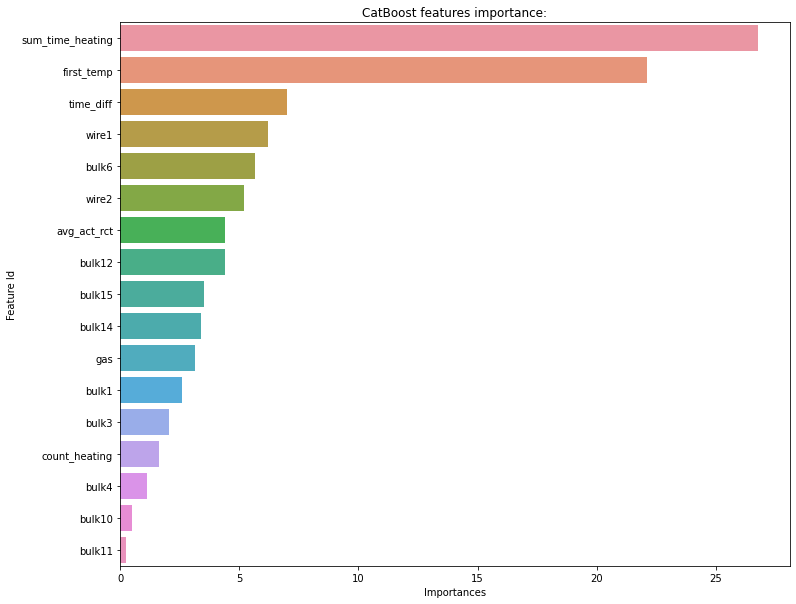

In [55]:
feat_importances = cat_model.get_feature_importance(prettified=True)
plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances)
plt.title('CatBoost features importance:')

Самым важным признаком для модели является суммарное время нагрева. Построим график зависимости данного фактора и целевой переменной.

Text(0.5, 1.0, 'График зависимости итоговой температуры от суммарного времени нагрева')

<Figure size 576x864 with 0 Axes>

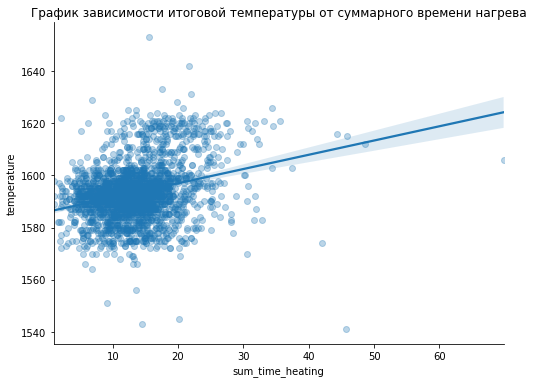

In [56]:
plt.figure(figsize=(8, 12))
sns.lmplot(x='sum_time_heating', y='temperature',
           data=df, scatter_kws={'alpha':0.3}, aspect=14/10)
plt.title('График зависимости итоговой температуры от суммарного времени нагрева')

* По графику прослеживается, что с увеличением времени нагрева, увеличивается и итоговая температура.

## Выводы

In [57]:
table_results

,Name,Best result,Best params
0,CatBoostRegressor,5.77,"{'learning_rate': 0.13, 'max_depth': 4, 'l2_le..."
1,RandomForestRegressor,6.26,"{'max_depth': 17, 'max_features': 16}"
2,FCNeuralNetwork,5.71,"{'n1': 8, 'n2': 2, 'dp1': 0.04}"


* Результаты моделей на валидационных данных:
    * Модель полносвязной нейронной сети показала лучший результат - 5.71, но её результаты нестабильны, происходят сильные колебания;
    * Модель CatBoostRegressor показала близкий результат - 5.77 (MAE), что гораздо ниже заданого таргета - 6.3 и при этом её результаты весьма стабильны, поэтому остановим свой выбор на данной модели;
    * Модель RandomForestRegressor показала наихудший результат - 6.26, но данный показатель все равно ниже заданного таргета.
* CatBoostRegressor показала отличный результат на тестовых данных - 5.16 (MAE), гораздо ниже заданого таргета - 6.3.
* Самым важным признаком для модели CatBoostRegressor, является суммарное время нагрева - при увеличении времени нагрева, увеличивается и итоговая температура.